In [1]:
import os
import re
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import sys
import os
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from neural_lam import constants
import src.seacast_tools.mesh_models.mesh_metrics as mm

In [2]:
dataset = "data/atlantic"
static_dir_path = os.path.join(dataset, "static")
xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))
sea_mask = np.load(os.path.join(static_dir_path, "sea_mask.npy"))
sea_depth = np.load(os.path.join(static_dir_path, "sea_depth.npy"))
sea_mask = sea_mask[0]
grid_xy = torch.tensor(xy)
pos_max = torch.max(torch.abs(grid_xy))

test_dir = os.path.join(dataset, "samples", "test")
predictions_data_to_save = os.path.join(dataset, "predictions", "data")
os.makedirs(predictions_data_to_save, exist_ok=True)

In [3]:
def load_static_data(dataset_name):
    static_dir_path = os.path.join("data", dataset_name, "static")

    # Load boundary mask, 1. if node is part of boundary, else 0.
    boundary_mask_np = np.load(
        os.path.join(static_dir_path, "boundary_mask.npy")
    )  # (depths, h, w)
    print("boundary_mask_np.shape", boundary_mask_np.shape)
    # Load sea mask, 1. if node is part of the sea, else 0.
    sea_mask_np = np.load(
        os.path.join(static_dir_path, "sea_mask.npy")
    )  # (depths, h, w)

    # Mask for the surface grid
    surface_mask_np = sea_mask_np[0]

    # Grid mask for all depth levels to be multiplied with output states
    #plain as 1(300*300)
    boundary_mask =boundary_mask_np.reshape(sea_mask_np.shape[0], -1)   # (depths, N_grid_full)
    border_mask = []
    for level_applies in constants.LEVELS:
        if level_applies:
            border_mask.append(boundary_mask)  # Multi level
        else:
            border_mask.append(boundary_mask[0][np.newaxis, :])  # Single level

    border_mask = np.concatenate(border_mask, axis=0).transpose(1, 0)[np.newaxis, :]  # 1, N_grid, d_features

    # Grid mask for all depth levels to be multiplied with output states
    grid_mask = sea_mask_np[:, surface_mask_np]  # (depths, N_grid)
    sea_mask = []
    for level_applies in constants.LEVELS:
        if level_applies:
            sea_mask.append(grid_mask)  # Multi level
        else:
            sea_mask.append(grid_mask[0][np.newaxis, :])  # Single level

    sea_mask = np.concatenate(sea_mask, axis=0).transpose(1, 0)[np.newaxis, :]  # 1, N_grid, d_features

    # Full grid mask, for plotting purposes
    full_grid_mask = sea_mask_np.reshape(sea_mask_np.shape[0], -1)  # (depths, N_grid_full)
    full_mask = []
    for level_applies in constants.LEVELS:
        if level_applies:
            full_mask.append(full_grid_mask)  # Multi level
        else:
            full_mask.append(full_grid_mask[0][np.newaxis, :])  # Single level

    full_mask = np.concatenate(full_mask, axis=0).transpose(1, 0).astype(bool)  # N_grid_full, d_features

    return {
        "border_mask": border_mask,
        "sea_mask": sea_mask,
        "full_mask": full_mask,
    }

boundary_mask_np.shape (300, 300)


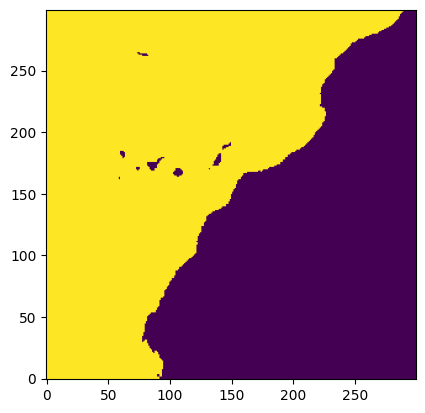

In [4]:
c = load_static_data('atlantic')

sea_mask = c["sea_mask"]
full_mask = c["full_mask"]
#interior_mask = c["sea_mask"] ^ c["border_mask"]
sea_mask_bool = sea_mask[0].astype(bool)
sea_surface = full_mask[:, 0].reshape(*constants.GRID_SHAPE)
plt.imshow(sea_surface, origin="lower")

In [5]:
import numpy as np
from scipy.ndimage import distance_transform_edt, label

def get_african_upwelling_zone(sea_surface: np.ndarray,
                               n_pixels: int = 10) -> np.ndarray:
    """
    Gets the upwelling zone of width n_pixels *only* along
    the African coast, excluding islands.

    Parameters
    ----------
    sea_surface : np.ndarray, bool
    Mask where True = sea, False = land.
    n_pixels : int
    Width of the coastal zone in pixels (default 10).

    Returns
    -------
    np.ndarray, bool
    Mask of the upwelling zone: True = sea pixels within
    n_pixels of the African coast.
    """
    sea = sea_surface.astype(bool)
    land = ~sea

    labeled_land, n_components = label(land)

    sizes = np.bincount(labeled_land.ravel())
    sizes[0] = 0
    main_label = sizes.argmax()

    africa_mask = (labeled_land == main_label)

    dist_mask = ~africa_mask

    dist = distance_transform_edt(dist_mask)

    upwelling_zone = sea & (dist <= n_pixels)

    return upwelling_zone


In [6]:
import numpy as np

def get_non_upwelling_ocean(sea_surface: np.ndarray,
                            upwelling_zone: np.ndarray) -> np.ndarray:
    """
    Genera una máscara booleana de los píxeles de océano que quedan
    fuera de la zona de upwelling.

    Parámetros
    ----------
    sea_surface : np.ndarray, bool
        Máscara donde True = mar, False = tierra.
    upwelling_zone : np.ndarray, bool
        Máscara de la zona de upwelling (True en la franja costera).

    Devuelve
    -------
    np.ndarray, bool
        Máscara booleana donde True = océano sin incluir la franja de upwelling.
    """
    # Asegurarnos de que ambas máscaras son booleanas
    sea = sea_surface.astype(bool)
    upw = upwelling_zone.astype(bool)

    # El océano no-upwelling es mar (sea) menos la franja upwelling (upw)
    non_upwelling = sea & ~upw

    return non_upwelling


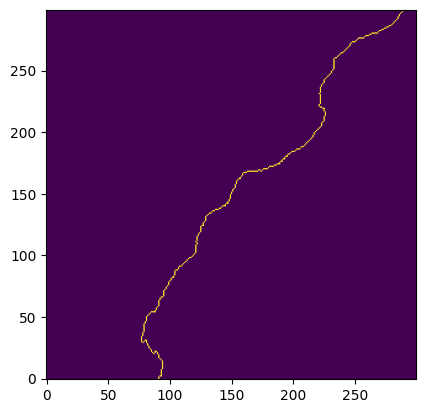

In [7]:
coastal_line = get_african_upwelling_zone(sea_surface, n_pixels=1)
plt.imshow(coastal_line, origin="lower")

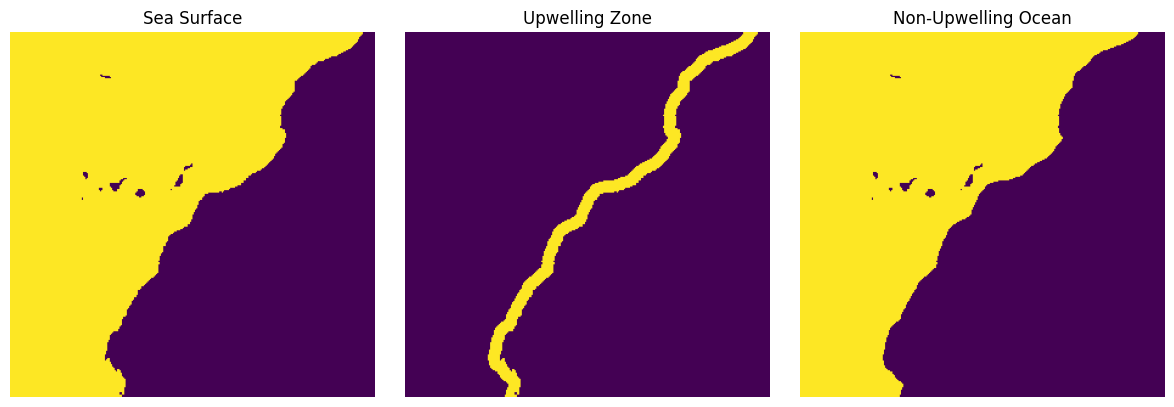

Shape of upwelling zone: (300, 300)
true values: 4128
Shape of non-upwelling ocean: (300, 300)
true values: 44933


In [8]:
upwelling_zone = get_african_upwelling_zone(sea_surface, n_pixels=10)
#ocean_non_upw = get_non_upwelling_ocean(sea_surface, upwelling_zone)
ocean_non_upw = np.logical_and(sea_surface, ~upwelling_zone)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(sea_surface, origin="lower")
axes[0].set_title('Sea Surface')
axes[1].imshow(upwelling_zone, origin="lower")
axes[1].set_title('Upwelling Zone')
axes[2].imshow(ocean_non_upw, origin="lower")
axes[2].set_title('Non-Upwelling Ocean')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Shape of upwelling zone:", upwelling_zone.shape)
print("true values:", np.sum(upwelling_zone))
print("Shape of non-upwelling ocean:", ocean_non_upw.shape)
print("true values:", np.sum(ocean_non_upw))

### Specific Zones mask creation (supplemtentary masks)

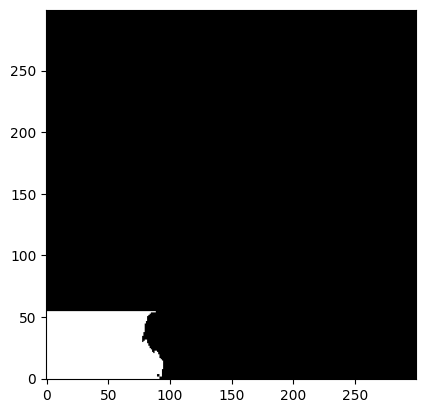

In [9]:
def create_specific_zone_mask(sea_surface_2d: np.ndarray,
                              x_coords,
                              y_coords) -> np.ndarray:
    """
    Creates a 2D mask with the shape defined by x_coords and y_coords,
    with True where there is sea and inside the specified area.

    Parameters
    
    ----------
    sea_surface_2d : np.ndarray(bool), shape (M, N)
        Sea mask over the entire grid (True where there is sea).

    x_coords : array-like of ints, shape (n_x,)
        Column indices of the specified zone.

    y_coords : array-like of ints, shape (n_y,)
        Row indices of the specified zone.

    Returns
    -------
    np.ndarray(bool), shape (n_y, n_x)
        2D mask of the specified zone (True where there is sea and within the zone).
    """

    # Convertir coords a enteros y arrays unidimensionales
    x_coords = np.asarray(x_coords, dtype=int).ravel()
    y_coords = np.asarray(y_coords, dtype=int).ravel()

    # Validar que las coordenadas estén dentro de los límites
    max_y, max_x = sea_surface_2d.shape
    if x_coords.min() < 0 or x_coords.max() >= max_x:
        raise IndexError(f"x_coords fuera de rango: deben estar entre 0 y {max_x - 1}")
    if y_coords.min() < 0 or y_coords.max() >= max_y:
        raise IndexError(f"y_coords fuera de rango: deben estar entre 0 y {max_y - 1}")

    # Extraer la submáscara de la zona especificada
    mask_zone = sea_surface_2d[np.ix_(y_coords, x_coords)]

    return mask_zone

def create_specific_zone_mask_grid(sea_surface_2d: np.ndarray,
                              x_coords,
                              y_coords) -> np.ndarray:

    mask = np.zeros(sea_surface_2d.shape, dtype=bool)
    mask[y_coords[:, None], x_coords] = True
    # Aplicar la máscara de mar
    mask &= sea_surface_2d
    return mask

white_cape_x = np.arange(0, 100)
white_cape_y = np.arange(0, 55)

#mascara de la zona delimitada entre 0 a 100 en x y 0 a 55 en y
white_cape = create_specific_zone_mask_grid(sea_surface, 
                                           x_coords=white_cape_x,
                                           y_coords=white_cape_y)



#plot
plt.imshow(white_cape, origin='lower', cmap='gray')

In [10]:
#save upwelling zone as npy
supplementary_dir = os.path.join("src", "seacast_tools","mesh_models" , "supplementary_masks")
if not os.path.exists(supplementary_dir):
    os.makedirs(supplementary_dir)
np.save(os.path.join(supplementary_dir, "upwelling_zone.npy"), upwelling_zone)
np.save(os.path.join(supplementary_dir, "non_upwelling_ocean.npy"), ocean_non_upw)

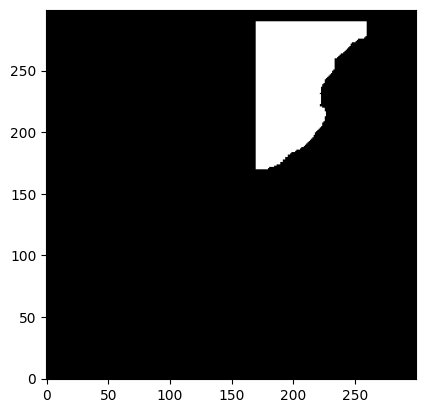

In [11]:
almost_top_cape_x = np.arange(170, 260)
almost_top_cape_y = np.arange(170, 290)
#almost_top_cape_x = np.arange(170, 240)
#almost_top_cape_y = np.arange(170, 250)
#mascara de la zona delimitada entre 105 a 200 en x y 105 a 175 en y
almost_top_cape = create_specific_zone_mask_grid(sea_surface, 
                                           x_coords=almost_top_cape_x,
                                           y_coords=almost_top_cape_y)
#plot
plt.imshow(almost_top_cape, origin='lower', cmap='gray')

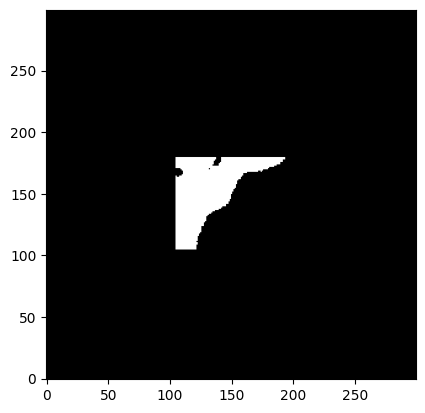

In [12]:
middle_coast_x = np.arange(105, 240)
middle_coast_y = np.arange(105, 180)

#mascara de la zona delimitada entre 105 a 200 en x y 105 a 175 en y
middle_coast = create_specific_zone_mask_grid(sea_surface, 
                                           x_coords=middle_coast_x,
                                           y_coords=middle_coast_y)
#plot
plt.imshow(middle_coast, origin='lower', cmap='gray')

In [13]:
#save all important zones as npy
np.save(os.path.join(supplementary_dir, "white_cape_mask.npy"), white_cape)
np.save(os.path.join(supplementary_dir, "almost_top_cape_mask.npy"), almost_top_cape)
np.save(os.path.join(supplementary_dir, "middle_coast_mask.npy"), middle_coast)

In [14]:
import numpy as np

def flatten_zone_mask(zone_mask_2d: np.ndarray,
                      sea_surface_2d: np.ndarray) -> np.ndarray:
    """
    Convierte una máscara 2D (300×300) en un vector booleano
    alineado con el eje espacial de shape (n_sea_pixels,),
    donde n_sea_pixels = sea_surface_2d.sum() (aquí, 49061).

    Parámetros
    ----------
    zone_mask_2d : np.ndarray(bool), shape (300,300)
        Máscara de zona (upwelling o non-upwelling) sobre toda la grilla.
    sea_surface_2d : np.ndarray(bool), shape (300,300)
        Máscara del mar sobre toda la grilla (True donde hay mar).

    Devuelve
    -------
    np.ndarray(bool), shape (n_sea_pixels,)
        La máscara 1D correspondiente solo a píxeles de mar.
    """
    flat_zone = zone_mask_2d.ravel()          # (300*300=90000,)
    flat_sea  = sea_surface_2d.ravel()        # (90000,)
    sea_idx   = np.where(flat_sea)[0]         # índices de mar (len=49061)
    return flat_zone[sea_idx]                 # (49061,)


def extract_zone_data(stacked: np.ndarray,
                      zone_mask_flat: np.ndarray) -> np.ndarray:
    """
    Extrae de un array 4D (n_samples, n_days, n_sea_pixels, n_var)
    sólo las posiciones donde zone_mask_flat == True.

    Parámetros
    ----------
    stacked : np.ndarray, shape (ns, nd, n_sea, nv)
    zone_mask_flat : np.ndarray(bool), shape (n_sea,)
        Máscara sobre los píxeles de mar.

    Devuelve
    -------
    np.ndarray, shape (ns, nd, n_zone, nv)
    """
    return stacked[:, :, zone_mask_flat, :]

upwelling_flat = flatten_zone_mask(upwelling_zone,
                                       sea_surface)
non_upwelling_flat = flatten_zone_mask(ocean_non_upw,
                                       sea_surface)
#print("Shape of upwelling zone flat:", upwelling_flat.shape)
#print("Shape of non-upwelling zone flat:", non_upwelling_flat.shape)

In [15]:
start_date = datetime.strptime("20230103", "%Y%m%d")
end_date = datetime.strptime("20231217", "%Y%m%d")

date_list = [(start_date + timedelta(days=x)).strftime("%Y%m%d") for x in range((end_date - start_date).days + 1)]
test_arrays = []
for date in date_list:
    test_path = os.path.join(test_dir, f"rea_data_{date}.npy")
    test_arrays.append(np.load(test_path)[2:])

targets = np.stack(test_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
targets_upw = extract_zone_data(targets, upwelling_flat)
targets_non_upw = extract_zone_data(targets, non_upwelling_flat)

In [ ]:
# uniform_run_to_test= "run-20250424_091616-hu9577pl"
# uniform_predictions_dir = os.path.join("wandb", uniform_run_to_test)
# uniform_predicted_files_folder = os.path.join(uniform_predictions_dir, "files")
# uniform_predicted_files = os.path.join(uniform_predicted_files_folder, "predictions")
# uniform_predictions_arrays = []
# for date in date_list:
#     uniform_predicted_file = os.path.join(uniform_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_predicted_file):
#         uniform_predictions_arrays.append(np.load(uniform_predicted_file))
#     else:
#         print(f"File not found: {uniform_predicted_file}")
# uniform_predictions = np.stack(uniform_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# unif_preds_upw   = extract_zone_data(uniform_predictions, upwelling_flat)
# unif_preds_non_upw   = extract_zone_data(uniform_predictions, non_upwelling_flat)
# uniform_predictions_rmse = []

# for t in range(uniform_predictions.shape[1]):
#     masked_diff_persistence = (uniform_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_predictions_rmse.append(rmse_p)

# uniform_model_rmse = np.array(uniform_predictions_rmse)

# uniform_pred_rmse_upw = []
# uniform_pred_rmse_non_upw = []
# for t in range(unif_preds_upw.shape[1]):
#     masked_diff_persistence = (unif_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_pred_rmse_upw.append(rmse_p)

# for t in range(unif_preds_non_upw.shape[1]):
#     masked_diff_persistence = (unif_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_pred_rmse_non_upw.append(rmse_p)

# uniform_pred_rmse_upw = np.array(uniform_pred_rmse_upw)
# uniform_pred_rmse_non_upw = np.array(uniform_pred_rmse_non_upw)

# #save all
# uniform_folder = os.path.join(predictions_data_to_save, "uniform_data")
# os.makedirs(uniform_folder, exist_ok=True)
# np.save(os.path.join(uniform_folder, "uniform_predictions_rmse.npy"), uniform_predictions_rmse)
# np.save(os.path.join(uniform_folder, "uniform_pred_rmse_upw.npy"), uniform_pred_rmse_upw)
# np.save(os.path.join(uniform_folder, "uniform_pred_rmse_non_upw.npy"), uniform_pred_rmse_non_upw)
# np.save(os.path.join(uniform_folder, "unif_preds_non_upw.npy"), unif_preds_non_upw)
# np.save(os.path.join(uniform_folder, "unif_preds_upw.npy"), unif_preds_upw)


In [ ]:
# bathymetry_run_to_test = "run-20250429_085730-ebry7nbt"
# bathymetry_predictions_dir = os.path.join("wandb", bathymetry_run_to_test)
# bathymetry_predicted_files_folder = os.path.join(bathymetry_predictions_dir, "files")
# bathymetry_predicted_files = os.path.join(bathymetry_predicted_files_folder, "predictions")
# bathymetry_predictions_arrays = []
# for date in date_list:
#     bathymetry_predicted_file = os.path.join(bathymetry_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(bathymetry_predicted_file):
#         bathymetry_predictions_arrays.append(np.load(bathymetry_predicted_file))
#     else:
#         print(f"File not found: {bathymetry_predicted_file}")
# bathymetry_predictions = np.stack(bathymetry_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# bath_preds_upw = extract_zone_data(bathymetry_predictions, upwelling_flat)
# bath_preds_non_upw = extract_zone_data(bathymetry_predictions, non_upwelling_flat)
# # calculate RMSE
# bathymetry_predictions_rmse = []
# for t in range(bathymetry_predictions.shape[1]):
#     masked_diff_persistence = (bathymetry_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     bathymetry_predictions_rmse.append(rmse_p)

# bathymetry_model_rmse = np.array(bathymetry_predictions_rmse)

# bathymetry_pred_rmse_upw = []
# bathymetry_pred_rmse_non_upw = []
# for t in range(bath_preds_upw.shape[1]):
#     masked_diff_persistence = (bath_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     bathymetry_pred_rmse_upw.append(rmse_p)
    
# for t in range(bath_preds_non_upw.shape[1]):
#     masked_diff_persistence = (bath_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     bathymetry_pred_rmse_non_upw.append(rmse_p)
# bathymetry_pred_rmse_upw = np.array(bathymetry_pred_rmse_upw)
# bathymetry_pred_rmse_non_upw = np.array(bathymetry_pred_rmse_non_upw)

# #save all
# bathymetry_folder = os.path.join(predictions_data_to_save, "bathymetry_data")
# os.makedirs(bathymetry_folder, exist_ok=True)
# np.save(os.path.join(bathymetry_folder, "bathymetry_predictions_rmse.npy"), bathymetry_predictions_rmse)
# np.save(os.path.join(bathymetry_folder, "bathymetry_pred_rmse_upw.npy"), bathymetry_pred_rmse_upw)
# np.save(os.path.join(bathymetry_folder, "bathymetry_pred_rmse_non_upw.npy"), bathymetry_pred_rmse_non_upw)
# np.save(os.path.join(bathymetry_folder, "bath_preds_non_upw.npy"), bath_preds_non_upw)
# np.save(os.path.join(bathymetry_folder, "bath_preds_upw.npy"), bath_preds_upw)


In [ ]:
# random_run_to_test = "run-20250429_100848-5z9cicdv"
# random_predictions_dir = os.path.join("wandb", random_run_to_test)
# random_predicted_files_folder = os.path.join(random_predictions_dir, "files")
# random_predicted_files = os.path.join(random_predicted_files_folder, "predictions")

# random_predictions_arrays = []
# for date in date_list:
#     random_predicted_file = os.path.join(random_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(random_predicted_file):
#         random_predictions_arrays.append(np.load(random_predicted_file))
#     else:
#         print(f"File not found: {random_predicted_file}")
# random_predictions = np.stack(random_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# random_preds_upw   = extract_zone_data(random_predictions, upwelling_flat)
# random_preds_non_upw   = extract_zone_data(random_predictions, non_upwelling_flat)
# # calculate RMSE
# random_predictions_rmse = []
# for t in range(random_predictions.shape[1]):
#     masked_diff_persistence = (random_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     random_predictions_rmse.append(rmse_p)
# random_model_rmse = np.array(random_predictions_rmse)
# random_pred_rmse_upw = []
# random_pred_rmse_non_upw = []
# for t in range(random_preds_upw.shape[1]):
#     masked_diff_persistence = (random_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     random_pred_rmse_upw.append(rmse_p)
# for t in range(random_preds_non_upw.shape[1]):
#     masked_diff_persistence = (random_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     random_pred_rmse_non_upw.append(rmse_p)
# random_pred_rmse_upw = np.array(random_pred_rmse_upw)
# random_pred_rmse_non_upw = np.array(random_pred_rmse_non_upw)

# #save all
# random_folder = os.path.join(predictions_data_to_save, "random_data")
# os.makedirs(random_folder, exist_ok=True)
# np.save(os.path.join(random_folder, "random_predictions_rmse.npy"), random_predictions)
# np.save(os.path.join(random_folder, "random_pred_rmse_upw.npy"), random_pred_rmse_upw)
# np.save(os.path.join(random_folder, "random_pred_rmse_non_upw.npy"), random_pred_rmse_non_upw)
# np.save(os.path.join(random_folder, "random_preds_non_upw.npy"), random_preds_non_upw)
# np.save(os.path.join(random_folder, "random_preds_upw.npy"), random_preds_upw)


In [ ]:
# uniform_nce_27_9_3 = "run-20250606_200643-rz076d8s_nce_27_9_3_v2"
# uniform_nce_27_9_3_predictions_dir = os.path.join("wandb", uniform_nce_27_9_3)
# uniform_nce_27_9_3_predicted_files_folder = os.path.join(uniform_nce_27_9_3_predictions_dir, "files")
# uniform_nce_27_9_3_predicted_files = os.path.join(uniform_nce_27_9_3_predicted_files_folder, "predictions")
# uniform_nce_27_9_3_predictions_arrays = []
# for date in date_list:
#     uniform_nce_27_9_3_predicted_file = os.path.join(uniform_nce_27_9_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_27_9_3_predicted_file):
#         uniform_nce_27_9_3_predictions_arrays.append(np.load(uniform_nce_27_9_3_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_27_9_3_predicted_file}")
# uniform_nce_27_9_3_predictions = np.stack(uniform_nce_27_9_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# unif_nce_27_9_3_preds_upw   = extract_zone_data(uniform_nce_27_9_3_predictions, upwelling_flat)
# unif_nce_27_9_3_preds_non_upw   = extract_zone_data(uniform_nce_27_9_3_predictions, non_upwelling_flat)
# # calculate RMSE
# uniform_nce_27_9_3_predictions_rmse = []
# for t in range(uniform_nce_27_9_3_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_27_9_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_27_9_3_predictions_rmse.append(rmse_p)
# uniform_nce_27_9_3_model_rmse = np.array(uniform_nce_27_9_3_predictions_rmse)
# uniform_nce_27_9_3_pred_rmse_upw = []
# uniform_nce_27_9_3_pred_rmse_non_upw = []
# for t in range(unif_nce_27_9_3_preds_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_27_9_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_27_9_3_pred_rmse_upw.append(rmse_p)
# for t in range(unif_nce_27_9_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_27_9_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_27_9_3_pred_rmse_non_upw.append(rmse_p)

# uniform_nce_27_9_3_pred_rmse_upw = np.array(uniform_nce_27_9_3_pred_rmse_upw)
# uniform_nce_27_9_3_pred_rmse_non_upw = np.array(uniform_nce_27_9_3_pred_rmse_non_upw)

# #save all
# uniform_nce_27_9_3_folder = os.path.join(predictions_data_to_save, "uniform_nce_27_9_3_data")
# os.makedirs(uniform_nce_27_9_3_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "uniform_nce_27_9_3_predictions_rmse.npy"), uniform_nce_27_9_3_predictions)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "uniform_nce_27_9_3_pred_rmse_upw.npy"), uniform_nce_27_9_3_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "uniform_nce_27_9_3_pred_rmse_non_upw.npy"), uniform_nce_27_9_3_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "unif_nce_27_9_3_preds_non_upw.npy"), unif_nce_27_9_3_preds_non_upw)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "unif_nce_27_9_3_preds_upw.npy"), unif_nce_27_9_3_preds_upw)
# np.save(os.path.join(uniform_nce_27_9_3_folder, "uniform_nce_27_9_3_model_rmse.npy"), uniform_nce_27_9_3_model_rmse)


In [ ]:
# uniform_nce_45_15_5 = "run-20250607_174307-e1s8h1b4_nce_45_15_5_v2"
# uniform_nce_45_15_5_predictions_dir = os.path.join("wandb", uniform_nce_45_15_5)
# uniform_nce_45_15_5_predicted_files_folder = os.path.join(uniform_nce_45_15_5_predictions_dir, "files")
# uniform_nce_45_15_5_predicted_files = os.path.join(uniform_nce_45_15_5_predicted_files_folder, "predictions")
# uniform_nce_45_15_5_predictions_arrays = []
# for date in date_list:
#     uniform_nce_45_15_5_predicted_file = os.path.join(uniform_nce_45_15_5_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_45_15_5_predicted_file):
#         uniform_nce_45_15_5_predictions_arrays.append(np.load(uniform_nce_45_15_5_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_45_15_5_predicted_file}")
# uniform_nce_45_15_5_predictions = np.stack(uniform_nce_45_15_5_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# unif_nce_45_15_5_preds_upw   = extract_zone_data(uniform_nce_45_15_5_predictions, upwelling_flat)
# unif_nce_45_15_5_preds_non_upw   = extract_zone_data(uniform_nce_45_15_5_predictions, non_upwelling_flat)

# # calculate RMSE
# uniform_nce_45_15_5_predictions_rmse = []
# for t in range(uniform_nce_45_15_5_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_45_15_5_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_45_15_5_predictions_rmse.append(rmse_p)
# uniform_nce_45_15_5_model_rmse = np.array(uniform_nce_45_15_5_predictions_rmse)
# uniform_nce_45_15_5_pred_rmse_upw = []
# uniform_nce_45_15_5_pred_rmse_non_upw = []
# for t in range(unif_nce_45_15_5_preds_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_45_15_5_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_45_15_5_pred_rmse_upw.append(rmse_p)
# for t in range(unif_nce_45_15_5_preds_non_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_45_15_5_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_45_15_5_pred_rmse_non_upw.append(rmse_p)
# uniform_nce_45_15_5_pred_rmse_upw = np.array(uniform_nce_45_15_5_pred_rmse_upw)
# uniform_nce_45_15_5_pred_rmse_non_upw = np.array(uniform_nce_45_15_5_pred_rmse_non_upw)

# #save all
# uniform_nce_45_15_5_folder = os.path.join(predictions_data_to_save, "uniform_nce_45_15_5_data")
# os.makedirs(uniform_nce_45_15_5_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "uniform_nce_45_15_5_predictions_rmse.npy"), uniform_nce_45_15_5_predictions)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "uniform_nce_45_15_5_pred_rmse_upw.npy"), uniform_nce_45_15_5_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "uniform_nce_45_15_5_pred_rmse_non_upw.npy"), uniform_nce_45_15_5_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "unif_nce_45_15_5_preds_non_upw.npy"), unif_nce_45_15_5_preds_non_upw)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "unif_nce_45_15_5_preds_upw.npy"), unif_nce_45_15_5_preds_upw)
# np.save(os.path.join(uniform_nce_45_15_5_folder, "uniform_nce_45_15_5_model_rmse.npy"), uniform_nce_45_15_5_model_rmse)


In [ ]:
# uniform_nce_63_21_7 = "run-20250607_181143-w0ye4e46_nce_63_21_7_v2"
# uniform_nce_63_21_7_predictions_dir = os.path.join("wandb", uniform_nce_63_21_7)
# uniform_nce_63_21_7_predicted_files_folder = os.path.join(uniform_nce_63_21_7_predictions_dir, "files")
# uniform_nce_63_21_7_predicted_files = os.path.join(uniform_nce_63_21_7_predicted_files_folder, "predictions")
# uniform_nce_63_21_7_predictions_arrays = []
# for date in date_list:
#     uniform_nce_63_21_7_predicted_file = os.path.join(uniform_nce_63_21_7_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_63_21_7_predicted_file):
#         uniform_nce_63_21_7_predictions_arrays.append(np.load(uniform_nce_63_21_7_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_63_21_7_predicted_file}")
# uniform_nce_63_21_7_predictions = np.stack(uniform_nce_63_21_7_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# unif_nce_63_21_7_preds_upw   = extract_zone_data(uniform_nce_63_21_7_predictions, upwelling_flat)
# unif_nce_63_21_7_preds_non_upw   = extract_zone_data(uniform_nce_63_21_7_predictions, non_upwelling_flat)
# # calculate RMSE
# uniform_nce_63_21_7_predictions_rmse = []
# for t in range(uniform_nce_63_21_7_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_63_21_7_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_63_21_7_predictions_rmse.append(rmse_p)
# uniform_nce_63_21_7_model_rmse = np.array(uniform_nce_63_21_7_predictions_rmse)
# uniform_nce_63_21_7_pred_rmse_upw = []
# uniform_nce_63_21_7_pred_rmse_non_upw = []
# for t in range(unif_nce_63_21_7_preds_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_63_21_7_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_63_21_7_pred_rmse_upw.append(rmse_p)
# for t in range(unif_nce_63_21_7_preds_non_upw.shape[1]):
#     masked_diff_persistence = (unif_nce_63_21_7_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_63_21_7_pred_rmse_non_upw.append(rmse_p)
# uniform_nce_63_21_7_pred_rmse_upw = np.array(uniform_nce_63_21_7_pred_rmse_upw)
# uniform_nce_63_21_7_pred_rmse_non_upw = np.array(uniform_nce_63_21_7_pred_rmse_non_upw)

# #save all
# uniform_nce_63_21_7_folder = os.path.join(predictions_data_to_save, "uniform_nce_63_21_7_data")
# os.makedirs(uniform_nce_63_21_7_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "uniform_nce_63_21_7_predictions_rmse.npy"), uniform_nce_63_21_7_predictions)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "uniform_nce_63_21_7_pred_rmse_upw.npy"), uniform_nce_63_21_7_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "uniform_nce_63_21_7_pred_rmse_non_upw.npy"), uniform_nce_63_21_7_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "unif_nce_63_21_7_preds_non_upw.npy"), unif_nce_63_21_7_preds_non_upw)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "unif_nce_63_21_7_preds_upw.npy"), unif_nce_63_21_7_preds_upw)
# np.save(os.path.join(uniform_nce_63_21_7_folder, "uniform_nce_63_21_7_model_rmse.npy"), uniform_nce_63_21_7_model_rmse)

In [ ]:
uniform_nce_81_27_9 = "run-20250607_193049-jl7bqev6_nce_81_27_9_v2"
uniform_nce_81_27_9_predictions_dir = os.path.join("wandb", uniform_nce_81_27_9)
uniform_nce_81_27_9_predicted_files_folder = os.path.join(uniform_nce_81_27_9_predictions_dir, "files")
uniform_nce_81_27_9_predicted_files = os.path.join(uniform_nce_81_27_9_predicted_files_folder, "predictions")
uniform_nce_81_27_9_predictions_arrays = []
for date in date_list:
    uniform_nce_81_27_9_predicted_file = os.path.join(uniform_nce_81_27_9_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(uniform_nce_81_27_9_predicted_file):
        uniform_nce_81_27_9_predictions_arrays.append(np.load(uniform_nce_81_27_9_predicted_file))
    else:
        print(f"File not found: {uniform_nce_81_27_9_predicted_file}")
uniform_nce_81_27_9_predictions = np.stack(uniform_nce_81_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
unif_nce_81_27_9_preds_upw   = extract_zone_data(uniform_nce_81_27_9_predictions, upwelling_flat)
unif_nce_81_27_9_preds_non_upw   = extract_zone_data(uniform_nce_81_27_9_predictions, non_upwelling_flat)
# calculate RMSE
uniform_nce_81_27_9_predictions_rmse = []
for t in range(uniform_nce_81_27_9_predictions.shape[1]):
    masked_diff_persistence = (uniform_nce_81_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    uniform_nce_81_27_9_predictions_rmse.append(rmse_p)
uniform_nce_81_27_9_model_rmse = np.array(uniform_nce_81_27_9_predictions_rmse)
uniform_nce_81_27_9_pred_rmse_upw = []
uniform_nce_81_27_9_pred_rmse_non_upw = []
for t in range(unif_nce_81_27_9_preds_upw.shape[1]):
    masked_diff_persistence = (unif_nce_81_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    uniform_nce_81_27_9_pred_rmse_upw.append(rmse_p)
for t in range(unif_nce_81_27_9_preds_non_upw.shape[1]):
    masked_diff_persistence = (unif_nce_81_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    uniform_nce_81_27_9_pred_rmse_non_upw.append(rmse_p)
uniform_nce_81_27_9_pred_rmse_upw = np.array(uniform_nce_81_27_9_pred_rmse_upw)
uniform_nce_81_27_9_pred_rmse_non_upw = np.array(uniform_nce_81_27_9_pred_rmse_non_upw)

#save all
uniform_nce_81_27_9_folder = os.path.join(predictions_data_to_save, "uniform_nce_81_27_9_data")
os.makedirs(uniform_nce_81_27_9_folder, exist_ok=True)
np.save(os.path.join(uniform_nce_81_27_9_folder, "uniform_nce_81_27_9_predictions.npy"), uniform_nce_81_27_9_predictions)
np.save(os.path.join(uniform_nce_81_27_9_folder, "uniform_nce_81_27_9_pred_rmse_upw.npy"), uniform_nce_81_27_9_pred_rmse_upw)
np.save(os.path.join(uniform_nce_81_27_9_folder, "uniform_nce_81_27_9_pred_rmse_non_upw.npy"), uniform_nce_81_27_9_pred_rmse_non_upw)
np.save(os.path.join(uniform_nce_81_27_9_folder, "unif_nce_81_27_9_preds_non_upw.npy"), unif_nce_81_27_9_preds_non_upw)
np.save(os.path.join(uniform_nce_81_27_9_folder, "unif_nce_81_27_9_preds_upw.npy"), unif_nce_81_27_9_preds_upw)
#save uniform_nce_81_27_9_model_rmse 
np.save(os.path.join(uniform_nce_81_27_9_folder, "uniform_nce_81_27_9_model_rmse.npy"), uniform_nce_81_27_9_model_rmse)


In [38]:
uniform_ce_81_27_9 = "run-20250607_195348-unnja3c2_ce_81_27_9_v2"
uniform_ce_81_27_9_predictions_dir = os.path.join("wandb", uniform_ce_81_27_9)
uniform_ce_81_27_9_predicted_files_folder = os.path.join(uniform_ce_81_27_9_predictions_dir, "files")
uniform_ce_81_27_9_predicted_files = os.path.join(uniform_ce_81_27_9_predicted_files_folder, "predictions")
uniform_ce_81_27_9_predictions_arrays = []
for date in date_list:
    uniform_ce_81_27_9_predicted_file = os.path.join(uniform_ce_81_27_9_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(uniform_ce_81_27_9_predicted_file):
        uniform_ce_81_27_9_predictions_arrays.append(np.load(uniform_ce_81_27_9_predicted_file))
    else:
        print(f"File not found: {uniform_ce_81_27_9_predicted_file}")
uniform_ce_81_27_9_predictions = np.stack(uniform_ce_81_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
unif_ce_81_27_9_preds_upw   = extract_zone_data(uniform_ce_81_27_9_predictions, upwelling_flat)
unif_ce_81_27_9_preds_non_upw   = extract_zone_data(uniform_ce_81_27_9_predictions, non_upwelling_flat)
# calculate RMSE
uniform_ce_81_27_9_predictions_rmse = []
for t in range(uniform_ce_81_27_9_predictions.shape[1]):
    masked_diff_persistence = (uniform_ce_81_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    uniform_ce_81_27_9_predictions_rmse.append(rmse_p)
uniform_ce_81_27_9_model_rmse = np.array(uniform_ce_81_27_9_predictions_rmse)
uniform_ce_81_27_9_pred_rmse_upw = []
uniform_ce_81_27_9_pred_rmse_non_upw = []
for t in range(unif_ce_81_27_9_preds_upw.shape[1]):
    masked_diff_persistence = (unif_ce_81_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    uniform_ce_81_27_9_pred_rmse_upw.append(rmse_p)
for t in range(unif_ce_81_27_9_preds_non_upw.shape[1]):
    masked_diff_persistence = (unif_ce_81_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    uniform_ce_81_27_9_pred_rmse_non_upw.append(rmse_p)
uniform_ce_81_27_9_pred_rmse_upw = np.array(uniform_ce_81_27_9_pred_rmse_upw)
uniform_ce_81_27_9_pred_rmse_non_upw = np.array(uniform_ce_81_27_9_pred_rmse_non_upw)

#save all
uniform_ce_81_27_9_folder = os.path.join(predictions_data_to_save, "uniform_ce_81_27_9_data")
os.makedirs(uniform_ce_81_27_9_folder, exist_ok=True)
np.save(os.path.join(uniform_ce_81_27_9_folder, "uniform_ce_81_27_9_predictions.npy"), uniform_ce_81_27_9_predictions)
np.save(os.path.join(uniform_ce_81_27_9_folder, "uniform_ce_81_27_9_pred_rmse_upw.npy"), uniform_ce_81_27_9_pred_rmse_upw)
np.save(os.path.join(uniform_ce_81_27_9_folder, "uniform_ce_81_27_9_pred_rmse_non_upw.npy"), uniform_ce_81_27_9_pred_rmse_non_upw)
np.save(os.path.join(uniform_ce_81_27_9_folder, "unif_ce_81_27_9_preds_non_upw.npy"), unif_ce_81_27_9_preds_non_upw)
np.save(os.path.join(uniform_ce_81_27_9_folder, "unif_ce_81_27_9_preds_upw.npy"), unif_ce_81_27_9_preds_upw)
np.save(os.path.join(uniform_ce_81_27_9_folder, "uniform_ce_81_27_9_model_rmse.npy"), uniform_ce_81_27_9_model_rmse)

In [ ]:
# uniform_nce_12_6_3 = "run-20250606_193155-psexnv4r_nce_12_6_3_v2"
# uniform_nce_12_6_3_predictions_dir = os.path.join("wandb", uniform_nce_12_6_3)
# uniform_nce_12_6_3_predicted_files_folder = os.path.join(uniform_nce_12_6_3_predictions_dir, "files")
# uniform_nce_12_6_3_predicted_files = os.path.join(uniform_nce_12_6_3_predicted_files_folder, "predictions")
# uniform_nce_12_6_3_predictions_arrays = []
# for date in date_list:
#     uniform_nce_12_6_3_predicted_file = os.path.join(uniform_nce_12_6_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_12_6_3_predicted_file):
#         uniform_nce_12_6_3_predictions_arrays.append(np.load(uniform_nce_12_6_3_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_12_6_3_predicted_file}")
# uniform_nce_12_6_3_predictions = np.stack(uniform_nce_12_6_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# uniform_nce_12_6_3_preds_upw   = extract_zone_data(uniform_nce_12_6_3_predictions, upwelling_flat)
# uniform_nce_12_6_3_preds_non_upw   = extract_zone_data(uniform_nce_12_6_3_predictions, non_upwelling_flat)
# # calculate RMSE
# uniform_nce_12_6_3_predictions_rmse = []
# for t in range(uniform_nce_12_6_3_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_12_6_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_12_6_3_predictions_rmse.append(rmse_p)
# uniform_nce_12_6_3_model_rmse = np.array(uniform_nce_12_6_3_predictions_rmse)
# uniform_nce_12_6_3_pred_rmse_upw = []
# uniform_nce_12_6_3_pred_rmse_non_upw = []
# for t in range(uniform_nce_12_6_3_preds_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_12_6_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_12_6_3_pred_rmse_upw.append(rmse_p)
# for t in range(uniform_nce_12_6_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_12_6_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_12_6_3_pred_rmse_non_upw.append(rmse_p)
# uniform_nce_12_6_3_pred_rmse_upw = np.array(uniform_nce_12_6_3_pred_rmse_upw)
# uniform_nce_12_6_3_pred_rmse_non_upw = np.array(uniform_nce_12_6_3_pred_rmse_non_upw)

# #save all
# uniform_nce_12_6_3_folder = os.path.join(predictions_data_to_save, "uniform_nce_12_6_3_data")
# os.makedirs(uniform_nce_12_6_3_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_predictions_rmse.npy"), uniform_nce_12_6_3_predictions)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_pred_rmse_upw.npy"), uniform_nce_12_6_3_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_pred_rmse_non_upw.npy"), uniform_nce_12_6_3_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_preds_non_upw.npy"), uniform_nce_12_6_3_preds_non_upw)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_preds_upw.npy"), uniform_nce_12_6_3_preds_upw)
# np.save(os.path.join(uniform_nce_12_6_3_folder, "uniform_nce_12_6_3_model_rmse.npy"), uniform_nce_12_6_3_model_rmse)

In [ ]:
# uniform_nce_5_4_3 = "run-20250606_191642-dnaz75fj_nce_5_4_3_v2"
# uniform_nce_5_4_3_predictions_dir = os.path.join("wandb", uniform_nce_5_4_3)
# uniform_nce_5_4_3_predicted_files_folder = os.path.join(uniform_nce_5_4_3_predictions_dir, "files")
# uniform_nce_5_4_3_predicted_files = os.path.join(uniform_nce_5_4_3_predicted_files_folder, "predictions")
# uniform_nce_5_4_3_predictions_arrays = []
# for date in date_list:
#     uniform_nce_5_4_3_predicted_file = os.path.join(uniform_nce_5_4_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_5_4_3_predicted_file):
#         uniform_nce_5_4_3_predictions_arrays.append(np.load(uniform_nce_5_4_3_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_5_4_3_predicted_file}")
# uniform_nce_5_4_3_predictions = np.stack(uniform_nce_5_4_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# uniform_nce_5_4_3_preds_upw   = extract_zone_data(uniform_nce_5_4_3_predictions, upwelling_flat)
# uniform_nce_5_4_3_preds_non_upw   = extract_zone_data(uniform_nce_5_4_3_predictions, non_upwelling_flat)
# # calculate RMSE
# uniform_nce_5_4_3_predictions_rmse = []
# for t in range(uniform_nce_5_4_3_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_4_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_5_4_3_predictions_rmse.append(rmse_p)
# uniform_nce_5_4_3_model_rmse = np.array(uniform_nce_5_4_3_predictions_rmse)

# uniform_nce_5_4_3_pred_rmse_upw = []
# uniform_nce_5_4_3_pred_rmse_non_upw = []
# for t in range(uniform_nce_5_4_3_preds_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_4_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_5_4_3_pred_rmse_upw.append(rmse_p)
# for t in range(uniform_nce_5_4_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_4_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_5_4_3_pred_rmse_non_upw.append(rmse_p)
# uniform_nce_5_4_3_pred_rmse_non_upw = np.array(uniform_nce_5_4_3_pred_rmse_non_upw)
# uniform_nce_5_4_3_pred_rmse_upw = np.array(uniform_nce_5_4_3_pred_rmse_upw)

# #save_all
# uniform_nce_5_4_3_folder = os.path.join(predictions_data_to_save, "uniform_nce_5_4_3_data")
# os.makedirs(uniform_nce_5_4_3_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_predictions_rmse.npy"), uniform_nce_5_4_3_predictions)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_pred_rmse_upw.npy"), uniform_nce_5_4_3_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_pred_rmse_non_upw.npy"), uniform_nce_5_4_3_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_preds_non_upw.npy"), uniform_nce_5_4_3_preds_non_upw)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_preds_upw.npy"), uniform_nce_5_4_3_preds_upw)
# np.save(os.path.join(uniform_nce_5_4_3_folder, "uniform_nce_5_4_3_model_rmse.npy"), uniform_nce_5_4_3_model_rmse)

In [ ]:
# uniform_nce_5_3 = "run-20250606_190009-qbbpt8xi_nce_5_3_v2"
# uniform_nce_5_3_predictions_dir = os.path.join("wandb", uniform_nce_5_3)
# uniform_nce_5_3_predicted_files_folder = os.path.join(uniform_nce_5_3_predictions_dir, "files")
# uniform_nce_5_3_predicted_files = os.path.join(uniform_nce_5_3_predicted_files_folder, "predictions")
# uniform_nce_5_3_predictions_arrays = []
# for date in date_list:
#     uniform_nce_5_3_predicted_file = os.path.join(uniform_nce_5_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(uniform_nce_5_3_predicted_file):
#         uniform_nce_5_3_predictions_arrays.append(np.load(uniform_nce_5_3_predicted_file))
#     else:
#         print(f"File not found: {uniform_nce_5_3_predicted_file}")
# uniform_nce_5_3_predictions = np.stack(uniform_nce_5_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# uniform_nce_5_3_preds_upw   = extract_zone_data(uniform_nce_5_3_predictions, upwelling_flat)
# uniform_nce_5_3_preds_non_upw   = extract_zone_data(uniform_nce_5_3_predictions, non_upwelling_flat)
# # calculate RMSE
# uniform_nce_5_3_predictions_rmse = []
# for t in range(uniform_nce_5_3_predictions.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     uniform_nce_5_3_predictions_rmse.append(rmse_p)
# uniform_nce_5_3_model_rmse = np.array(uniform_nce_5_3_predictions_rmse)
# uniform_nce_5_3_pred_rmse_upw = []
# uniform_nce_5_3_pred_rmse_non_upw = []
# for t in range(uniform_nce_5_3_preds_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     uniform_nce_5_3_pred_rmse_upw.append(rmse_p)
# for t in range(uniform_nce_5_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (uniform_nce_5_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     uniform_nce_5_3_pred_rmse_non_upw.append(rmse_p)
# uniform_nce_5_3_pred_rmse_upw = np.array(uniform_nce_5_3_pred_rmse_upw)
# uniform_nce_5_3_pred_rmse_non_upw = np.array(uniform_nce_5_3_pred_rmse_non_upw)

# #save all
# uniform_nce_5_3_folder = os.path.join(predictions_data_to_save, "uniform_nce_5_3_data")
# os.makedirs(uniform_nce_5_3_folder, exist_ok=True)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_predictions_rmse.npy"), uniform_nce_5_3_predictions)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_pred_rmse_upw.npy"), uniform_nce_5_3_pred_rmse_upw)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_pred_rmse_non_upw.npy"), uniform_nce_5_3_pred_rmse_non_upw)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_preds_non_upw.npy"), uniform_nce_5_3_preds_non_upw)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_preds_upw.npy"), uniform_nce_5_3_preds_upw)
# np.save(os.path.join(uniform_nce_5_3_folder, "uniform_nce_5_3_model_rmse.npy"), uniform_nce_5_3_model_rmse)

In [ ]:
# fps_81_27_9 = "run-20250605_170414-cxplldm6_fps_81_27_9"
# fps_81_27_9_predictions_dir = os.path.join("wandb", fps_81_27_9)
# fps_81_27_9_predicted_files_folder = os.path.join(fps_81_27_9_predictions_dir, "files")
# fps_81_27_9_predicted_files = os.path.join(fps_81_27_9_predicted_files_folder, "predictions")
# fps_81_27_9_predictions_arrays = []
# for date in date_list:
#     fps_81_27_9_predicted_file = os.path.join(fps_81_27_9_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_81_27_9_predicted_file):
#         fps_81_27_9_predictions_arrays.append(np.load(fps_81_27_9_predicted_file))
#     else:
#         print(f"File not found: {fps_81_27_9_predicted_file}")
# fps_81_27_9_predictions = np.stack(fps_81_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_81_27_9_preds_upw   = extract_zone_data(fps_81_27_9_predictions, upwelling_flat)
# fps_81_27_9_preds_non_upw   = extract_zone_data(fps_81_27_9_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_81_27_9_predictions_rmse = []
# for t in range(fps_81_27_9_predictions.shape[1]):
#     masked_diff_persistence = (fps_81_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_81_27_9_predictions_rmse.append(rmse_p)
# fps_81_27_9_model_rmse = np.array(fps_81_27_9_predictions_rmse)
# fps_81_27_9_pred_rmse_upw = []
# fps_81_27_9_pred_rmse_non_upw = []
# for t in range(fps_81_27_9_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_81_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_81_27_9_pred_rmse_upw.append(rmse_p)
# for t in range(fps_81_27_9_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_81_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_81_27_9_pred_rmse_non_upw.append(rmse_p)
# fps_81_27_9_pred_rmse_upw = np.array(fps_81_27_9_pred_rmse_upw)
# fps_81_27_9_pred_rmse_non_upw = np.array(fps_81_27_9_pred_rmse_non_upw)

In [ ]:
# fps_63_21_7 = "run-20250605_172406-c78r5nff_fps_63_21_7"
# fps_63_21_7_predictions_dir = os.path.join("wandb", fps_63_21_7)
# fps_63_21_7_predicted_files_folder = os.path.join(fps_63_21_7_predictions_dir, "files")
# fps_63_21_7_predicted_files = os.path.join(fps_63_21_7_predicted_files_folder, "predictions")
# fps_63_21_7_predictions_arrays = []
# for date in date_list:
#     fps_63_21_7_predicted_file = os.path.join(fps_63_21_7_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_63_21_7_predicted_file):
#         fps_63_21_7_predictions_arrays.append(np.load(fps_63_21_7_predicted_file))
#     else:
#         print(f"File not found: {fps_63_21_7_predicted_file}")
# fps_63_21_7_predictions = np.stack(fps_63_21_7_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_63_21_7_preds_upw   = extract_zone_data(fps_63_21_7_predictions, upwelling_flat)
# fps_63_21_7_preds_non_upw   = extract_zone_data(fps_63_21_7_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_63_21_7_predictions_rmse = []
# for t in range(fps_63_21_7_predictions.shape[1]):
#     masked_diff_persistence = (fps_63_21_7_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_63_21_7_predictions_rmse.append(rmse_p)
# fps_63_21_7_model_rmse = np.array(fps_63_21_7_predictions_rmse)
# fps_63_21_7_pred_rmse_upw = []
# fps_63_21_7_pred_rmse_non_upw = []
# for t in range(fps_63_21_7_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_63_21_7_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_63_21_7_pred_rmse_upw.append(rmse_p)
# for t in range(fps_63_21_7_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_63_21_7_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_63_21_7_pred_rmse_non_upw.append(rmse_p)
# fps_63_21_7_pred_rmse_upw = np.array(fps_63_21_7_pred_rmse_upw)
# fps_63_21_7_pred_rmse_non_upw = np.array(fps_63_21_7_pred_rmse_non_upw)

In [ ]:
# fps_45_15_5 = "run-20250605_174053-g5vu65bm_fps_45_15_5"
# fps_45_15_5_predictions_dir = os.path.join("wandb", fps_45_15_5)
# fps_45_15_5_predicted_files_folder = os.path.join(fps_45_15_5_predictions_dir, "files")
# fps_45_15_5_predicted_files = os.path.join(fps_45_15_5_predicted_files_folder, "predictions")
# fps_45_15_5_predictions_arrays = []
# for date in date_list:
#     fps_45_15_5_predicted_file = os.path.join(fps_45_15_5_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_45_15_5_predicted_file):
#         fps_45_15_5_predictions_arrays.append(np.load(fps_45_15_5_predicted_file))
#     else:
#         print(f"File not found: {fps_45_15_5_predicted_file}")
# fps_45_15_5_predictions = np.stack(fps_45_15_5_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_45_15_5_preds_upw   = extract_zone_data(fps_45_15_5_predictions, upwelling_flat)
# fps_45_15_5_preds_non_upw   = extract_zone_data(fps_45_15_5_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_45_15_5_predictions_rmse = []
# for t in range(fps_45_15_5_predictions.shape[1]):
#     masked_diff_persistence = (fps_45_15_5_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_45_15_5_predictions_rmse.append(rmse_p)
# fps_45_15_5_model_rmse = np.array(fps_45_15_5_predictions_rmse)
# fps_45_15_5_pred_rmse_upw = []
# fps_45_15_5_pred_rmse_non_upw = []
# for t in range(fps_45_15_5_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_45_15_5_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_45_15_5_pred_rmse_upw.append(rmse_p)
# for t in range(fps_45_15_5_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_45_15_5_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_45_15_5_pred_rmse_non_upw.append(rmse_p)
# fps_45_15_5_pred_rmse_upw = np.array(fps_45_15_5_pred_rmse_upw)
# fps_45_15_5_pred_rmse_non_upw = np.array(fps_45_15_5_pred_rmse_non_upw)

In [ ]:
# fps_27_9_3 = "run-20250605_175946-1gn8zrf7_fps_27_9_3_v2"
# fps_27_9_3_predictions_dir = os.path.join("wandb", fps_27_9_3)
# fps_27_9_3_predicted_files_folder = os.path.join(fps_27_9_3_predictions_dir, "files")
# fps_27_9_3_predicted_files = os.path.join(fps_27_9_3_predicted_files_folder, "predictions")
# fps_27_9_3_predictions_arrays = []
# for date in date_list:
#     fps_27_9_3_predicted_file = os.path.join(fps_27_9_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_27_9_3_predicted_file):
#         fps_27_9_3_predictions_arrays.append(np.load(fps_27_9_3_predicted_file))
#     else:
#         print(f"File not found: {fps_27_9_3_predicted_file}")
# fps_27_9_3_predictions = np.stack(fps_27_9_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_27_9_3_preds_upw   = extract_zone_data(fps_27_9_3_predictions, upwelling_flat)
# fps_27_9_3_preds_non_upw   = extract_zone_data(fps_27_9_3_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_27_9_3_predictions_rmse = []
# for t in range(fps_27_9_3_predictions.shape[1]):
#     masked_diff_persistence = (fps_27_9_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_27_9_3_predictions_rmse.append(rmse_p)
# fps_27_9_3_model_rmse = np.array(fps_27_9_3_predictions_rmse)
# fps_27_9_3_pred_rmse_upw = []
# fps_27_9_3_pred_rmse_non_upw = []
# for t in range(fps_27_9_3_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_27_9_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_27_9_3_pred_rmse_upw.append(rmse_p)
# for t in range(fps_27_9_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_27_9_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_27_9_3_pred_rmse_non_upw.append(rmse_p)
# fps_27_9_3_pred_rmse_upw = np.array(fps_27_9_3_pred_rmse_upw)
# fps_27_9_3_pred_rmse_non_upw = np.array(fps_27_9_3_pred_rmse_non_upw)


In [ ]:
# fps_12_6_3 = "run-20250605_183110-uw34mf4i_fps_12_6_3_v2"
# fps_12_6_3_predictions_dir = os.path.join("wandb", fps_12_6_3)
# fps_12_6_3_predicted_files_folder = os.path.join(fps_12_6_3_predictions_dir, "files")
# fps_12_6_3_predicted_files = os.path.join(fps_12_6_3_predicted_files_folder, "predictions")
# fps_12_6_3_predictions_arrays = []
# for date in date_list:
#     fps_12_6_3_predicted_file = os.path.join(fps_12_6_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_12_6_3_predicted_file):
#         fps_12_6_3_predictions_arrays.append(np.load(fps_12_6_3_predicted_file))
#     else:
#         print(f"File not found: {fps_12_6_3_predicted_file}")
# fps_12_6_3_predictions = np.stack(fps_12_6_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_12_6_3_preds_upw   = extract_zone_data(fps_12_6_3_predictions, upwelling_flat)
# fps_12_6_3_preds_non_upw   = extract_zone_data(fps_12_6_3_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_12_6_3_predictions_rmse = []
# for t in range(fps_12_6_3_predictions.shape[1]):
#     masked_diff_persistence = (fps_12_6_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_12_6_3_predictions_rmse.append(rmse_p)
# fps_12_6_3_model_rmse = np.array(fps_12_6_3_predictions_rmse)
# fps_12_6_3_pred_rmse_upw = []
# fps_12_6_3_pred_rmse_non_upw = []
# for t in range(fps_12_6_3_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_12_6_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_12_6_3_pred_rmse_upw.append(rmse_p)
# for t in range(fps_12_6_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_12_6_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_12_6_3_pred_rmse_non_upw.append(rmse_p)
# fps_12_6_3_pred_rmse_upw = np.array(fps_12_6_3_pred_rmse_upw)
# fps_12_6_3_pred_rmse_non_upw = np.array(fps_12_6_3_pred_rmse_non_upw)

In [ ]:
# fps_5_4_3 = "run-20250606_182914-oua7k8f5_fps_5_4_3_v2"
# fps_5_4_3_predictions_dir = os.path.join("wandb", fps_5_4_3)
# fps_5_4_3_predicted_files_folder = os.path.join(fps_5_4_3_predictions_dir, "files")
# fps_5_4_3_predicted_files = os.path.join(fps_5_4_3_predicted_files_folder, "predictions")
# fps_5_4_3_predictions_arrays = []
# for date in date_list:
#     fps_5_4_3_predicted_file = os.path.join(fps_5_4_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_5_4_3_predicted_file):
#         fps_5_4_3_predictions_arrays.append(np.load(fps_5_4_3_predicted_file))
#     else:
#         print(f"File not found: {fps_5_4_3_predicted_file}")
# fps_5_4_3_predictions = np.stack(fps_5_4_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_5_4_3_preds_upw   = extract_zone_data(fps_5_4_3_predictions, upwelling_flat)
# fps_5_4_3_preds_non_upw   = extract_zone_data(fps_5_4_3_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_5_4_3_predictions_rmse = []
# for t in range(fps_5_4_3_predictions.shape[1]):
#     masked_diff_persistence = (fps_5_4_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_5_4_3_predictions_rmse.append(rmse_p)
# fps_5_4_3_model_rmse = np.array(fps_5_4_3_predictions_rmse)
# fps_5_4_3_pred_rmse_upw = []
# fps_5_4_3_pred_rmse_non_upw = []
# for t in range(fps_5_4_3_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_5_4_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_5_4_3_pred_rmse_upw.append(rmse_p)
# for t in range(fps_5_4_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_5_4_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_5_4_3_pred_rmse_non_upw.append(rmse_p)
# fps_5_4_3_pred_rmse_upw = np.array(fps_5_4_3_pred_rmse_upw)
# fps_5_4_3_pred_rmse_non_upw = np.array(fps_5_4_3_pred_rmse_non_upw)

In [ ]:
# fps_5_3 = " run-20250605_154233-o7afkjb0_fps_5_3"
# fps_5_3_predictions_dir = os.path.join("wandb", fps_5_3)
# fps_5_3_predicted_files_folder = os.path.join(fps_5_3_predictions_dir, "files")
# fps_5_3_predicted_files = os.path.join(fps_5_3_predicted_files_folder, "predictions")
# fps_5_3_predictions_arrays = []
# for date in date_list:
#     fps_5_3_predicted_file = os.path.join(fps_5_3_predicted_files, f"rea_data_{date}.npy")
#     if os.path.exists(fps_5_3_predicted_file):
#         fps_5_3_predictions_arrays.append(np.load(fps_5_3_predicted_file))
#     else:
#         print(f"File not found: {fps_5_3_predicted_file}")
# fps_5_3_predictions = np.stack(fps_5_3_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# # Extract upwelling and non-upwelling data
# fps_5_3_preds_upw   = extract_zone_data(fps_5_3_predictions, upwelling_flat)
# fps_5_3_preds_non_upw   = extract_zone_data(fps_5_3_predictions, non_upwelling_flat)
# # calculate RMSE
# fps_5_3_predictions_rmse = []
# for t in range(fps_5_3_predictions.shape[1]):
#     masked_diff_persistence = (fps_5_3_predictions[:, t, :, :] - targets[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#     fps_5_3_predictions_rmse.append(rmse_p)
# fps_5_3_model_rmse = np.array(fps_5_3_predictions_rmse)
# fps_5_3_pred_rmse_upw = []
# fps_5_3_pred_rmse_non_upw = []
# for t in range(fps_5_3_preds_upw.shape[1]):
#     masked_diff_persistence = (fps_5_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#     fps_5_3_pred_rmse_upw.append(rmse_p)
# for t in range(fps_5_3_preds_non_upw.shape[1]):
#     masked_diff_persistence = (fps_5_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#     rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#     fps_5_3_pred_rmse_non_upw.append(rmse_p)
# fps_5_3_pred_rmse_upw = np.array(fps_5_3_pred_rmse_upw)
# fps_5_3_pred_rmse_non_upw = np.array(fps_5_3_pred_rmse_non_upw)

In [19]:
nce_27_9= "run-20250616_184803-vcgt9tx7_nce_27_9"
nce_27_9_predictions_dir = os.path.join("wandb", nce_27_9)
nce_27_9_predicted_files_folder = os.path.join(nce_27_9_predictions_dir, "files")
nce_27_9_predicted_files = os.path.join(nce_27_9_predicted_files_folder, "predictions")
nce_27_9_predictions_arrays = []
for date in date_list:
    nce_27_9_predicted_file = os.path.join(nce_27_9_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(nce_27_9_predicted_file):
        nce_27_9_predictions_arrays.append(np.load(nce_27_9_predicted_file))
    else:
        print(f"File not found: {nce_27_9_predicted_file}")
nce_27_9_predictions = np.stack(nce_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
nce_27_9_preds_upw   = extract_zone_data(nce_27_9_predictions, upwelling_flat)
nce_27_9_preds_non_upw   = extract_zone_data(nce_27_9_predictions, non_upwelling_flat)
# calculate RMSE
nce_27_9_predictions_rmse = []
for t in range(nce_27_9_predictions.shape[1]):
    masked_diff_persistence = (nce_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    nce_27_9_predictions_rmse.append(rmse_p)
nce_27_9_model_rmse = np.array(nce_27_9_predictions_rmse)
nce_27_9_pred_rmse_upw = []
nce_27_9_pred_rmse_non_upw = []
for t in range(nce_27_9_preds_upw.shape[1]):
    masked_diff_persistence = (nce_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    nce_27_9_pred_rmse_upw.append(rmse_p)
for t in range(nce_27_9_preds_non_upw.shape[1]):
    masked_diff_persistence = (nce_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    nce_27_9_pred_rmse_non_upw.append(rmse_p)
nce_27_9_pred_rmse_upw = np.array(nce_27_9_pred_rmse_upw)
nce_27_9_pred_rmse_non_upw = np.array(nce_27_9_pred_rmse_non_upw)

#save all
nce_27_9_folder = os.path.join(predictions_data_to_save, "nce_27_9_data")
os.makedirs(nce_27_9_folder, exist_ok=True)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_predictions_rmse.npy"), nce_27_9_predictions)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_pred_rmse_upw.npy"), nce_27_9_pred_rmse_upw)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_pred_rmse_non_upw.npy"), nce_27_9_pred_rmse_non_upw)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_preds_non_upw.npy"), nce_27_9_preds_non_upw)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_preds_upw.npy"), nce_27_9_preds_upw)
np.save(os.path.join(nce_27_9_folder, "nce_27_9_model_rmse.npy"), nce_27_9_model_rmse)

In [16]:
fps_27_9 = "run-20250616_192529-dgy302j1_fps_27_9"
fps_27_9_predictions_dir = os.path.join("wandb", fps_27_9)
fps_27_9_predicted_files_folder = os.path.join(fps_27_9_predictions_dir, "files")
fps_27_9_predicted_files = os.path.join(fps_27_9_predicted_files_folder, "predictions")
fps_27_9_predictions_arrays = []
for date in date_list:
    fps_27_9_predicted_file = os.path.join(fps_27_9_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(fps_27_9_predicted_file):
        fps_27_9_predictions_arrays.append(np.load(fps_27_9_predicted_file))
    else:
        print(f"File not found: {fps_27_9_predicted_file}")

fps_27_9_predictions = np.stack(fps_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
fps_27_9_preds_upw   = extract_zone_data(fps_27_9_predictions, upwelling_flat)
fps_27_9_preds_non_upw   = extract_zone_data(fps_27_9_predictions, non_upwelling_flat)
# calculate RMSE
fps_27_9_predictions_rmse = []
for t in range(fps_27_9_predictions.shape[1]):
    masked_diff_persistence = (fps_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    fps_27_9_predictions_rmse.append(rmse_p)
fps_27_9_model_rmse = np.array(fps_27_9_predictions_rmse)
fps_27_9_pred_rmse_upw = []
fps_27_9_pred_rmse_non_upw = []

for t in range(fps_27_9_preds_upw.shape[1]):
    masked_diff_persistence = (fps_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    fps_27_9_pred_rmse_upw.append(rmse_p)
for t in range(fps_27_9_preds_non_upw.shape[1]):
    masked_diff_persistence = (fps_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    fps_27_9_pred_rmse_non_upw.append(rmse_p)
fps_27_9_pred_rmse_upw = np.array(fps_27_9_pred_rmse_upw)
fps_27_9_pred_rmse_non_upw = np.array(fps_27_9_pred_rmse_non_upw)
#save all
fps_27_9_folder = os.path.join(predictions_data_to_save, "fps_27_9_data")
os.makedirs(fps_27_9_folder, exist_ok=True)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_predictions_rmse.npy"), fps_27_9_predictions)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_pred_rmse_upw.npy"), fps_27_9_pred_rmse_upw)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_pred_rmse_non_upw.npy"), fps_27_9_pred_rmse_non_upw)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_preds_non_upw.npy"), fps_27_9_preds_non_upw)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_preds_upw.npy"), fps_27_9_preds_upw)
np.save(os.path.join(fps_27_9_folder, "fps_27_9_model_rmse.npy"), fps_27_9_model_rmse)


In [17]:
fps_27_9_weighted_base = "run-20250616_200959-5zh3hkoe_fps_weighted_base_27_9"
fps_27_9_weighted_base_predictions_dir = os.path.join("wandb", fps_27_9_weighted_base)
fps_27_9_weighted_base_predicted_files_folder = os.path.join(fps_27_9_weighted_base_predictions_dir, "files")
fps_27_9_weighted_base_predicted_files = os.path.join(fps_27_9_weighted_base_predicted_files_folder, "predictions")
fps_27_9_weighted_base_predictions_arrays = []
for date in date_list:
    fps_27_9_weighted_base_predicted_file = os.path.join(fps_27_9_weighted_base_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(fps_27_9_weighted_base_predicted_file):
        fps_27_9_weighted_base_predictions_arrays.append(np.load(fps_27_9_weighted_base_predicted_file))
    else:
        print(f"File not found: {fps_27_9_weighted_base_predicted_file}")
fps_27_9_weighted_base_predictions = np.stack(fps_27_9_weighted_base_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
fps_27_9_weighted_base_preds_upw   = extract_zone_data(fps_27_9_weighted_base_predictions, upwelling_flat)
fps_27_9_weighted_base_preds_non_upw   = extract_zone_data(fps_27_9_weighted_base_predictions, non_upwelling_flat)
# calculate RMSE
fps_27_9_weighted_base_predictions_rmse = []
for t in range(fps_27_9_weighted_base_predictions.shape[1]):
    masked_diff_persistence = (fps_27_9_weighted_base_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    fps_27_9_weighted_base_predictions_rmse.append(rmse_p)
fps_27_9_weighted_base_model_rmse = np.array(fps_27_9_weighted_base_predictions_rmse)
fps_27_9_weighted_base_pred_rmse_upw = []
fps_27_9_weighted_base_pred_rmse_non_upw = []
for t in range(fps_27_9_weighted_base_preds_upw.shape[1]):
    masked_diff_persistence = (fps_27_9_weighted_base_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    fps_27_9_weighted_base_pred_rmse_upw.append(rmse_p)
for t in range(fps_27_9_weighted_base_preds_non_upw.shape[1]):
    masked_diff_persistence = (fps_27_9_weighted_base_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    fps_27_9_weighted_base_pred_rmse_non_upw.append(rmse_p)
fps_27_9_weighted_base_pred_rmse_upw = np.array(fps_27_9_weighted_base_pred_rmse_upw)
fps_27_9_weighted_base_pred_rmse_non_upw = np.array(fps_27_9_weighted_base_pred_rmse_non_upw)
#save all
fps_27_9_weighted_base_folder = os.path.join(predictions_data_to_save,
                                                "fps_27_9_weighted_base_data")
os.makedirs(fps_27_9_weighted_base_folder, exist_ok=True)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_predictions_rmse.npy"),
        fps_27_9_weighted_base_predictions)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_pred_rmse_upw.npy"),
        fps_27_9_weighted_base_pred_rmse_upw)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_pred_rmse_non_upw.npy"),
        fps_27_9_weighted_base_pred_rmse_non_upw)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_preds_non_upw.npy"),
        fps_27_9_weighted_base_preds_non_upw)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_preds_upw.npy"),
        fps_27_9_weighted_base_preds_upw)
np.save(os.path.join(fps_27_9_weighted_base_folder, "fps_27_9_weighted_base_model_rmse.npy"),
        fps_27_9_weighted_base_model_rmse)


In [18]:
fps_weighted_mixed_sigmoid_27_9= "run-20250616_202112-1p32judk_fps_weighted_mixed_sigmoid_27_9"
fps_weighted_mixed_sigmoid_27_9_predictions_dir = os.path.join("wandb", fps_weighted_mixed_sigmoid_27_9)
fps_weighted_mixed_sigmoid_27_9_predicted_files_folder = os.path.join(fps_weighted_mixed_sigmoid_27_9_predictions_dir, "files")
fps_weighted_mixed_sigmoid_27_9_predicted_files = os.path.join(fps_weighted_mixed_sigmoid_27_9_predicted_files_folder, "predictions")
fps_weighted_mixed_sigmoid_27_9_predictions_arrays = []
for date in date_list:
    fps_weighted_mixed_sigmoid_27_9_predicted_file = os.path.join(fps_weighted_mixed_sigmoid_27_9_predicted_files, f"rea_data_{date}.npy")
    if os.path.exists(fps_weighted_mixed_sigmoid_27_9_predicted_file):
        fps_weighted_mixed_sigmoid_27_9_predictions_arrays.append(np.load(fps_weighted_mixed_sigmoid_27_9_predicted_file))
    else:
        print(f"File not found: {fps_weighted_mixed_sigmoid_27_9_predicted_file}")
fps_weighted_mixed_sigmoid_27_9_predictions = np.stack(fps_weighted_mixed_sigmoid_27_9_predictions_arrays, axis=0)  # (n_samples, n_days, n_sea_pixels, n_var)
# Extract upwelling and non-upwelling data
fps_weighted_mixed_sigmoid_27_9_preds_upw   = extract_zone_data(fps_weighted_mixed_sigmoid_27_9_predictions, upwelling_flat)
fps_weighted_mixed_sigmoid_27_9_preds_non_upw   = extract_zone_data(fps_weighted_mixed_sigmoid_27_9_predictions, non_upwelling_flat)
# calculate RMSE
fps_weighted_mixed_sigmoid_27_9_predictions_rmse = []
for t in range(fps_weighted_mixed_sigmoid_27_9_predictions.shape[1]):
    masked_diff_persistence = (fps_weighted_mixed_sigmoid_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
    fps_weighted_mixed_sigmoid_27_9_predictions_rmse.append(rmse_p)
fps_weighted_mixed_sigmoid_27_9_model_rmse = np.array(fps_weighted_mixed_sigmoid_27_9_predictions_rmse)
fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw = []
fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw = []
for t in range(fps_weighted_mixed_sigmoid_27_9_preds_upw.shape[1]):
    masked_diff_persistence = (fps_weighted_mixed_sigmoid_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
    fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw.append(rmse_p)
for t in range(fps_weighted_mixed_sigmoid_27_9_preds_non_upw.shape[1]):
    masked_diff_persistence = (fps_weighted_mixed_sigmoid_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
    fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw.append(rmse_p)
fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw = np.array(fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw)
fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw = np.array(fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw)
#save all
fps_weighted_mixed_sigmoid_27_9_folder = os.path.join(predictions_data_to_save,
                                                "fps_weighted_mixed_sigmoid_27_9_data")
os.makedirs(fps_weighted_mixed_sigmoid_27_9_folder, exist_ok=True)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_predictions_rmse.npy"),
        fps_weighted_mixed_sigmoid_27_9_predictions)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw.npy"),
        fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw.npy"),
        fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_preds_non_upw.npy"),
        fps_weighted_mixed_sigmoid_27_9_preds_non_upw)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_preds_upw.npy"),
        fps_weighted_mixed_sigmoid_27_9_preds_upw)
np.save(os.path.join(fps_weighted_mixed_sigmoid_27_9_folder, "fps_weighted_mixed_sigmoid_27_9_model_rmse.npy"),
        fps_weighted_mixed_sigmoid_27_9_model_rmse)

In [ ]:

#test_arrays = []
#
#uniform_nce_81_27_9_predictions_arrays = []
##uniform_nce_63_21_7_predictions_arrays = []
##uniform_nce_45_15_5_predictions_arrays = []
#uniform_nce_27_9_3_predictions_arrays = []
##uniform_ce_81_27_9_predictions_arrays = []
#uniform_nce_12_6_3_predictions_arrays = []
#uniform_nce_5_4_3_predictions_arrays = []
#
#uniform_nce_5_3_predictions_arrays = []
#fps_27_9_3_predictions_arrays = []
#fps_12_6_3_predictions_arrays = []
#fps_5_4_3_predictions_arrays = []
##bathymetry_predictions_arrays = []
##random_predictions_arrays = []
#
## Loop over each date
#for date in date_list: 
#    test_path = os.path.join(test_dir, f"rea_data_{date}.npy")
#    test_arrays.append(np.load(test_path)[2:])
#
#    
#
#    #bathymetry_predicted_file = os.path.join(bathymetry_predicted_files, f"rea_data_{date}.npy")
#    #if os.path.exists(bathymetry_predicted_file):
#    #    bathymetry_predictions_arrays.append(np.load(bathymetry_predicted_file))
#    #else:
#    #    print(f"File not found: {bathymetry_predicted_file}")
##
#    #random_predicted_file = os.path.join(random_predicted_files, f"rea_data_{date}.npy")
#    #if os.path.exists(random_predicted_file):
#    #    random_predictions_arrays.append(np.load(random_predicted_file))
#    #else:
#    #    print(f"File not found: {random_predicted_file}")
#    uniform_nce_81_27_9_predicted_file = os.path.join(uniform_nce_81_27_9_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(uniform_nce_81_27_9_predicted_file):
#        uniform_nce_81_27_9_predictions_arrays.append(np.load(uniform_nce_81_27_9_predicted_file))
#    else:
#        print(f"File not found: {uniform_nce_81_27_9_predicted_file}")
#
#    #uniform_nce_63_21_7_predicted_file = os.path.join(uniform_nce_63_21_7_predicted_files, f"rea_data_{date}.npy")
#    #if os.path.exists(uniform_nce_63_21_7_predicted_file):
#    #    uniform_nce_63_21_7_predictions_arrays.append(np.load(uniform_nce_63_21_7_predicted_file))
#    #else:
#    #    print(f"File not found: {uniform_nce_63_21_7_predicted_file}")
##
#    #uniform_nce_45_15_5_predicted_file = os.path.join(uniform_nce_45_15_5_predicted_files, f"rea_data_{date}.npy")
#    #if os.path.exists(uniform_nce_45_15_5_predicted_file):
#    #    uniform_nce_45_15_5_predictions_arrays.append(np.load(uniform_nce_45_15_5_predicted_file))
#    #else:
#    #    print(f"File not found: {uniform_nce_45_15_5_predicted_file}")
#
#    uniform_nce_27_9_3_predicted_file = os.path.join(uniform_nce_27_9_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(uniform_nce_27_9_3_predicted_file):
#        uniform_nce_27_9_3_predictions_arrays.append(np.load(uniform_nce_27_9_3_predicted_file))
#    else:
#        print(f"File not found: {uniform_nce_27_9_3_predicted_file}")
#        
#    #uniform_ce_81_27_9_predicted_file = os.path.join(uniform_ce_81_27_9_predicted_files, f"rea_data_{date}.npy")
#    #if os.path.exists(uniform_ce_81_27_9_predicted_file):
#    #    uniform_ce_81_27_9_predictions_arrays.append(np.load(uniform_ce_81_27_9_predicted_file))
#    #else:
#    #    print(f"File not found: {uniform_ce_81_27_9_predicted_file}")
#
#    uniform_nce_12_6_3_predicted_file = os.path.join(uniform_nce_12_6_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(uniform_nce_12_6_3_predicted_file):
#        uniform_nce_12_6_3_predictions_arrays.append(np.load(uniform_nce_12_6_3_predicted_file))
#    else:
#        print(f"File not found: {uniform_nce_12_6_3_predicted_file}")
#    uniform_nce_5_4_3_predicted_file = os.path.join(uniform_nce_5_4_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(uniform_nce_5_4_3_predicted_file):
#        uniform_nce_5_4_3_predictions_arrays.append(np.load(uniform_nce_5_4_3_predicted_file))
#    else:
#        print(f"File not found: {uniform_nce_5_4_3_predicted_file}")
#
#    uniform_nce_5_3_predicted_file = os.path.join(uniform_nce_5_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(uniform_nce_5_3_predicted_file):
#        uniform_nce_5_3_predictions_arrays.append(np.load(uniform_nce_5_3_predicted_file))
#    else:
#        print(f"File not found: {uniform_nce_5_3_predicted_file}")
#    fps_27_9_3_predicted_file = os.path.join(fps_27_9_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(fps_27_9_3_predicted_file):
#        fps_27_9_3_predictions_arrays.append(np.load(fps_27_9_3_predicted_file))
#    else:
#        print(f"File not found: {fps_27_9_3_predicted_file}")
#    fps_12_6_3_predicted_file = os.path.join(fps_12_6_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(fps_12_6_3_predicted_file):
#        fps_12_6_3_predictions_arrays.append(np.load(fps_12_6_3_predicted_file))
#    else:
#        print(f"File not found: {fps_12_6_3_predicted_file}")
#    fps_5_4_3_predicted_file = os.path.join(fps_5_4_3_predicted_files, f"rea_data_{date}.npy")
#    if os.path.exists(fps_5_4_3_predicted_file):
#        fps_5_4_3_predictions_arrays.append(np.load(fps_5_4_3_predicted_file))
#    else:
#        print(f"File not found: {fps_5_4_3_predicted_file}")
#
## Stack the arrays along a new dimension at index 0
#targets = np.stack(test_arrays, axis=0)
#uniform_predictions = np.stack(uniform_predictions_arrays, axis=0)
##bathymetry_predictions = np.stack(bathymetry_predictions_arrays, axis=0)
##random_predictions = np.stack(random_predictions_arrays, axis=0)
#uniform_nce_81_27_9_predictions = np.stack(uniform_nce_81_27_9_predictions_arrays, axis=0)
##uniform_nce_63_21_7_predictions = np.stack(uniform_nce_63_21_7_predictions_arrays, axis=0)
##uniform_nce_45_15_5_predictions = np.stack(uniform_nce_45_15_5_predictions_arrays, axis=0)
#uniform_nce_27_9_3_predictions = np.stack(uniform_nce_27_9_3_predictions_arrays, axis=0)
##uniform_ce_81_27_9_predictions = np.stack(uniform_ce_81_27_9_predictions_arrays, axis=0)
#uniform_nce_12_6_3_predictions = np.stack(uniform_nce_12_6_3_predictions_arrays, axis=0)
#uniform_nce_5_4_3_predictions = np.stack(uniform_nce_5_4_3_predictions_arrays, axis=0)
#uniform_nce_5_3_predictions = np.stack(uniform_nce_5_3_predictions_arrays, axis=0)
#fps_27_9_3_predictions = np.stack(fps_27_9_3_predictions_arrays, axis=0)
#fps_12_6_3_predictions = np.stack(fps_12_6_3_predictions_arrays, axis=0)
#fps_5_4_3_predictions = np.stack(fps_5_4_3_predictions_arrays, axis=0)
#
#
## Print shapes of the stacked arrays
#print(f"Shape of stacked targets: {targets.shape}")
#print(f"Shape of stacked predictions: {uniform_predictions.shape}")
##print(f"Shape of stacked bathymetry predictions: {bathymetry_predictions.shape}")
##print(f"Shape of stacked random predictions: {random_predictions.shape}")
#print(f"Shape of stacked uniform_nce_81_27_9 predictions: {uniform_nce_81_27_9_predictions.shape}")
##print(f"Shape of stacked uniform_nce_63_21_7 predictions: {uniform_nce_63_21_7_predictions.shape}")


In [ ]:
# #targets_upw = extract_zone_data(targets, upwelling_flat)
# ##unif_preds_upw   = extract_zone_data(uniform_predictions, upwelling_flat)
# ##bathy_preds_upw   = extract_zone_data(bathymetry_predictions, upwelling_flat)
# ##random_preds_upw   = extract_zone_data(random_predictions, upwelling_flat)
# ##uniform_nce_81_27_9_preds_upw   = extract_zone_data(uniform_nce_81_27_9_predictions, upwelling_flat)
# ##uniform_nce_63_21_7_preds_upw   = extract_zone_data(uniform_nce_63_21_7_predictions, upwelling_flat)
# ##uniform_nce_45_15_5_preds_upw   = extract_zone_data(uniform_nce_45_15_5_predictions, upwelling_flat)
# #uniform_nce_27_9_3_preds_upw   = extract_zone_data(uniform_nce_27_9_3_predictions, upwelling_flat)
# ##uniform_ce_81_27_9_preds_upw   = extract_zone_data(uniform_ce_81_27_9_predictions, upwelling_flat)
# #uniform_nce_12_6_3_preds_upw   = extract_zone_data(uniform_nce_12_6_3_predictions, upwelling_flat)
# #uniform_nce_5_4_3_preds_upw   = extract_zone_data(uniform_nce_5_4_3_predictions, upwelling_flat)
# #uniform_nce_5_3_preds_upw   = extract_zone_data(uniform_nce_5_3_predictions, upwelling_flat)
# #fps_27_9_3_preds_upw   = extract_zone_data(fps_27_9_3_predictions, upwelling_flat)
# #fps_12_6_3_preds_upw   = extract_zone_data(fps_12_6_3_predictions, upwelling_flat)
# #fps_5_4_3_preds_upw   = extract_zone_data(fps_5_4_3_predictions, upwelling_flat)
# #
# #
# #
# #
# #targets_non_upw = extract_zone_data(targets, non_upwelling_flat)
# ##unif_preds_non_upw   = extract_zone_data(uniform_predictions, non_upwelling_flat)
# ##bathy_preds_non_upw   = extract_zone_data(bathymetry_predictions, non_upwelling_flat)
# ##random_preds_non_upw   = extract_zone_data(random_predictions, non_upwelling_flat)
# ##uniform_nce_81_27_9_preds_non_upw   = extract_zone_data(uniform_nce_81_27_9_predictions, non_upwelling_flat)
# ##uniform_nce_63_21_7_preds_non_upw   = extract_zone_data(uniform_nce_63_21_7_predictions, non_upwelling_flat)
# ##uniform_nce_45_15_5_preds_non_upw   = extract_zone_data(uniform_nce_45_15_5_predictions, non_upwelling_flat)
# #uniform_nce_27_9_3_preds_non_upw   = extract_zone_data(uniform_nce_27_9_3_predictions, non_upwelling_flat)
# ##uniform_ce_81_27_9_preds_non_upw   = extract_zone_data(uniform_ce_81_27_9_predictions, non_upwelling_flat)
# uniform_nce_12_6_3_preds_non_upw   = extract_zone_data(uniform_nce_12_6_3_predictions, non_upwelling_flat)
# uniform_nce_5_4_3_preds_non_upw   = extract_zone_data(uniform_nce_5_4_3_predictions, non_upwelling_flat)
# uniform_nce_5_3_preds_non_upw   = extract_zone_data(uniform_nce_5_3_predictions, non_upwelling_flat)
# #fps_27_9_3_preds_non_upw   = extract_zone_data(fps_27_9_3_predictions, non_upwelling_flat)
# #fps_12_6_3_preds_non_upw   = extract_zone_data(fps_12_6_3_predictions, non_upwelling_flat)
# #fps_5_4_3_preds_non_upw   = extract_zone_data(fps_5_4_3_predictions, non_upwelling_flat)
# #
# ##print("Upwelling zone shapes:",targets_upw.shape, unif_preds_upw.shape)
# #
# ##print("Non-Upwelling zone shapes:",targets_non_upw.shape, unif_preds_non_upw.shape)
# #

### Calculate RMSE

In [ ]:
#uniform_predictions_rmse = []
#
#for t in range(uniform_predictions.shape[1]):
#    masked_diff_persistence = (uniform_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_predictions_rmse.append(rmse_p)
#
#uniform_model_rmse = np.array(uniform_predictions_rmse)
#
#uniform_nce_81_27_9_predictions_rmse = []
#for t in range(uniform_nce_81_27_9_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_81_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_81_27_9_predictions_rmse.append(rmse_p)
#uniform_nce_81_27_9_model_rmse = np.array(uniform_nce_81_27_9_predictions_rmse)

#uniform_nce_63_21_7_predictions_rmse = []
#for t in range(uniform_nce_63_21_7_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_63_21_7_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_63_21_7_predictions_rmse.append(rmse_p)
#uniform_nce_63_21_7_model_rmse = np.array(uniform_nce_63_21_7_predictions_rmse)

#uniform_nce_45_15_5_predictions_rmse = []
#for t in range(uniform_nce_45_15_5_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_45_15_5_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_45_15_5_predictions_rmse.append(rmse_p)
#uniform_nce_45_15_5_model_rmse = np.array(uniform_nce_45_15_5_predictions_rmse)
#
#uniform_nce_27_9_3_predictions_rmse = []
#for t in range(uniform_nce_27_9_3_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_27_9_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_27_9_3_predictions_rmse.append(rmse_p)
#uniform_nce_27_9_3_model_rmse = np.array(uniform_nce_27_9_3_predictions_rmse)
#
##uniform_ce_81_27_9_predictions_rmse = []
##for t in range(uniform_ce_81_27_9_predictions.shape[1]):
##    masked_diff_persistence = (uniform_ce_81_27_9_predictions[:, t, :, :] - targets[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
##    uniform_ce_81_27_9_predictions_rmse.append(rmse_p)
##uniform_ce_81_27_9_model_rmse = np.array(uniform_ce_81_27_9_predictions_rmse)
#
#uniform_nce_12_6_3_predictions_rmse = []
#for t in range(uniform_nce_12_6_3_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_12_6_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_12_6_3_predictions_rmse.append(rmse_p)
#uniform_nce_12_6_3_model_rmse = np.array(uniform_nce_12_6_3_predictions_rmse)
#
#uniform_nce_5_4_3_predictions_rmse = []
#for t in range(uniform_nce_5_4_3_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_4_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_5_4_3_predictions_rmse.append(rmse_p)
#uniform_nce_5_4_3_model_rmse = np.array(uniform_nce_5_4_3_predictions_rmse)
#
#uniform_nce_5_3_predictions_rmse = []
#for t in range(uniform_nce_5_3_predictions.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    uniform_nce_5_3_predictions_rmse.append(rmse_p)
#uniform_nce_5_3_model_rmse = np.array(uniform_nce_5_3_predictions_rmse)
#
#fps_27_9_3_predictions_rmse = []
#for t in range(fps_27_9_3_predictions.shape[1]):
#    masked_diff_persistence = (fps_27_9_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    fps_27_9_3_predictions_rmse.append(rmse_p)
#fps_27_9_3_model_rmse = np.array(fps_27_9_3_predictions_rmse)
#
#fps_12_6_3_predictions_rmse = []
#for t in range(fps_12_6_3_predictions.shape[1]):
#    masked_diff_persistence = (fps_12_6_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    fps_12_6_3_predictions_rmse.append(rmse_p)
#fps_12_6_3_model_rmse = np.array(fps_12_6_3_predictions_rmse)
#
#fps_5_4_3_predictions_rmse = []
#for t in range(fps_5_4_3_predictions.shape[1]):
#    masked_diff_persistence = (fps_5_4_3_predictions[:, t, :, :] - targets[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
#    fps_5_4_3_predictions_rmse.append(rmse_p)
#fps_5_4_3_model_rmse = np.array(fps_5_4_3_predictions_rmse)
#
#
##print(f"Shape of uniform_model_rmse: {uniform_model_rmse.shape}")
##print(f"Shape of uniform_nce_81_27_9_model_rmse: {uniform_nce_81_27_9_model_rmse.shape}")
##print(f"Shape of uniform_nce_63_21_7_model_rmse: {uniform_nce_63_21_7_model_rmse.shape}")
#
##bathymetry_predictions_rmse = []
##
##for t in range(bathymetry_predictions.shape[1]):
##    masked_diff_persistence = (bathymetry_predictions[:, t, :, :] - targets[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
##    bathymetry_predictions_rmse.append(rmse_p)
##
##random_predictions_rmse = []
##for t in range(random_predictions.shape[1]):
##    masked_diff_persistence = (random_predictions[:, t, :, :] - targets[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(sea_mask))
##    random_predictions_rmse.append(rmse_p)
#
##random_model_rmse = np.array(random_predictions_rmse)
#
##bathymetry_model_rmse = np.array(bathymetry_predictions_rmse)
##print(f"Shape of uniform_model_rmse: {uniform_model_rmse.shape}")
##print(f"Shape of bathymetry_model_rmse: {bathymetry_model_rmse.shape}")
##print(f"Shape of random_model_rmse: {random_model_rmse.shape}")

In [ ]:
#uniform_pred_rmse_upw = []
#uniform_pred_rmse_non_upw = []
#for t in range(unif_preds_upw.shape[1]):
#    masked_diff_persistence = (unif_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_pred_rmse_upw.append(rmse_p)
#
#for t in range(unif_preds_non_upw.shape[1]):
#    masked_diff_persistence = (unif_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_pred_rmse_non_upw.append(rmse_p)
#
#uniform_nce_81_27_9_pred_rmse_upw = []
#uniform_nce_81_27_9_pred_rmse_non_upw = []
#for t in range(uniform_nce_81_27_9_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_81_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_81_27_9_pred_rmse_upw.append(rmse_p)
#
#for t in range(uniform_nce_81_27_9_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_81_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_81_27_9_pred_rmse_non_upw.append(rmse_p)

#uniform_nce_63_21_7_pred_rmse_upw = []
#uniform_nce_63_21_7_pred_rmse_non_upw = []
#for t in range(uniform_nce_63_21_7_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_63_21_7_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_63_21_7_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_63_21_7_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_63_21_7_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_63_21_7_pred_rmse_non_upw.append(rmse_p)

#uniform_nce_45_15_5_pred_rmse_upw = []
#uniform_nce_45_15_5_pred_rmse_non_upw = []
#for t in range(uniform_nce_45_15_5_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_45_15_5_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_45_15_5_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_45_15_5_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_45_15_5_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_45_15_5_pred_rmse_non_upw.append(rmse_p)
#
#uniform_nce_27_9_3_pred_rmse_upw = []
#uniform_nce_27_9_3_pred_rmse_non_upw = []
#for t in range(uniform_nce_27_9_3_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_27_9_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_27_9_3_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_27_9_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_27_9_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_27_9_3_pred_rmse_non_upw.append(rmse_p)
#    
##uniform_ce_81_27_9_pred_rmse_upw = []
##uniform_ce_81_27_9_pred_rmse_non_upw = []
##for t in range(uniform_ce_81_27_9_preds_upw.shape[1]):
##    masked_diff_persistence = (uniform_ce_81_27_9_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
##    uniform_ce_81_27_9_pred_rmse_upw.append(rmse_p)
##for t in range(uniform_ce_81_27_9_preds_non_upw.shape[1]):
##    masked_diff_persistence = (uniform_ce_81_27_9_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
##    uniform_ce_81_27_9_pred_rmse_non_upw.append(rmse_p)
#
#uniform_nce_12_6_3_pred_rmse_upw = []
#uniform_nce_12_6_3_pred_rmse_non_upw = []
#for t in range(uniform_nce_12_6_3_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_12_6_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_12_6_3_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_12_6_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_12_6_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_12_6_3_pred_rmse_non_upw.append(rmse_p)
#
#uniform_nce_5_4_3_pred_rmse_upw = []
#uniform_nce_5_4_3_pred_rmse_non_upw = []
#for t in range(uniform_nce_5_4_3_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_4_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_5_4_3_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_5_4_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_4_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_5_4_3_pred_rmse_non_upw.append(rmse_p)
#
#uniform_nce_5_3_pred_rmse_upw = []
#uniform_nce_5_3_pred_rmse_non_upw = []
#for t in range(uniform_nce_5_3_preds_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    uniform_nce_5_3_pred_rmse_upw.append(rmse_p)
#for t in range(uniform_nce_5_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (uniform_nce_5_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    uniform_nce_5_3_pred_rmse_non_upw.append(rmse_p)
#
#fps_27_9_3_pred_rmse_upw = []
#fps_27_9_3_pred_rmse_non_upw = []
#for t in range(fps_27_9_3_preds_upw.shape[1]):
#    masked_diff_persistence = (fps_27_9_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    fps_27_9_3_pred_rmse_upw.append(rmse_p)
#for t in range(fps_27_9_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (fps_27_9_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    fps_27_9_3_pred_rmse_non_upw.append(rmse_p)
#
#fps_12_6_3_pred_rmse_upw = []
#fps_12_6_3_pred_rmse_non_upw = []
#for t in range(fps_12_6_3_preds_upw.shape[1]):
#    masked_diff_persistence = (fps_12_6_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    fps_12_6_3_pred_rmse_upw.append(rmse_p)
#for t in range(fps_12_6_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (fps_12_6_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    fps_12_6_3_pred_rmse_non_upw.append(rmse_p)
#
#fps_5_4_3_pred_rmse_upw = []
#fps_5_4_3_pred_rmse_non_upw = []
#for t in range(fps_5_4_3_preds_upw.shape[1]):
#    masked_diff_persistence = (fps_5_4_3_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
#    fps_5_4_3_pred_rmse_upw.append(rmse_p)
#for t in range(fps_5_4_3_preds_non_upw.shape[1]):
#    masked_diff_persistence = (fps_5_4_3_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
#    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
#    fps_5_4_3_pred_rmse_non_upw.append(rmse_p)
#
##print(f"Shape of bathymetry_pred_rmse_upw: {bathymetry_pred_rmse_upw.shape}")
#
##bathymetry_pred_rmse_upw = []
##bathymetry_pred_rmse_non_upw = []
##for t in range(bathy_preds_upw.shape[1]):
##    masked_diff_persistence = (bathy_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
##    bathymetry_pred_rmse_upw.append(rmse_p)
##
##for t in range(bathy_preds_non_upw.shape[1]):   
##    masked_diff_persistence = (bathy_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
##    bathymetry_pred_rmse_non_upw.append(rmse_p)
##
##random_pred_rmse_upw = []
##random_pred_rmse_non_upw = []
##for t in range(random_preds_upw.shape[1]):
##    masked_diff_persistence = (random_preds_upw[:, t, :, :] - targets_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(upwelling_zone))
##    random_pred_rmse_upw.append(rmse_p)
##
##for t in range(random_preds_non_upw.shape[1]):
##    masked_diff_persistence = (random_preds_non_upw[:, t, :, :] - targets_non_upw[:, t, :, :])
##    rmse_p = np.sqrt(np.sum(masked_diff_persistence**2, axis=(0, 1)) / np.sum(ocean_non_upw))
##    random_pred_rmse_non_upw.append(rmse_p)
##
##bathymetry_pred_rmse_upw = np.array(bathymetry_pred_rmse_upw)
##print(f"Shape of bathymetry_pred_rmse_upw: {bathymetry_pred_rmse_upw.shape}")
##bathymetry_pred_rmse_non_upw = np.array(bathymetry_pred_rmse_non_upw)
##print(f"Shape of bathymetry_pred_rmse_non_upw: {bathymetry_pred_rmse_non_upw.shape}")
##
##uniform_pred_rmse_upw = np.array(uniform_pred_rmse_upw)
##print(f"Shape of uniform_pred_rmse_upw: {uniform_pred_rmse_upw.shape}")
##uniform_pred_rmse_non_upw = np.array(uniform_pred_rmse_non_upw)
##print(f"Shape of uniform_pred_rmse_non_upw: {uniform_pred_rmse_non_upw.shape}")
##
##uniform_nce_81_27_9_pred_rmse_upw = np.array(uniform_nce_81_27_9_pred_rmse_upw)
##uniform_nce_81_27_9_pred_rmse_non_upw = np.array(uniform_nce_81_27_9_pred_rmse_non_upw)
##uniform_nce_63_21_7_pred_rmse_upw = np.array(uniform_nce_63_21_7_pred_rmse_upw)
##uniform_nce_63_21_7_pred_rmse_non_upw = np.array(uniform_nce_63_21_7_pred_rmse_non_upw)
##uniform_nce_45_15_5_pred_rmse_upw = np.array(uniform_nce_45_15_5_pred_rmse_upw)
##uniform_nce_45_15_5_pred_rmse_non_upw = np.array(uniform_nce_45_15_5_pred_rmse_non_upw)
#uniform_nce_27_9_3_pred_rmse_upw = np.array(uniform_nce_27_9_3_pred_rmse_upw)
#uniform_nce_27_9_3_pred_rmse_non_upw = np.array(uniform_nce_27_9_3_pred_rmse_non_upw)
##uniform_ce_81_27_9_pred_rmse_upw = np.array(uniform_ce_81_27_9_pred_rmse_upw)
##uniform_ce_81_27_9_pred_rmse_non_upw = np.array(uniform_ce_81_27_9_pred_rmse_non_upw)
#uniform_nce_12_6_3_pred_rmse_upw = np.array(uniform_nce_12_6_3_pred_rmse_upw)
#uniform_nce_12_6_3_pred_rmse_non_upw = np.array(uniform_nce_12_6_3_pred_rmse_non_upw)
#uniform_nce_5_4_3_pred_rmse_upw = np.array(uniform_nce_5_4_3_pred_rmse_upw)
#uniform_nce_5_4_3_pred_rmse_non_upw = np.array(uniform_nce_5_4_3_pred_rmse_non_upw)
#
#uniform_nce_5_3_pred_rmse_upw = np.array(uniform_nce_5_3_pred_rmse_upw)
#uniform_nce_5_3_pred_rmse_non_upw = np.array(uniform_nce_5_3_pred_rmse_non_upw)
#fps_27_9_3_pred_rmse_upw = np.array(fps_27_9_3_pred_rmse_upw)
#fps_27_9_3_pred_rmse_non_upw = np.array(fps_27_9_3_pred_rmse_non_upw)
#fps_12_6_3_pred_rmse_upw = np.array(fps_12_6_3_pred_rmse_upw)
#fps_12_6_3_pred_rmse_non_upw = np.array(fps_12_6_3_pred_rmse_non_upw)
#fps_5_4_3_pred_rmse_upw = np.array(fps_5_4_3_pred_rmse_upw)
#fps_5_4_3_pred_rmse_non_upw = np.array(fps_5_4_3_pred_rmse_non_upw)
#
##bathymetry_pred_rmse_upw = np.array(bathymetry_pred_rmse_upw)
##random_pred_rmse_upw = np.array(random_pred_rmse_upw)
##print(f"Shape of random_pred_rmse_upw: {random_pred_rmse_upw.shape}")   
##random_pred_rmse_non_upw = np.array(random_pred_rmse_non_upw)
##print(f"Shape of random_pred_rmse_non_upw: {random_pred_rmse_non_upw.shape}")
#
#
#

### Cargar datos guardados


In [43]:
# load all uniform_nce and nc data

root_dir_to_load = 'D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/data/atlantic/predictions/data'
# all uniform_nce_81_27_9 content
uniform_nce_81_27_9_dir = f"{root_dir_to_load}/uniform_nce_81_27_9_data"
#uniform_nce_81_27_9_predictions = np.load(f"{uniform_nce_81_27_9_dir}/uniform_nce_81_27_9_predictions_rmse.npy")
uniform_nce_81_27_9_preds_non_upw = np.load(f"{uniform_nce_81_27_9_dir}/unif_nce_81_27_9_preds_non_upw.npy")
uniform_nce_81_27_9_preds_upw = np.load(f"{uniform_nce_81_27_9_dir}/unif_nce_81_27_9_preds_upw.npy")
uniform_nce_81_27_9_model_rmse = np.load(f"{uniform_nce_81_27_9_dir}/uniform_nce_81_27_9_model_rmse.npy")
uniform_nce_81_27_9_pred_rmse_upw = np.load(f"{uniform_nce_81_27_9_dir}/uniform_nce_81_27_9_pred_rmse_upw.npy")
uniform_nce_81_27_9_pred_rmse_non_upw = np.load(f"{uniform_nce_81_27_9_dir}/uniform_nce_81_27_9_pred_rmse_non_upw.npy")

# all uniform_ce_81_27_9 content
uniform_ce_81_27_9_dir = f"{root_dir_to_load}/uniform_ce_81_27_9_data"
uniform_ce_81_27_9_predictions = np.load(f"{uniform_ce_81_27_9_dir}/uniform_ce_81_27_9_predictions_rmse.npy")
uniform_ce_81_27_9_preds_non_upw = np.load(f"{uniform_ce_81_27_9_dir}/unif_ce_81_27_9_preds_non_upw.npy")
uniform_ce_81_27_9_preds_upw = np.load(f"{uniform_ce_81_27_9_dir}/unif_ce_81_27_9_preds_upw.npy")
uniform_ce_81_27_9_model_rmse = np.load(f"{uniform_ce_81_27_9_dir}/uniform_ce_81_27_9_model_rmse.npy")
uniform_ce_81_27_9_pred_rmse_upw = np.load(f"{uniform_ce_81_27_9_dir}/uniform_ce_81_27_9_pred_rmse_upw.npy")
uniform_ce_81_27_9_pred_rmse_non_upw = np.load(f"{uniform_ce_81_27_9_dir}/uniform_ce_81_27_9_pred_rmse_non_upw.npy")

# all uniform_nce_63_21_7 content
uniform_nce_63_21_7_dir = f"{root_dir_to_load}/uniform_nce_63_21_7_data"
# uniform_nce_63_21_7_predictions = np.load(f"{uniform_nce_63_21_7_dir}/uniform_nce_63_21_7_predictions_rmse.npy")
# uniform_nce_63_21_7_preds_non_upw = np.load(f"{uniform_nce_63_21_7_dir}/unif_nce_63_21_7_preds_non_upw.npy")
# uniform_nce_63_21_7_preds_upw = np.load(f"{uniform_nce_63_21_7_dir}/unif_nce_63_21_7_preds_upw.npy")
uniform_nce_63_21_7_model_rmse = np.load(f"{uniform_nce_63_21_7_dir}/uniform_nce_63_21_7_model_rmse.npy")
uniform_nce_63_21_7_pred_rmse_upw = np.load(f"{uniform_nce_63_21_7_dir}/uniform_nce_63_21_7_pred_rmse_upw.npy")
uniform_nce_63_21_7_pred_rmse_non_upw = np.load(f"{uniform_nce_63_21_7_dir}/uniform_nce_63_21_7_pred_rmse_non_upw.npy")

# all uniform_nce_45_15_5 content
uniform_nce_45_15_5_dir = f"{root_dir_to_load}/uniform_nce_45_15_5_data"
# uniform_nce_45_15_5_predictions = np.load(f"{uniform_nce_45_15_5_dir}/uniform_nce_45_15_5_predictions_rmse.npy")
# uniform_nce_45_15_5_preds_non_upw = np.load(f"{uniform_nce_45_15_5_dir}/unif_nce_45_15_5_preds_non_upw.npy")
# uniform_nce_45_15_5_preds_upw = np.load(f"{uniform_nce_45_15_5_dir}/unif_nce_45_15_5_preds_upw.npy")
uniform_nce_45_15_5_model_rmse = np.load(f"{uniform_nce_45_15_5_dir}/uniform_nce_45_15_5_model_rmse.npy")
uniform_nce_45_15_5_pred_rmse_upw = np.load(f"{uniform_nce_45_15_5_dir}/uniform_nce_45_15_5_pred_rmse_upw.npy")
uniform_nce_45_15_5_pred_rmse_non_upw = np.load(f"{uniform_nce_45_15_5_dir}/uniform_nce_45_15_5_pred_rmse_non_upw.npy")

# all uniform_nce_27_9_3 content
uniform_nce_27_9_3_dir = f"{root_dir_to_load}/uniform_nce_27_9_3_data"
# uniform_nce_27_9_3_predictions = np.load(f"{uniform_nce_27_9_3_dir}/uniform_nce_27_9_3_predictions_rmse.npy")
# uniform_nce_27_9_3_preds_non_upw = np.load(f"{uniform_nce_27_9_3_dir}/unif_nce_27_9_3_preds_non_upw.npy")
# uniform_nce_27_9_3_preds_upw = np.load(f"{uniform_nce_27_9_3_dir}/unif_nce_27_9_3_preds_upw.npy")
uniform_nce_27_9_3_model_rmse = np.load(f"{uniform_nce_27_9_3_dir}/uniform_nce_27_9_3_model_rmse.npy")
uniform_nce_27_9_3_pred_rmse_upw = np.load(f"{uniform_nce_27_9_3_dir}/uniform_nce_27_9_3_pred_rmse_upw.npy")
uniform_nce_27_9_3_pred_rmse_non_upw = np.load(f"{uniform_nce_27_9_3_dir}/uniform_nce_27_9_3_pred_rmse_non_upw.npy")

# all uniform_nce_12_6_3 content
uniform_nce_12_6_3_dir = f"{root_dir_to_load}/uniform_nce_12_6_3_data"
# uniform_nce_12_6_3_predictions = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_predictions_rmse.npy")
# uniform_nce_12_6_3_preds_non_upw = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_preds_non_upw.npy")
# uniform_nce_12_6_3_preds_upw = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_preds_upw.npy")
uniform_nce_12_6_3_model_rmse = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_model_rmse.npy")
uniform_nce_12_6_3_pred_rmse_upw = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_pred_rmse_upw.npy")
uniform_nce_12_6_3_pred_rmse_non_upw = np.load(f"{uniform_nce_12_6_3_dir}/uniform_nce_12_6_3_pred_rmse_non_upw.npy")

# all uniform_nce_5_4_3 content
uniform_nce_5_4_3_dir = f"{root_dir_to_load}/uniform_nce_5_4_3_data"
# uniform_nce_5_4_3_predictions = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_predictions_rmse.npy")
# uniform_nce_5_4_3_preds_non_upw = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_preds_non_upw.npy")
# uniform_nce_5_4_3_preds_upw = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_preds_upw.npy")
uniform_nce_5_4_3_model_rmse = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_model_rmse.npy")
uniform_nce_5_4_3_pred_rmse_upw = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_pred_rmse_upw.npy")
uniform_nce_5_4_3_pred_rmse_non_upw = np.load(f"{uniform_nce_5_4_3_dir}/uniform_nce_5_4_3_pred_rmse_non_upw.npy")

# all uniform_nce_5_3 content
uniform_nce_5_3_dir = f"{root_dir_to_load}/uniform_nce_5_3_data"
# uniform_nce_5_3_predictions = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_predictions_rmse.npy")
# uniform_nce_5_3_preds_non_upw = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_preds_non_upw.npy")
# uniform_nce_5_3_preds_upw = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_preds_upw.npy")
uniform_nce_5_3_model_rmse = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_model_rmse.npy")
uniform_nce_5_3_pred_rmse_upw = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_pred_rmse_upw.npy")
uniform_nce_5_3_pred_rmse_non_upw = np.load(f"{uniform_nce_5_3_dir}/uniform_nce_5_3_pred_rmse_non_upw.npy")


In [34]:
uniform_nce_81_27_9_model_rmse.shape


(15, 1)

### establecer diccionarios de predicciones

In [22]:
class CustomScalarFormatter(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

rmse_dict = {
    #"uniform": uniform_model_rmse,
    #"uniform_nce_81_27_9": uniform_nce_81_27_9_model_rmse,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_model_rmse,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_model_rmse,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_model_rmse,
    #"uniform_ce_81_27_9": uniform_ce_81_27_9_model_rmse,
    # "uniform_nce_12_6_3": uniform_nce_12_6_3_model_rmse, 
    # "uniform_nce_5_4_3": uniform_nce_5_4_3_model_rmse,
    # "uniform_nce_5_3": uniform_nce_5_3_model_rmse,
    #"fps_81_27_9": fps_81_27_9_model_rmse,
    #"fps_63_21_7": fps_63_21_7_model_rmse,
    #"fps_45_15_5": fps_45_15_5_model_rmse,
    #"fps_27_9_3": fps_27_9_3_model_rmse,
    #"fps_12_6_3": fps_12_6_3_model_rmse,
    #"fps_5_4_3": fps_5_4_3_model_rmse,
    #"fps_5_3": fps_5_3_model_rmse,
    # "bathymetry": bathymetry_model_rmse,
    # "random": random_model_rmse
    "nce_27_9": nce_27_9_model_rmse,
    "fps_27_9": fps_27_9_model_rmse,
    "fps_27_9_weighted_base" : fps_27_9_weighted_base_model_rmse,
    "fps_27_9_weighted_mixed_sigmoid" : fps_weighted_mixed_sigmoid_27_9_model_rmse,
}

rmse_upw_dict = {
    # "uniform": uniform_pred_rmse_upw,
    #"uniform_nce_81_27_9": uniform_nce_81_27_9_pred_rmse_upw,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_pred_rmse_upw,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_pred_rmse_upw,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_pred_rmse_upw,
    #"uniform_ce_81_27_9": uniform_ce_81_27_9_pred_rmse_upw,
    #"uniform_nce_12_6_3": uniform_nce_12_6_3_pred_rmse_upw, 
    #"uniform_nce_5_4_3": uniform_nce_5_4_3_pred_rmse_upw,
    #"uniform_nce_5_3": uniform_nce_5_3_pred_rmse_upw,
    #"fps_81_27_9": fps_81_27_9_pred_rmse_upw,
    #"fps_63_21_7": fps_63_21_7_pred_rmse_upw,
    #"fps_45_15_5": fps_45_15_5_pred_rmse_upw,
    #"fps_27_9_3": fps_27_9_3_pred_rmse_upw,
    #"fps_12_6_3": fps_12_6_3_pred_rmse_upw,
    #"fps_5_4_3": fps_5_4_3_pred_rmse_upw,
    #"fps_5_3": fps_5_3_pred_rmse_upw,
    # "bathymetry": bathymetry_pred_rmse_upw,
    # "random": random_pred_rmse_upw
    "nce_27_9": nce_27_9_pred_rmse_upw,
    "fps_27_9": fps_27_9_pred_rmse_upw,
    "fps_27_9_weighted_base": fps_27_9_weighted_base_pred_rmse_upw,
    "fps_27_9_weighted_mixed_sigmoid": fps_weighted_mixed_sigmoid_27_9_pred_rmse_upw,
}
rmse_non_upw_dict = {
    # "uniform": uniform_pred_rmse_non_upw,
    #"uniform_nce_81_27_9": uniform_nce_81_27_9_pred_rmse_non_upw,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_pred_rmse_non_upw,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_pred_rmse_non_upw,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_pred_rmse_non_upw,
    #"uniform_ce_81_27_9": uniform_ce_81_27_9_pred_rmse_non_upw,
    #"uniform_nce_12_6_3": uniform_nce_12_6_3_pred_rmse_non_upw, 
    #"uniform_nce_5_4_3": uniform_nce_5_4_3_pred_rmse_non_upw,
    #"uniform_nce_5_3": uniform_nce_5_3_pred_rmse_non_upw,
    #"fps_81_27_9": fps_81_27_9_pred_rmse_non_upw,
    #"fps_63_21_7": fps_63_21_7_pred_rmse_non_upw,
    #"fps_45_15_5": fps_45_15_5_pred_rmse_non_upw,
    #"fps_27_9_3": fps_27_9_3_pred_rmse_non_upw,
    #"fps_12_6_3": fps_12_6_3_pred_rmse_non_upw,
    #"fps_5_4_3": fps_5_4_3_pred_rmse_non_upw,
    #"fps_5_3": fps_5_3_pred_rmse_non_upw,
    # "bathymetry": bathymetry_pred_rmse_non_upw,
    # "random": random_pred_rmse_non_upw
    "nce_27_9": nce_27_9_pred_rmse_non_upw,
    "fps_27_9": fps_27_9_pred_rmse_non_upw,
    "fps_27_9_weighted_base": fps_27_9_weighted_base_pred_rmse_non_upw,
    "fps_27_9_weighted_mixed_sigmoid": fps_weighted_mixed_sigmoid_27_9_pred_rmse_non_upw,
}

def plot_rmse_global_line(params, fig, axes, lead_times,rmse_dict, fs=14, share_labels=True):
    for idx, param in enumerate(params):
        if len(axes.shape) == 1:
            ax = axes[idx]
        else:
            ax = axes[idx // 3, idx % 3]
        param_idx = constants.EXP_PARAM_NAMES_SHORT.index(param)
        
        for key, rmse in rmse_dict.items():
            if key == "uniform":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform = rmse[:, param_idx]
                ax.plot(lead_times['uniform'], rmse_uniform, label='U-Malla', linestyle=':')
            elif key == "bathymetry":
                rmse_bathymetry = rmse[:, param_idx]

                ax.plot(lead_times['bathymetry'], rmse_bathymetry, label='B-Malla', linestyle=':')
            elif key == "random":
                rmse_random = rmse[:, param_idx]
                ax.plot(lead_times['random'], rmse_random, label='R-Malla', linestyle=':')
            if key == "uniform_nce_81_27_9":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_81_27_9 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_81_27_9'], rmse_uniform_nce_81_27_9, label='NCE 81-27-9', linestyle='--')
            if key == "uniform_nce_63_21_7":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_63_21_7 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_63_21_7'], rmse_uniform_nce_63_21_7, label='NCE 63-21-7', linestyle='--')
            if key == "uniform_nce_45_15_5":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_45_15_5 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_45_15_5'], rmse_uniform_nce_45_15_5, label='NCE 45-15-5', linestyle='--')
            if key == "uniform_nce_27_9_3":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_27_9_3 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_27_9_3'], rmse_uniform_nce_27_9_3, label='NCE 27-9-3', linestyle='--')
            if key == "uniform_ce_81_27_9":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_ce_81_27_9 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_ce_81_27_9'], rmse_uniform_ce_81_27_9, label='CE 81-27-9', linestyle='--')
            if key == "uniform_nce_12_6_3":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_12_6_3 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_12_6_3'], rmse_uniform_nce_12_6_3, label='NCE 12-6-3', linestyle='--')
            if key == "uniform_nce_5_4_3":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_5_4_3 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_5_4_3'], rmse_uniform_nce_5_4_3, label='NCE 5-4-3', linestyle='--')
            if key == "uniform_nce_5_3":
                print(f"RMSE shape for {key}: {rmse.shape}")
                rmse_uniform_nce_5_3 = rmse[:, param_idx]
                ax.plot(lead_times['uniform_nce_5_3'], rmse_uniform_nce_5_3, label='NCE 5-3', linestyle='--')
            if key == "fps_81_27_9":
                rmse_fps_81_27_9 = rmse[:, param_idx]
                ax.plot(lead_times['fps_81_27_9'], rmse_fps_81_27_9, label='FPS 81-27-9', linestyle='--')
            if key == "fps_63_21_7":
                rmse_fps_63_21_7 = rmse[:, param_idx]
                ax.plot(lead_times['fps_63_21_7'], rmse_fps_63_21_7, label='FPS 63-21-7', linestyle='--')
            if key == "fps_45_15_5":
                rmse_fps_45_15_5 = rmse[:, param_idx]
                ax.plot(lead_times['fps_45_15_5'], rmse_fps_45_15_5, label='FPS 45-15-5', linestyle='--')
            if key == "fps_27_9_3":
                rmse_fps_27_9_3 = rmse[:, param_idx]
                ax.plot(lead_times['fps_27_9_3'], rmse_fps_27_9_3, label='FPS 27-9-3', linestyle='--')
            if key == "fps_12_6_3":
                rmse_fps_12_6_3 = rmse[:, param_idx]
                ax.plot(lead_times['fps_12_6_3'], rmse_fps_12_6_3, label='FPS 12-6-3', linestyle='--')
            if key == "fps_5_4_3":
                rmse_fps_5_4_3 = rmse[:, param_idx]
                ax.plot(lead_times['fps_5_4_3'], rmse_fps_5_4_3, label='FPS 5-4-3', linestyle='--')
            if key == "fps_5_3":
                rmse_fps_5_3 = rmse[:, param_idx]
                ax.plot(lead_times['fps_5_3'], rmse_fps_5_3, label='FPS 5-3', linestyle='--')
            if key == "nce_27_9":
                rmse_nce_27_9 = rmse[:, param_idx]
                ax.plot(lead_times['nce_27_9'], rmse_nce_27_9, label='NCE', linestyle='--')
            if key == "fps_27_9":
                rmse_fps_27_9 = rmse[:, param_idx]
                ax.plot(lead_times['fps_27_9'], rmse_fps_27_9, label='FPS', linestyle='--')
            if key == "fps_27_9_weighted_base":
                rmse_fps_27_9_weighted_base = rmse[:, param_idx]
                ax.plot(lead_times['fps_27_9_weighted_base'], rmse_fps_27_9_weighted_base, label='FPS_Base', linestyle='--')
            if key == "fps_27_9_weighted_mixed_sigmoid":
                rmse_fps_27_9_weighted_mixed_sigmoid = rmse[:, param_idx]
                ax.plot(lead_times['fps_27_9_weighted_mixed_sigmoid'], rmse_fps_27_9_weighted_mixed_sigmoid, label='FPS_Mixed_Sigmoid', linestyle='--')


        #ax.plot(lead_times['uniform'], rmse_uniform, label='Uniform Model', linestyle=':')
                
        ax.axvline(x=10, color='lightgray', linestyle='--', zorder=0)

        if not share_labels or (share_labels and idx % 3 == 0):
            ax.set_ylabel(f"RMSE ({constants.EXP_PARAM_UNITS[param_idx]})", fontsize=fs)
        
        if not share_labels or (share_labels and idx >= len(params) - 3):
            ax.set_xlabel("Horizonte de predicción (días)", fontsize=fs)
        
        ax.set_xticks([1, 5, 10, 15])
        ax.set_xticks(np.arange(1, 16), minor=True)
        
        y_formatter = CustomScalarFormatter(useMathText=True)
        y_formatter.set_powerlimits((-1, 1))
        ax.yaxis.set_major_formatter(y_formatter)
        ax.yaxis.get_offset_text().set_fontsize(10)
        

        ax.tick_params(axis='x', labelsize=fs, width=1.2, length=5)
        ax.tick_params(axis='x', which='minor', width=1.2, length=3)
        ax.tick_params(axis='y', labelsize=fs, width=1.2, length=5)
        ax.tick_params(axis='y', which='minor', width=1.2, length=3)
    handles, labels_legend = ax.get_legend_handles_labels()
    fig.legend(handles, labels_legend, loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=3, frameon=False, fontsize=fs)

lead_times = {
    'uniform': np.arange(1, 16),
    'bathymetry': np.arange(1, 16),
    'random': np.arange(1, 16),
    'uniform_nce_81_27_9': np.arange(1, 16),
    'uniform_nce_63_21_7': np.arange(1, 16),
    'uniform_nce_45_15_5': np.arange(1, 16),
    'uniform_nce_27_9_3': np.arange(1, 16),
    'uniform_ce_81_27_9': np.arange(1, 16),
    'uniform_nce_12_6_3': np.arange(1, 16), 
    'uniform_nce_5_4_3': np.arange(1, 16),
    'uniform_nce_5_3': np.arange(1, 16),
    'fps_81_27_9': np.arange(1, 16),
    'fps_63_21_7': np.arange(1, 16),
    'fps_45_15_5': np.arange(1, 16),
    'fps_27_9_3': np.arange(1, 16),
    'fps_12_6_3': np.arange(1, 16),
    'fps_5_4_3': np.arange(1, 16),
    'fps_5_3': np.arange(1, 16),
    'nce_27_9': np.arange(1, 16),
    'fps_27_9': np.arange(1, 16),
    'fps_27_9_weighted_base': np.arange(1, 16),
    'fps_27_9_weighted_mixed_sigmoid': np.arange(1, 16),
    }

### Plot of the Global RMSE line of all the models

In [23]:
save_dir = "figures/metrics_predictions/tfg_gabriel"
os.makedirs(save_dir, exist_ok=True)

to_save = True

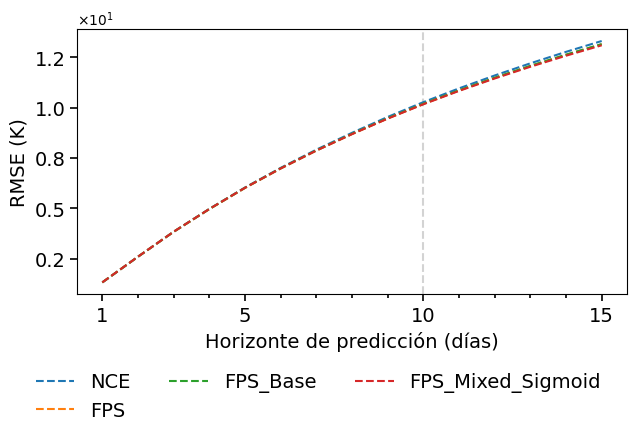

In [24]:
other_params = ['sea_surface_foundation_temperature']
fig, axes = fig, ax =plt.subplots(
    figsize=(6.25, 3.5),
    constrained_layout=True
)
axes = np.array([ax])
plot_rmse_global_line(other_params, fig, axes, lead_times, rmse_dict=rmse_dict, share_labels=False)
plt.show()

title = "rmse_global_line_comparison.pdf"
save_path = os.path.join(save_dir)
if to_save:
    fig.savefig(os.path.join(save_path, "rmse_global_line.pdf"), dpi=300, bbox_inches='tight')


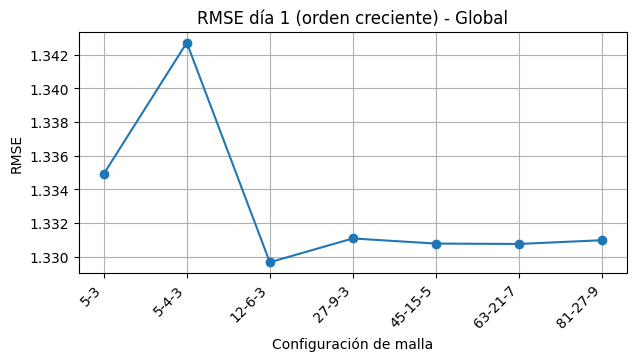

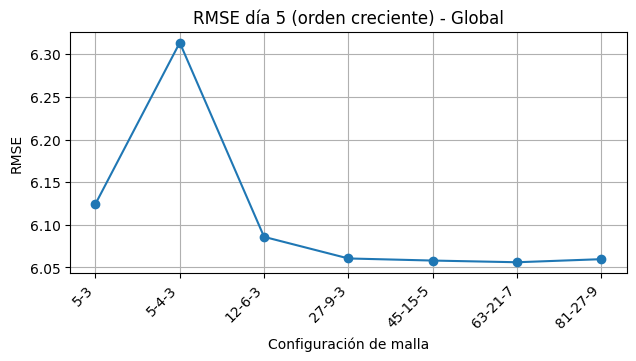

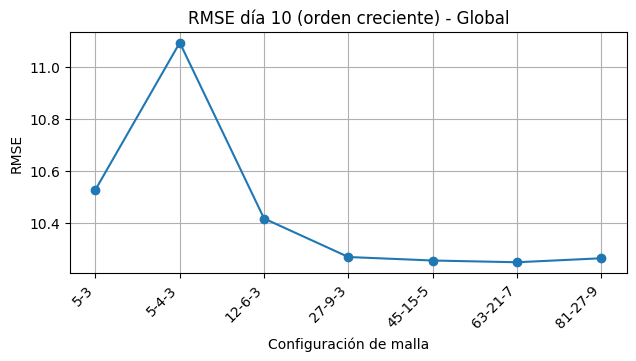

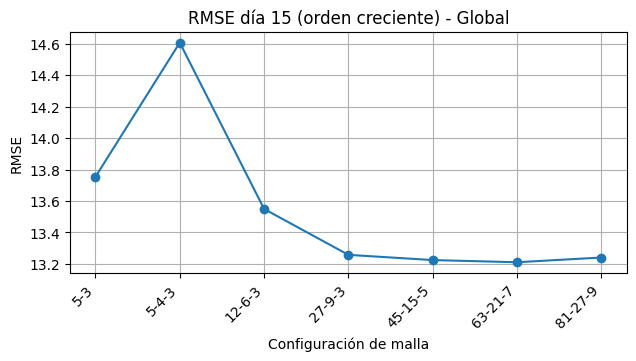

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import os

days = [1, 5, 10, 15]

def parse_resolution(res_string):
    return [int(part) for part in res_string.split("_")]

for day in days:
    rmse_day = {
        "81_27_9": uniform_nce_81_27_9_model_rmse[day-1],
        "63_21_7": uniform_nce_63_21_7_model_rmse[day-1],
        "45_15_5": uniform_nce_45_15_5_model_rmse[day-1],
        "27_9_3":  uniform_nce_27_9_3_model_rmse[day-1],
        "12_6_3": uniform_nce_12_6_3_model_rmse[day-1],
        "5_4_3":  uniform_nce_5_4_3_model_rmse[day-1],
        "5_3":    uniform_nce_5_3_model_rmse[day-1],
    }

    # Ordenar por resolución ascendente
    sorted_labels = sorted(rmse_day.keys(), key=parse_resolution)

    rmse_sorted = [rmse_day[label] for label in sorted_labels]
    x = np.arange(len(sorted_labels))

    fig, ax = plt.subplots(figsize=(6.25, 3.5), constrained_layout=True)
    ax.plot(x, rmse_sorted, marker='o', linestyle='-')
    ax.set_xticks(x)

    # Crear etiquetas seguras para el eje x
    labels = ['-'.join(map(str, parse_resolution(label))) for label in sorted_labels]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Configuración de malla')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE día {day} (orden creciente) - Global')
    ax.grid(True)

    plt.show()

    if to_save:
        filename = f'RMSE_dia_{day}_global.pdf'
        fig.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight', format='pdf')


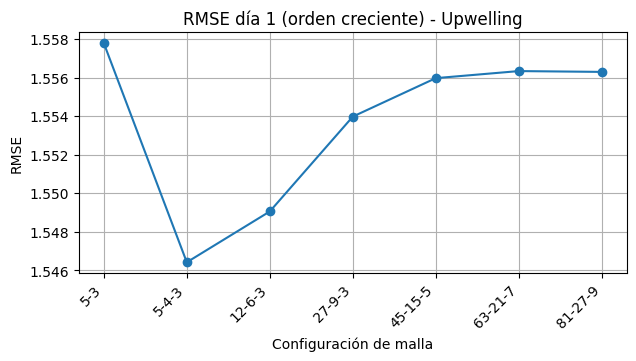

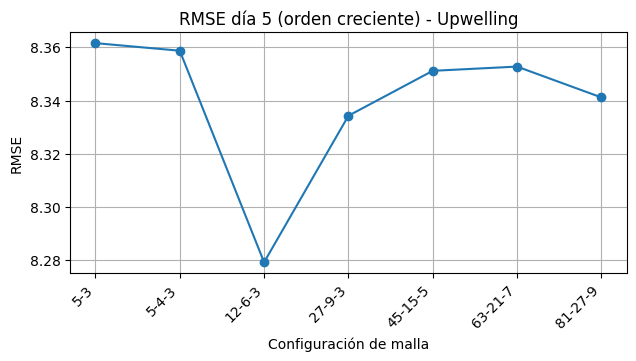

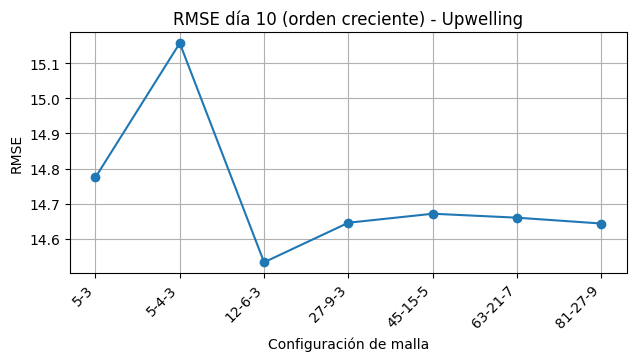

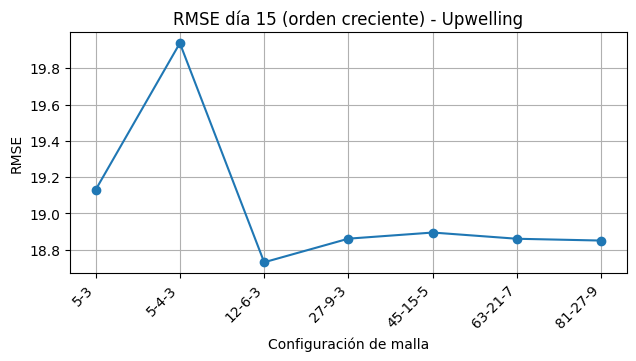

In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt

days = [1, 5, 10, 15]

def extract_resolution(label):
    parts = label.split("_")
    resolution = []
    for part in parts:
        if part.isdigit():
            resolution.append(int(part))
    return resolution

for day in days:
    rmse_day = {
        "uniform_nce_81_27_9": uniform_nce_81_27_9_pred_rmse_upw[day-1],
        "uniform_nce_63_21_7": uniform_nce_63_21_7_pred_rmse_upw[day-1],
        "uniform_nce_45_15_5": uniform_nce_45_15_5_pred_rmse_upw[day-1],
        "uniform_nce_27_9_3":  uniform_nce_27_9_3_pred_rmse_upw[day-1],
        "uniform_nce_12_6_3": uniform_nce_12_6_3_pred_rmse_upw[day-1],
        "uniform_nce_5_4_3":  uniform_nce_5_4_3_pred_rmse_upw[day-1],
        "uniform_nce_5_3":    uniform_nce_5_3_pred_rmse_upw[day-1],
    }

    # Ordenar claves de menor a mayor resolución
    sorted_labels = sorted(rmse_day.keys(), key=lambda x: extract_resolution(x))

    rmse_sorted = [rmse_day[label] for label in sorted_labels]
    x = np.arange(len(sorted_labels))

    fig, ax = plt.subplots(figsize=(6.25, 3.5), constrained_layout=True)
    ax.plot(x, rmse_sorted, marker='o', linestyle='-')
    ax.set_xticks(x)

    # Crear etiquetas a partir de la parte de resolución de cada nombre
    labels = ['-'.join(map(str, extract_resolution(label))) for label in sorted_labels]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Configuración de malla')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE día {day} (orden creciente) - Upwelling')
    ax.grid(True)

    plt.show()

    if to_save:
        filename = f'RMSE_dia_{day}_upwelling.pdf'
        fig.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight', format='pdf')


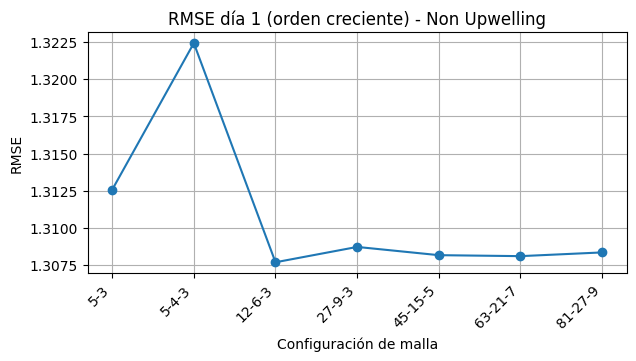

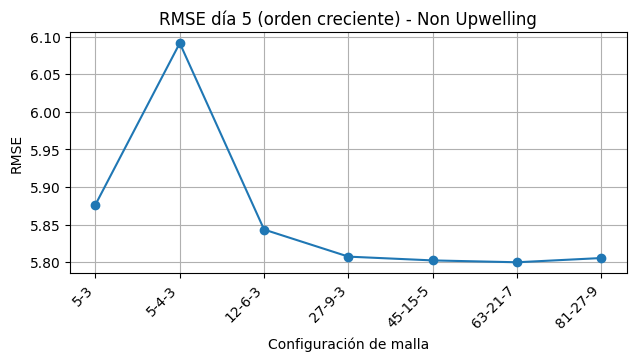

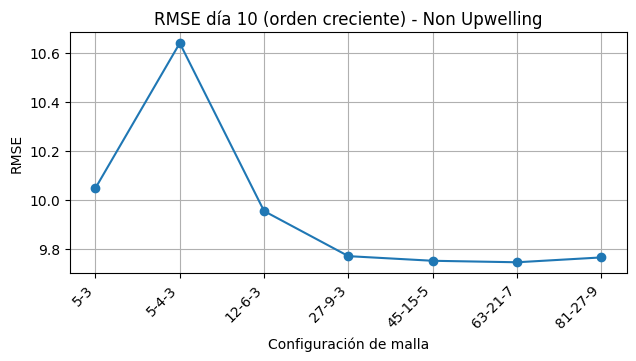

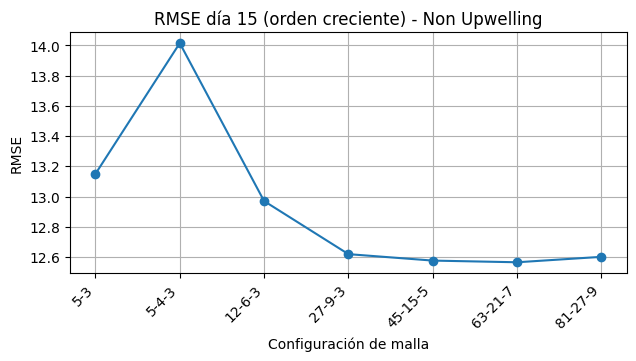

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

days = [1, 5, 10, 15]

def parse_resolution(res_string):
    # Extrae la parte de la resolución del nombre del modelo
    return [int(p) for p in res_string.split("_") if p.isdigit()]

for day in days:
    rmse_day = {
        "uniform_nce_81_27_9": uniform_nce_81_27_9_pred_rmse_non_upw[day-1],
        "uniform_nce_63_21_7": uniform_nce_63_21_7_pred_rmse_non_upw[day-1],
        "uniform_nce_45_15_5": uniform_nce_45_15_5_pred_rmse_non_upw[day-1],
        "uniform_nce_27_9_3":  uniform_nce_27_9_3_pred_rmse_non_upw[day-1],
        "uniform_nce_12_6_3":  uniform_nce_12_6_3_pred_rmse_non_upw[day-1],
        "uniform_nce_5_4_3":   uniform_nce_5_4_3_pred_rmse_non_upw[day-1],
        "uniform_nce_5_3":     uniform_nce_5_3_pred_rmse_non_upw[day-1],
    }

    sorted_labels = sorted(rmse_day.keys(), key=parse_resolution)

    rmse_sorted = [rmse_day[label] for label in sorted_labels]
    x = np.arange(len(sorted_labels))

    fig, ax = plt.subplots(figsize=(6.25, 3.5), constrained_layout=True)
    ax.plot(x, rmse_sorted, marker='o', linestyle='-')
    ax.set_xticks(x)

    # Crear etiquetas limpias del tipo 81-27-9
    labels = ['-'.join(map(str, parse_resolution(label))) for label in sorted_labels]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    ax.set_xlabel('Configuración de malla')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE día {day} (orden creciente) - Non Upwelling')
    ax.grid(True)

    plt.show()

    if to_save:
        filename = f'RMSE_dia_{day}_non_upwelling.pdf'
        fig.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight', format='pdf')


### Plot of RMSE line of upwelling vs no upwelling


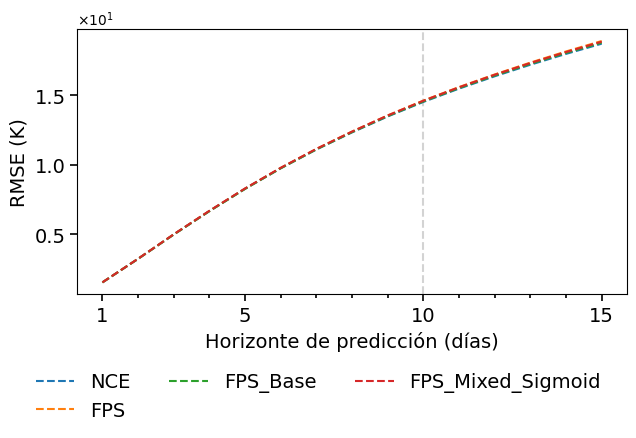

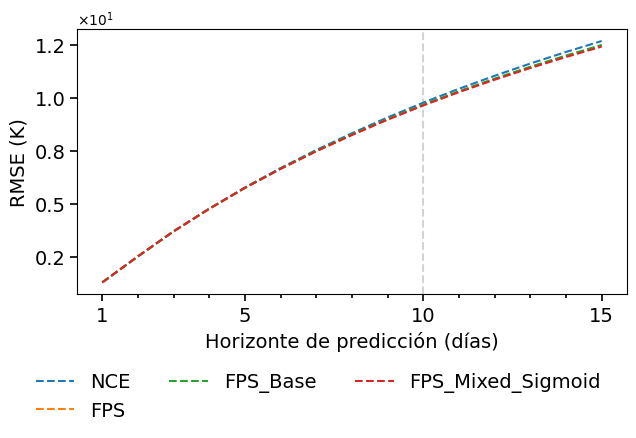

In [25]:
import matplotlib.pyplot as plt

# ------------------------------------------------
# Primer gráfico: Upwelling Zone
fig1, ax1 = plt.subplots(
    nrows=1, ncols=1,
    figsize=(6.25, 3.5),
    constrained_layout=True
)

ax1 = np.array([ax1])
plot_rmse_global_line(
    other_params,
    fig1,
    ax1,
    lead_times,
    rmse_dict=rmse_upw_dict,
    share_labels=False
)
#ax1.set_title("Upwelling Zone", fontsize=14)

fig2, ax2 = plt.subplots(
    nrows=1, ncols=1,
    figsize=(6.25, 3.5),
    constrained_layout=True
)
ax2 = np.array([ax2])
plot_rmse_global_line(
    other_params,
    fig2,
    ax2,
    lead_times,
    rmse_dict=rmse_non_upw_dict,
    share_labels=False
)
#ax2.set_title("Non-Upwelling Zone", fontsize=14)

plt.show()
if to_save:
    title = "rmse_upwelling_zone_line_comparison_exp3.pdf"
    save_path = os.path.join(save_dir)
    fig1.savefig(os.path.join(save_dir, title), dpi=300, bbox_inches='tight')
    title = "rmse_non_upwelling_zone_line_comparison_exp3.pdf"
    save_path = os.path.join(save_dir)
    fig2.savefig(os.path.join(save_dir, title), dpi=300, bbox_inches='tight')


### Plot of the table of metrics values for all models

In [40]:
predictions_dict = {
    #"U-malla": uniform_predictions,
    #"B-malla": bathymetry_predictions,
    #"R-malla": random_predictions
    #"nce_81_27_9": uniform_nce_81_27_9_predictions,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_predictions,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_predictions,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_predictions,
    #"ce_81_27_9": uniform_ce_81_27_9_predictions, 
    #"uniform_nce_12_6_3": uniform_nce_12_6_3_predictions, 
    #"uniform_nce_5_4_3": uniform_nce_5_4_3_predictions,
    #"uniform_nce_5_3": uniform_nce_5_3_predictions,
    #"fps_27_9_3": fps_27_9_3_predictions,
    #"fps_12_6_3": fps_12_6_3_predictions,
    #"fps_5_4_3": fps_5_4_3_predictions,
    "nce": nce_27_9_predictions,
    "fps": fps_27_9_predictions,
    "fps_base": fps_27_9_weighted_base_predictions,
    "fps_mixed_sigmoid": fps_weighted_mixed_sigmoid_27_9_predictions,
}

predictions_upw_dict = {
    #"uniform": unif_preds_upw,
    #"bathymetry": bath_preds_upw,
    #"random": random_preds_upw
    #"uniform_nce_81_27_9": uniform_nce_81_27_9_preds_upw,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_preds_upw,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_preds_upw,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_preds_upw,
    #"uniform_ce_81_27_9": uniform_ce_81_27_9_preds_upw, 
    #"uniform_nce_12_6_3": uniform_nce_12_6_3_preds_upw, 
    #"uniform_nce_5_4_3": uniform_nce_5_4_3_preds_upw,
    #"uniform_nce_5_3": uniform_nce_5_3_preds_upw,
    #"fps_27_9_3": fps_27_9_3_preds_upw,
    #"fps_12_6_3": fps_12_6_3_preds_upw,
    #"fps_5_4_3": fps_5_4_3_preds_upw,
    "nce_27_9": nce_27_9_preds_upw,
    "fps_27_9": fps_27_9_preds_upw,
    "fps_27_9_weighted_base": fps_27_9_weighted_base_preds_upw,
    "fps_27_9_weighted_mixed_sigmoid": fps_weighted_mixed_sigmoid_27_9_preds_upw,
}

predictions_non_upw_dict = {
    #"uniform": unif_preds_non_upw,
    #"bathymetry": bath_preds_non_upw,
    #"random": random_preds_non_upw
    #"uniform_nce_81_27_9": uniform_nce_81_27_9_preds_non_upw,
    #"uniform_nce_63_21_7": uniform_nce_63_21_7_preds_non_upw,
    #"uniform_nce_45_15_5": uniform_nce_45_15_5_preds_non_upw,
    #"uniform_nce_27_9_3": uniform_nce_27_9_3_preds_non_upw,
    #"uniform_ce_81_27_9": uniform_ce_81_27_9_preds_non_upw
    #"uniform_nce_12_6_3": uniform_nce_12_6_3_preds_non_upw,
    #"uniform_nce_5_4_3": uniform_nce_5_4_3_preds_non_upw,
    #"uniform_nce_5_3": uniform_nce_5_3_preds_non_upw,
    #"fps_27_9_3": fps_27_9_3_preds_non_upw,
    #"fps_12_6_3": fps_12_6_3_preds_non_upw,
    #"fps_5_4_3": fps_5_4_3_preds_non_upw,
    "nce_27_9": nce_27_9_preds_non_upw,
    "fps_27_9": fps_27_9_preds_non_upw,
    "fps_27_9_weighted_base": fps_27_9_weighted_base_preds_non_upw,
    "fps_27_9_weighted_mixed_sigmoid": fps_weighted_mixed_sigmoid_27_9_preds_non_upw,
}

In [27]:
import numpy as np

def chunked_rmse(p: np.ndarray,
                 t: np.ndarray,
                 mask: np.ndarray,
                 chunk_size: int = 1_000_000) -> float:
    """
    Compute RMSE(p, t) over the entries where mask is True,
    processing at most `chunk_size` elements at a time.
    """
    total_sq = 0.0
    total_count = 0

    # Flatten everything once
    p_flat = p.ravel()
    t_flat = t.ravel()
    mask_flat = mask.ravel()

    n = p_flat.shape[0]
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        m = mask_flat[start:end]
        if not m.any():
            continue
        # Only touch the valid slice
        p_slice = p_flat[start:end][m]
        t_slice = t_flat[start:end][m]
        diff = p_slice - t_slice
        total_sq += np.sum(diff * diff)
        total_count += diff.size

    if total_count == 0:
        return np.nan
    return np.sqrt(total_sq / total_count)



def chunked_rmse_pairs(p_vals: np.ndarray,
                       t_vals: np.ndarray,
                       chunk_size: int = 1_000_000) -> float:
    total_sq = 0.0
    N = p_vals.size
    for start in range(0, N, chunk_size):
        end  = min(start + chunk_size, N)
        diff = p_vals[start:end] - t_vals[start:end]
        total_sq += np.sum(diff * diff)
    return np.sqrt(total_sq / N)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def generate_metrics_table_by_chosen_day(params,
                           predictions_dict: dict,
                           targets: np.ndarray,
                           sea_mask_bool: np.ndarray,
                           param_indices: dict,
                           t: int) -> pd.DataFrame:
    """
    Genera un DataFrame con RMSE, Bias y ACC para cada modelo,
    usando únicamente los datos del día t (0-based).
    """
    idx_params = [param_indices[p] for p in params]
    models = list(predictions_dict.keys())
    metrics = []

    for m in models:
        preds = predictions_dict[m]
        # extraer solo el día t
        # pred_dim puede ser (ns, nd, npt, nvar) o (ns, nd, npt)
        if preds.ndim == 4:
            preds_day = preds[:, t, :, :]
            targs_day = targets[:, t, :, :]
        elif preds.ndim == 3:
            preds_day = preds[:, t, :]
            targs_day = targets[:, t, :]
        else:
            raise ValueError(f"Predictions for model {m} deben tener 3 o 4 dimensiones")

        ns = preds_day.shape[0]
        # aplanar y seleccionar sólo los parámetros indicados
        flat_p = preds_day.reshape(-1, preds_day.shape[-1])[:, idx_params].ravel()
        flat_t = targs_day.reshape(-1, targs_day.shape[-1])[:, idx_params].ravel()

        # máscara espacial repetida por cada muestra
        spatial_mask = np.tile(sea_mask_bool, ns)
        mask = np.tile(spatial_mask, len(idx_params))

        p_vals = flat_p[mask]
        t_vals = flat_t[mask]

        # métricas
        rmse = chunked_rmse_pairs(p_vals, t_vals)
        bias = np.nanmean(p_vals - t_vals)
        if p_vals.size > 1 and np.nanstd(p_vals) > 0 and np.nanstd(t_vals) > 0:
            acc = accuracy_score(np.round(t_vals), np.round(p_vals))
        else:
            acc = np.nan

        metrics.append([rmse, bias, acc])

    df = pd.DataFrame(metrics,
                      index=models,
                      columns=['RMSE', 'Bias', 'Accuracy'])
    df.index.name = "Model"
    return df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def generate_metrics_table(params,
                           predictions_dict: dict,
                           targets: np.ndarray,
                           sea_mask_bool: np.ndarray,
                           param_indices: dict,
                            ) -> pd.DataFrame:
    """
    Generate a DataFrame with RMSE, Bias and ACC metrics for each model.
    The metrics are calculated for the specified parameters and averaged

    """
    idx_params = [param_indices[p] for p in params]
    models = list(predictions_dict.keys())
    metrics = []

    for m in models:
        preds = predictions_dict[m]
        flat_preds = preds.reshape(-1, preds.shape[-1])[:, idx_params]
        flat_targs = targets.reshape(-1, targets.shape[-1])[:, idx_params]

        p_all = flat_preds.ravel()
        t_all = flat_targs.ravel()

        ns, nd, npt = preds.shape[0], preds.shape[1], preds.shape[2]
        spatial_mask = np.tile(sea_mask_bool, ns * nd)
        mask_full = np.tile(spatial_mask, len(idx_params))

        p_vals = p_all[mask_full]
        t_vals = t_all[mask_full]

        rmse = chunked_rmse_pairs(p_vals, t_vals)
        bias = np.nanmean(p_vals - t_vals)
        if p_vals.size > 1 and np.nanstd(p_vals) > 0 and np.nanstd(t_vals) > 0:
            #acc = np.corrcoef(p_vals, t_vals)[0,1]
            acc = accuracy_score(np.round(t_vals), np.round(p_vals))
        else:
            print(f"Warning: Not enough data to calculate ACC for {m}.")
            acc = np.nan

        metrics.append([rmse, bias, acc])

    df = pd.DataFrame(metrics,
                      index=models,
                      columns=['RMSE', 'Bias', 'Accuracy'])
    df.index.name = "Model"
    return df


def plot_metrics_table(df_metrics, fontsize=12, to_save = False, title  = "metrics_table.svg"):
    """
    Draws a table with the metrics for each model.
    """
    n_models = len(df_metrics)
    fig, ax = plt.subplots(figsize=(6, 0.5*n_models + 1))
    ax.axis('off')

    table = ax.table(
        cellText=np.round(df_metrics.values, 3),
        colLabels=df_metrics.columns,
        rowLabels=df_metrics.index,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1, 1.5)

    if to_save:
        plt.savefig(title, bbox_inches='tight', dpi=300, format='pdf')
    else:
        plt.show()


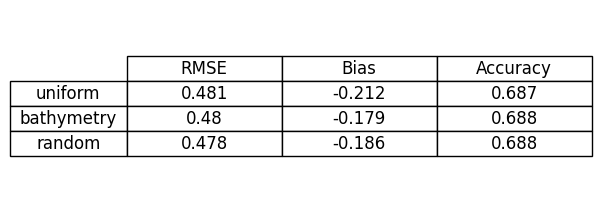

In [ ]:
param_indices = {param: idx for idx, param in enumerate(constants.EXP_PARAM_NAMES_SHORT)}

df_metrics= generate_metrics_table(
    other_params,
    predictions_dict,
    targets,
    sea_mask_bool.flatten() if sea_mask_bool.ndim > 1 else sea_mask_bool,
    param_indices
)

title = "global_metrics_table_all_days.svg"
save_path = os.path.join(save_dir, title)

plot_metrics_table(df_metrics, fontsize=12, to_save = to_save, title = save_path)

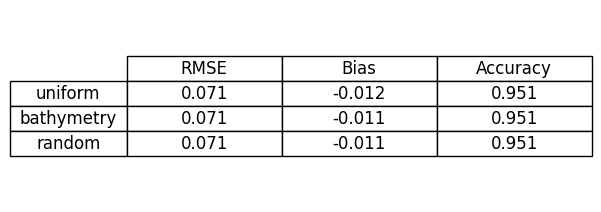

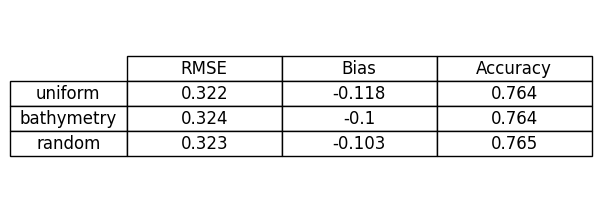

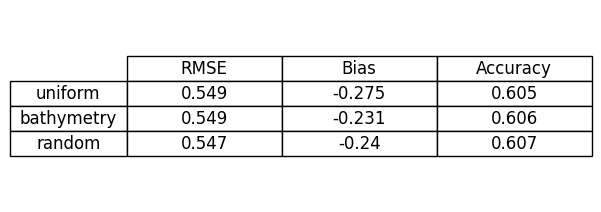

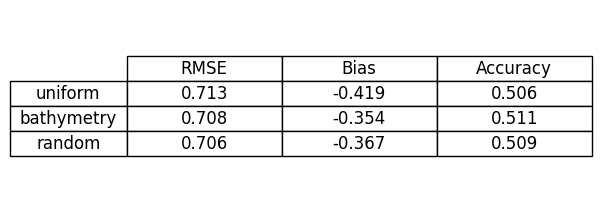

In [ ]:
days_to_process = [0, 4, 9, 14]

for t in days_to_process:
    df_metrics = generate_metrics_table_by_chosen_day(
        other_params,
        predictions_dict,
        targets,
        sea_mask_bool.flatten() if sea_mask_bool.ndim > 1 else sea_mask_bool,
        param_indices,
        t=t
    )

    title = f"global_metrics_table_day_{t}.svg"
    save_path = os.path.join(save_dir, title)
    plot_metrics_table(df_metrics, fontsize=12, to_save = to_save, title= save_path)

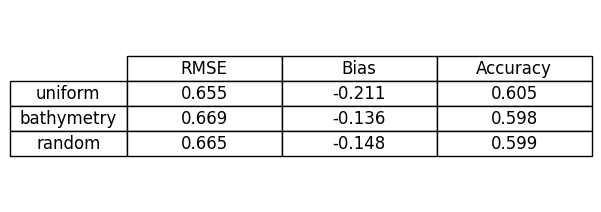

In [ ]:
uniform_preds_upw = extract_zone_data(uniform_predictions, upwelling_flat)  # (349,15,n_upw,1)
targs_upw = extract_zone_data(targets, upwelling_flat)

n_upw = uniform_preds_upw.shape[2]
sea_mask_bool_upw = np.ones(n_upw, dtype=bool)

param_indices = {
    param: idx
    for idx, param in enumerate(constants.EXP_PARAM_NAMES_SHORT)
}

df_metrics_upw = generate_metrics_table(
    other_params,
    predictions_upw_dict,
    targs_upw,
    sea_mask_bool_upw,
    param_indices
)

title = "upwelling_zone_metrics_table_all_days.svg"
save_path = os.path.join(save_dir, title)
plot_metrics_table(df_metrics_upw, fontsize=12, to_save = to_save, title = save_path)


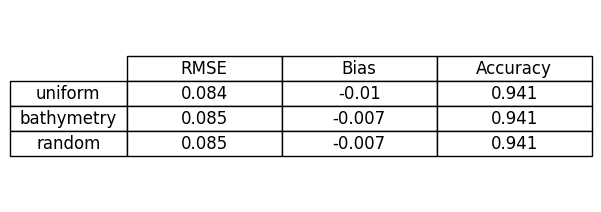

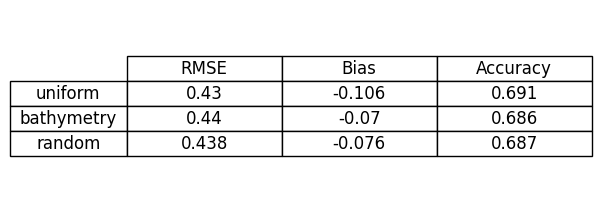

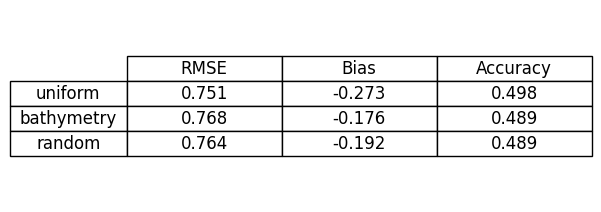

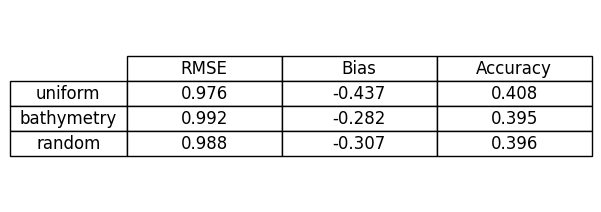

In [ ]:
days_to_process = [0, 4, 9, 14]

for t in days_to_process:
    df_metrics = generate_metrics_table_by_chosen_day(
        other_params,
        predictions_upw_dict,
        targs_upw,
        sea_mask_bool_upw,
        param_indices,
        t=t
    )

    title = f"upwelling_zone_metrics_table_day_{t}.svg"
    save_path = os.path.join(save_dir, title)
    plot_metrics_table(df_metrics, fontsize=12, to_save = to_save, title= save_path)

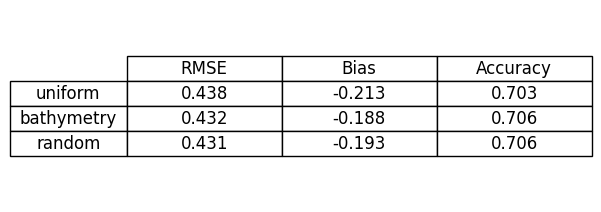

In [ ]:
uniform_preds_non_upw = extract_zone_data(uniform_predictions, non_upwelling_flat)
targs_non_upw = extract_zone_data(targets, non_upwelling_flat)

n_non_upw = uniform_preds_non_upw.shape[2]
sea_mask_bool_non_upw = np.ones(n_non_upw, dtype=bool)

param_indices = {
    param: idx
    for idx, param in enumerate(constants.EXP_PARAM_NAMES_SHORT)
}

df_metrics_non_upw = generate_metrics_table(
    other_params,
    predictions_non_upw_dict,
    targs_non_upw,
    sea_mask_bool_non_upw,
    param_indices
)

title = "non_upwelling_zone_metrics_table_all_days.svg"
save_path = os.path.join(save_dir, title)
plot_metrics_table(df_metrics_non_upw, fontsize=12, to_save = to_save, title = save_path)


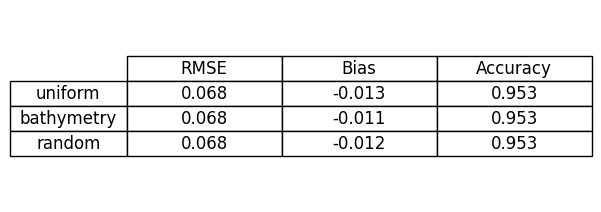

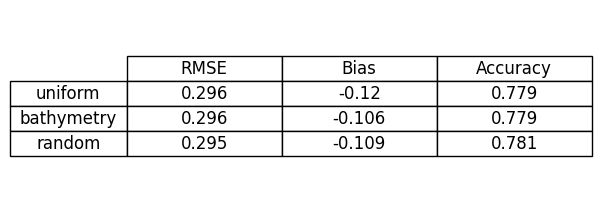

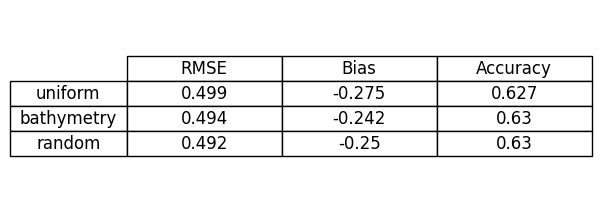

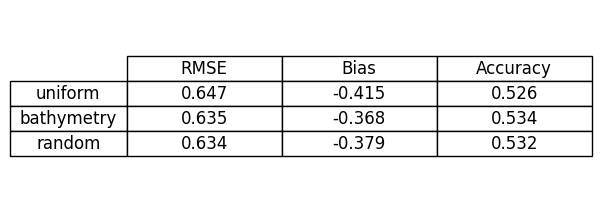

In [ ]:
days_to_process = [0, 4, 9, 14]

for t in days_to_process:
    df_metrics = generate_metrics_table_by_chosen_day(
        other_params,
        predictions_non_upw_dict,
        targs_non_upw,
        sea_mask_bool_non_upw,
        param_indices,
        t=t
    )

    title = f"non_upwelling_zone_metrics_table_day_{t}.svg"
    save_path = os.path.join(save_dir, title)
    plot_metrics_table(df_metrics, fontsize=12, to_save = to_save, title= save_path)

In [28]:
param_indices = {param: idx for idx, param in enumerate(constants.EXP_PARAM_NAMES_SHORT)}


def calculate_rmse(params, timestep, predictions, targets=targets):
    param_indices_list = [param_indices[param] for param in params]
    rmse_spatial = np.zeros((predictions.shape[2],))
    for param_idx in param_indices_list:
        diff = (predictions[:, timestep, :, param_idx] - targets[:, timestep, :, param_idx])
        diff_masked = diff * sea_mask_bool[:, param_idx]
        rmse = np.sqrt(np.nanmean(diff_masked**2, axis=0))
        rmse_spatial += rmse
    rmse_spatial /= len(param_indices_list)
    return rmse_spatial



def plot_rmse(params, param_name, predictions, targets=targets):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7), constrained_layout=True)
    
    timesteps = [0, 4, 9, 14]
    all_data = []
    for timestep in timesteps:
        rmse_spatial = calculate_rmse(params, timestep, predictions, targets)
        all_data.append(rmse_spatial)

    vmin_rmse = 0
    vmax_rmse = max(data.max() for data in all_data)
    print(param_name, vmin_rmse, vmax_rmse)
    
    if param_name == 'mlotst':
        vmax_rmse = 35
    
    cmap = plt.get_cmap('OrRd')
    cmap.set_bad(color=(1, 1, 1, 0))

    for i, timestep in enumerate(timesteps):
        rmse_spatial = calculate_rmse(params, timestep)

        full_rmse = np.full(full_mask[:, 0].shape, np.nan)
        full_rmse[full_mask[:, 0].astype(bool)] = rmse_spatial
        data_grid_rmse = full_rmse.reshape(*constants.GRID_SHAPE)
        
        ax = axes[i // 2, i % 2]
        im_rmse = ax.imshow(data_grid_rmse, origin='lower', vmin=vmin_rmse, vmax=vmax_rmse, cmap=cmap)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_title(f'{timestep+1} d', fontsize=16)

    if param_name == 'mlotst':
        cbar_rmse = fig.colorbar(im_rmse, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.02, aspect=40, extend='max')
    else:
        cbar_rmse = fig.colorbar(im_rmse, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.02, aspect=40)
    unit_idx = [param_indices[param] for param in params][0]
    cbar_rmse.set_label(constants.EXP_PARAM_UNITS[unit_idx], fontsize=12)
    cbar_rmse.ax.tick_params(labelsize=12)


    plt.show()



In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rmse_models(params,
                     predictions_dict: dict,
                     targets: np.ndarray,
                     sea_mask_bool: np.ndarray,
                     param_indices: dict,
                     full_mask: np.ndarray,
                     grid_shape: tuple,
                     constants,
                     CustomScalarFormatter,
                     cmap_name: str='OrRd', to_save: bool=False, title: str="spatial_rmse_models.svg"):
    """
    Para cada modelo en predictions_dict, dibuja el RMSE espacial
    (promediado sobre params) en los días 1,5,10,15, y pone el
    nombre del modelo a la izquierda de cada fila.
    """
    models = list(predictions_dict.keys())
    timesteps = [0, 4, 9, 14]
    n_models = len(models)
    n_times = len(timesteps)

    # 1) Calcular vmax global
    all_max = 0.0
    for m in models:
        preds = predictions_dict[m]
        for t in timesteps:
            rmse_acc = []
            for p in params:
                pi = param_indices[p]
                diff = preds[:, t, :, pi] - targets[:, t, :, pi]
                dm = diff * sea_mask_bool[:, pi]
                rmse_acc.append(np.sqrt(np.nanmean(dm**2, axis=0)))
            rmse_mean = np.mean(rmse_acc, axis=0)
            all_max = max(all_max, np.nanmax(rmse_mean))
    vmin, vmax = 0.0, all_max

    # 2) Crear figura y ejes
    fig, axes = plt.subplots(
        nrows=n_models, ncols=n_times,
        figsize=(3*n_times, 3*n_models),
        constrained_layout=True
    )
    axes = np.atleast_2d(axes)
    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad(color=(1,1,1,0))

    # 3) Dibujar cada subplot
    for i, model in enumerate(models):
        # Anotar el nombre del modelo al inicio de la fila
        axes[i, 0].set_ylabel(
            model,
            rotation=0,
            fontsize=12,
            labelpad=40,
            va='center'
        )
        preds = predictions_dict[model]
        for j, t in enumerate(timesteps):
            rmse_acc = []
            for p in params:
                pi = param_indices[p]
                diff = preds[:, t, :, pi] - targets[:, t, :, pi]
                dm = diff * sea_mask_bool[:, pi]
                rmse_acc.append(np.sqrt(np.nanmean(dm**2, axis=0)))
            rmse_mean = np.mean(rmse_acc, axis=0)

            full = np.full(full_mask.shape[0], np.nan)
            full[full_mask.flatten().astype(bool)] = rmse_mean
            grid = full.reshape(grid_shape)

            ax = axes[i, j]
            im = ax.imshow(
                grid,
                origin='lower',
                vmin=vmin, vmax=vmax,
                cmap=cmap, 
                rasterized=True,
            )
            ax.set_xticks([]); ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_title(f"{t+1} d", fontsize=12)

    # 4) Colorbar compartida
    cbar = fig.colorbar(
        im,
        ax=axes.ravel().tolist(),
        orientation='horizontal',
        fraction=0.05,   # antes 0.02, aumenta grosor
        pad=0.08,        # separación del panel
        aspect=30,
        extend='max'
    )
    unit = constants.EXP_PARAM_UNITS[param_indices[params[0]]]
    cbar.set_label(f"RMSE ({unit})", fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    if to_save:
        plt.savefig(title, dpi=300, bbox_inches='tight', format='pdf')
    else:
        plt.show()


In [ ]:
#rmse = calculate_rmse(['sea_surface_foundation_temperature'], 0, predictions=uniform_predictions, targets=targets)
#print(rmse.shape)

### Plot RMSE spatial of different models (enviar)

In [41]:
#predictions_dict = {
#    "uniform": uniform_predictions
#}

In [42]:
param_indices = {param: idx for idx, param in enumerate(constants.EXP_PARAM_NAMES_SHORT)}

In [43]:
title = "rmse_spatial_all_exp3.pdf"
save_path = os.path.join(save_dir, title)

KeyboardInterrupt: 

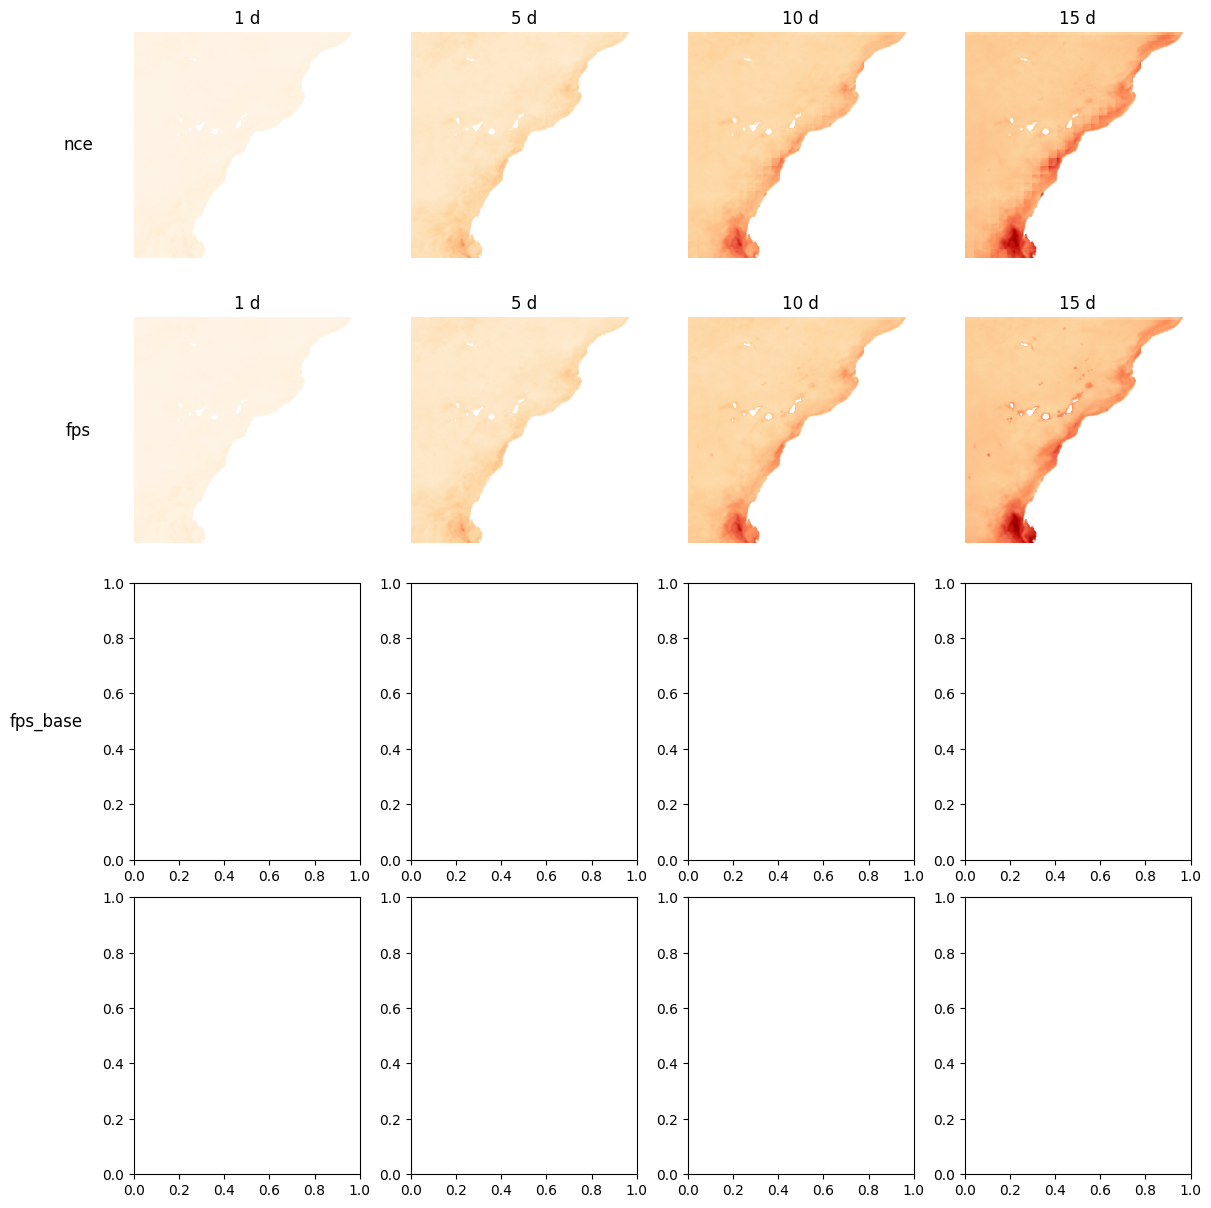

In [44]:
plot_rmse_models(
    ['sea_surface_foundation_temperature'],
    predictions_dict,
    targets,
    sea_mask_bool,
    param_indices,
    full_mask,
    constants.GRID_SHAPE,
    constants,
    CustomScalarFormatter, 
    to_save = to_save, 
    title = save_path
)

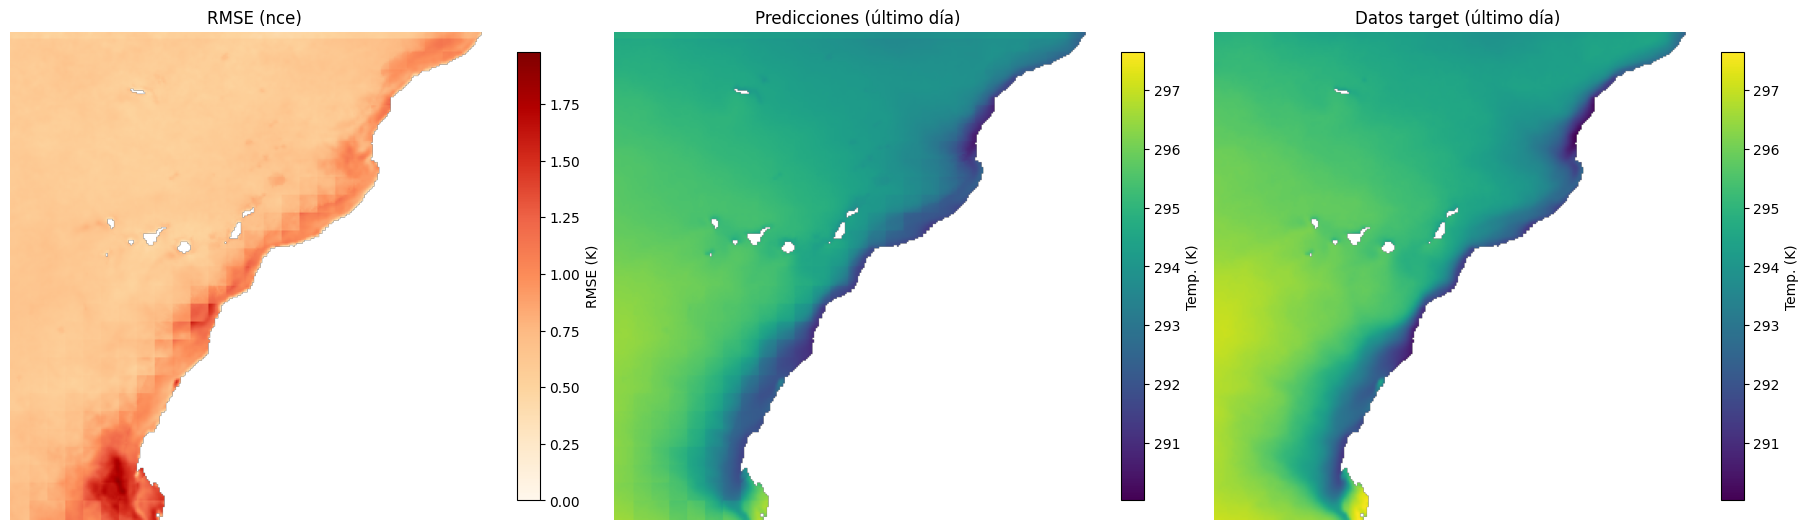

Saved figure: figures/metrics_predictions/tfg_gabriel\spatial_rmse_pred_target_nce.pdf


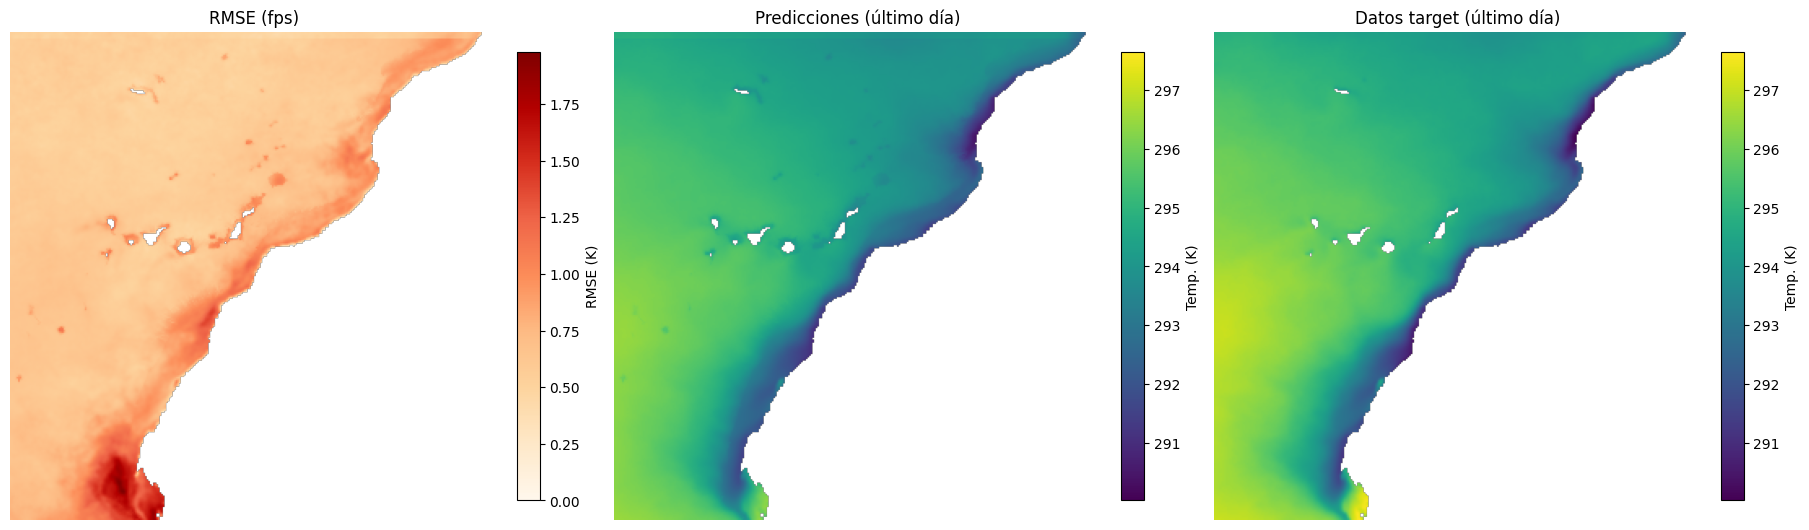

Saved figure: figures/metrics_predictions/tfg_gabriel\spatial_rmse_pred_target_fps.pdf


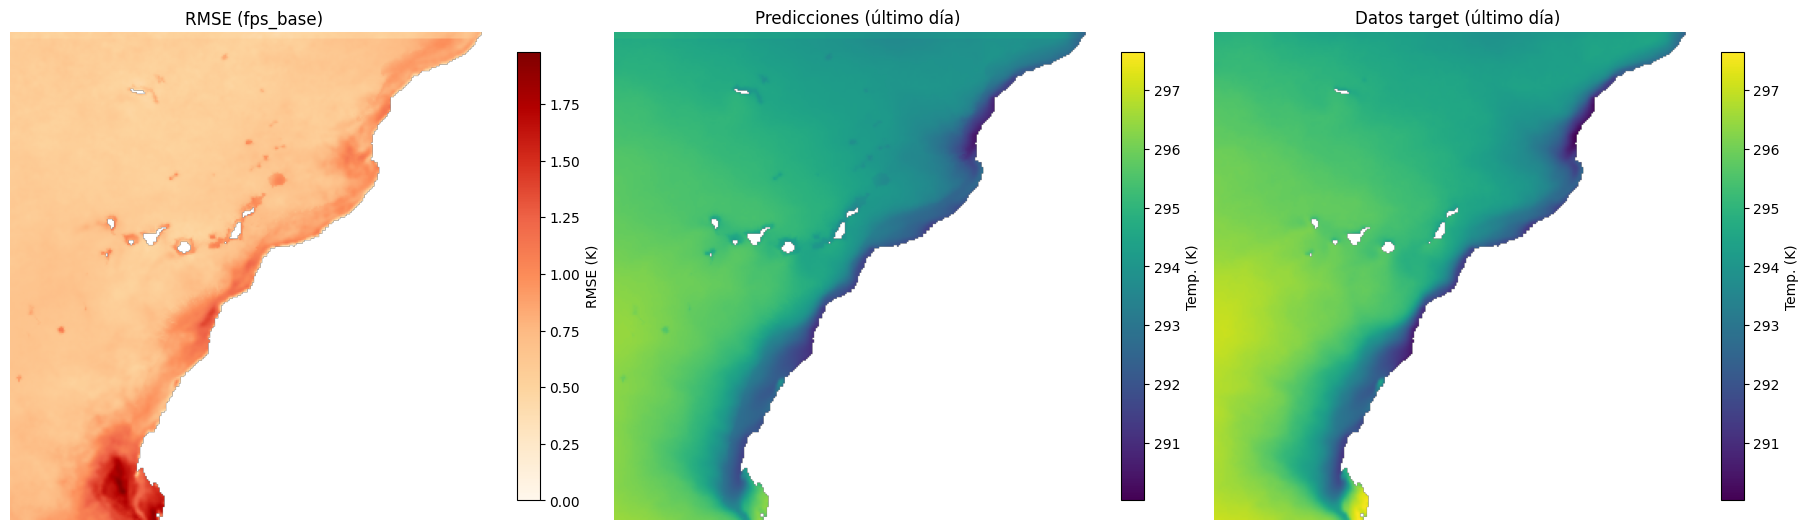

Saved figure: figures/metrics_predictions/tfg_gabriel\spatial_rmse_pred_target_fps_base.pdf


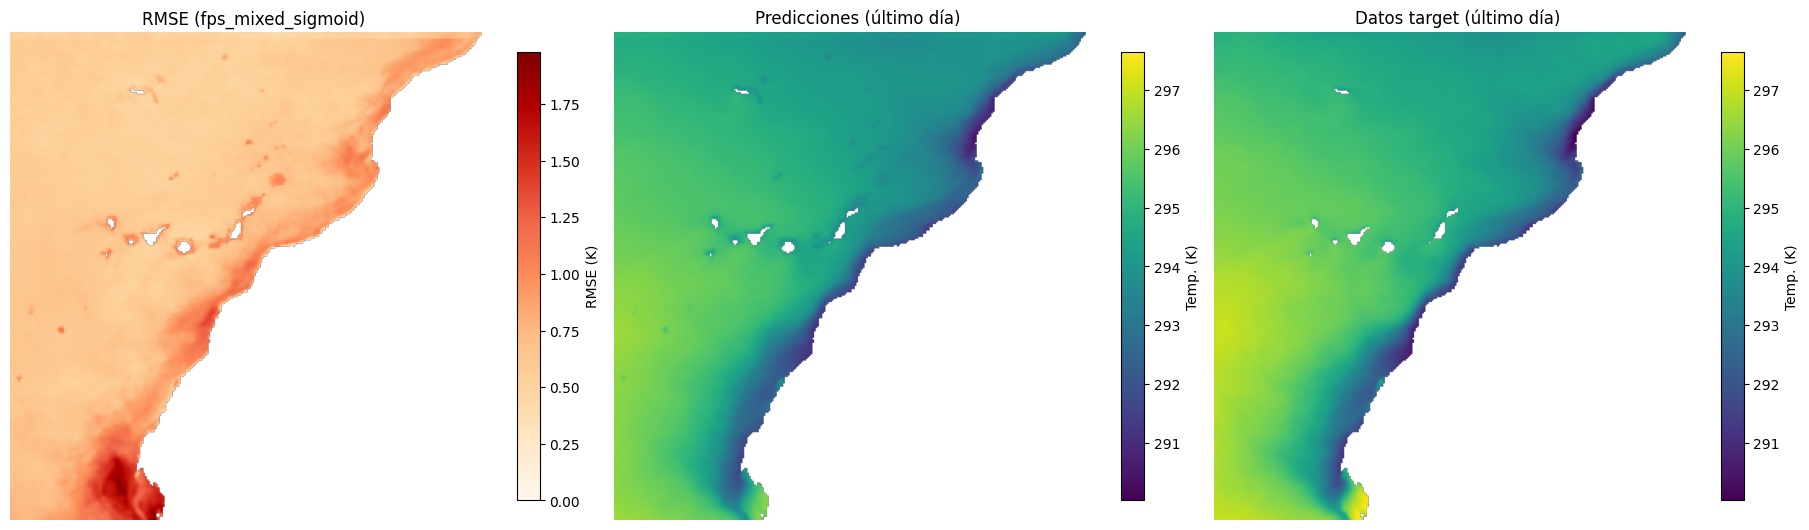

Saved figure: figures/metrics_predictions/tfg_gabriel\spatial_rmse_pred_target_fps_mixed_sigmoid.pdf


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def generate_rmse_grid(predictions, targets, full_mask):
    rmse = calculate_rmse(
        ['sea_surface_foundation_temperature'],
        14,
        predictions=predictions,
        targets=targets
    )
    full_rmse = np.full(full_mask[:, 0].shape, np.nan)
    full_rmse[full_mask[:, 0].astype(bool)] = rmse
    return full_rmse.reshape(*constants.GRID_SHAPE)

def generate_value_grid(values, full_mask):
    full = np.full(full_mask[:, 0].shape, np.nan)
    full[full_mask[:, 0].astype(bool)] = values
    return full.reshape(*constants.GRID_SHAPE)


# ------------------------------------------------
# 1) Precomputar todas las grillas y guardarlas
# ------------------------------------------------
all_rmse = {}
all_pred = {}
all_targ = {}

for model, preds in predictions_dict.items():
    # RMSE
    grid_rmse = generate_rmse_grid(preds, targets, full_mask)
    all_rmse[model] = grid_rmse

    # Predicción: media último día
    last_pred = preds[:, 14, :, 0]
    mean_last_pred = np.nanmean(last_pred, axis=0)
    all_pred[model] = generate_value_grid(mean_last_pred, full_mask)

    # Target: media último día
    last_targ = targets[:, 14, :, 0]
    mean_last_targ = np.nanmean(last_targ, axis=0)
    all_targ[model] = generate_value_grid(mean_last_targ, full_mask)


# ------------------------------------------------
# 2) Calcular escalas globales
# ------------------------------------------------
# RMSE: vmin fijo en 0, vmax = máximo sobre todos los modelos
global_vmax_rmse = max(np.nanmax(g) for g in all_rmse.values())

# Temperaturas (pred y target): 
# vmin = mínimo global; vmax = máximo global
all_pred_values = np.concatenate([g[~np.isnan(g)] for g in all_pred.values()])
all_targ_values = np.concatenate([g[~np.isnan(g)] for g in all_targ.values()])

global_vmin_data = min(np.nanmin(all_pred_values), np.nanmin(all_targ_values))
global_vmax_data = max(np.nanmax(all_pred_values), np.nanmax(all_targ_values))


# ------------------------------------------------
# 3) Dibujar con escalas fijas
# ------------------------------------------------
for model in predictions_dict:
    grid_rmse = all_rmse[model]
    grid_pred = all_pred[model]
    grid_targ = all_targ[model]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    # RMSE
    im0 = axes[0].imshow(
        grid_rmse,
        origin='lower',
        vmin=0, vmax=global_vmax_rmse,
        cmap='OrRd'
    )
    axes[0].set_title(f"RMSE ({model})")
    axes[0].axis('off')
    c0 = fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    c0.set_label('RMSE (K)')

    # Predicción
    im1 = axes[1].imshow(
        grid_pred,
        origin='lower',
        vmin=global_vmin_data, vmax=global_vmax_data,
        cmap='viridis'
    )
    axes[1].set_title("Predicciones (último día)")
    axes[1].axis('off')
    c1 = fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    c1.set_label('Temp. (K)')

    # Target
    im2 = axes[2].imshow(
        grid_targ,
        origin='lower',
        vmin=global_vmin_data, vmax=global_vmax_data,
        cmap='viridis'
    )
    axes[2].set_title("Datos target (último día)")
    axes[2].axis('off')
    c2 = fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    c2.set_label('Temp. (K)')

    plt.show()
    if to_save:
        title = f"spatial_rmse_pred_target_{model}.pdf"
        save_path = os.path.join(save_dir, title)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', format='pdf')
        print(f"Saved figure: {save_path}")


(49061,)


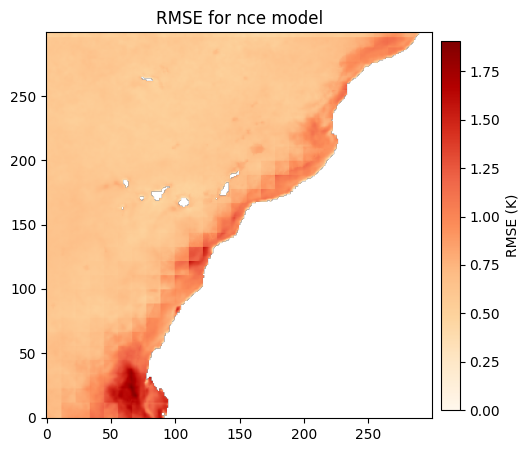

(49061,)


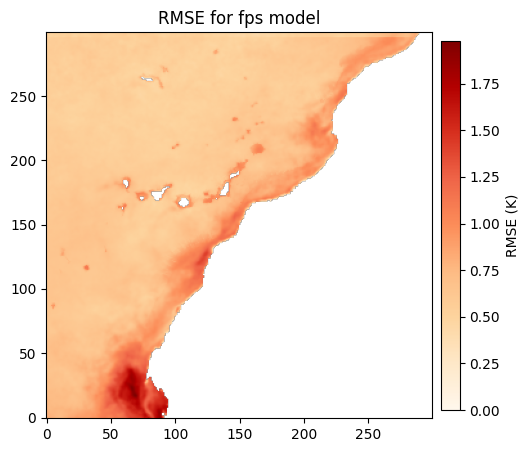

(49061,)


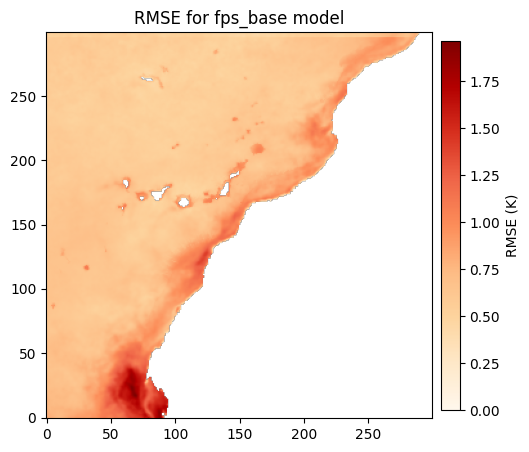

(49061,)


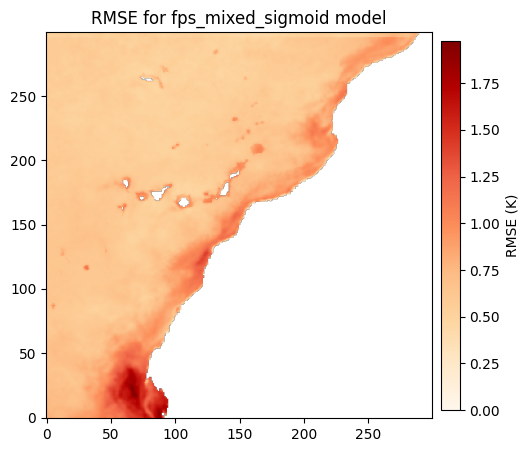

In [46]:
#calculate RMSE of the last day and plot
def generate_rmse_grid(predictions, targets, full_mask):
    rmse = calculate_rmse(['sea_surface_foundation_temperature'], 14, predictions=predictions, targets=targets)
    print(rmse.shape)

    #reshape the rmse to the grid shape
    full_rmse = np.full(full_mask[:, 0].shape, np.nan)
    full_rmse[full_mask[:, 0].astype(bool)] = rmse
    data_grid_rmse = full_rmse.reshape(*constants.GRID_SHAPE)
    return data_grid_rmse

all_data_grid_rmse = {}
for model, predictions in predictions_dict.items():
    data_grid_rmse = generate_rmse_grid(predictions, targets, full_mask)
    all_data_grid_rmse[model] = data_grid_rmse
    vmax = np.nanmax(data_grid_rmse)
    plt.figure(figsize=(6, 6))
    plt.imshow(data_grid_rmse, origin='lower', vmin=0, vmax= vmax, cmap='OrRd')
    plt.colorbar(label='RMSE (K)', shrink=0.8, pad=0.02)
    plt.title(f"RMSE for {model} model")
    plt.savefig(os.path.join(save_dir, f'rmse_{model}.svg'), dpi=300, bbox_inches='tight', format='pdf')
    plt.show()


### Specific zones to calculate RMSE

### Plot RMSE for important zones

C:\Users\Gabri\AppData\Local\Temp\ipykernel_37596\3013868226.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])


FileNotFoundError: [Errno 2] No such file or directory: 'D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024\\spatial_rmse_white_cape.pdf'

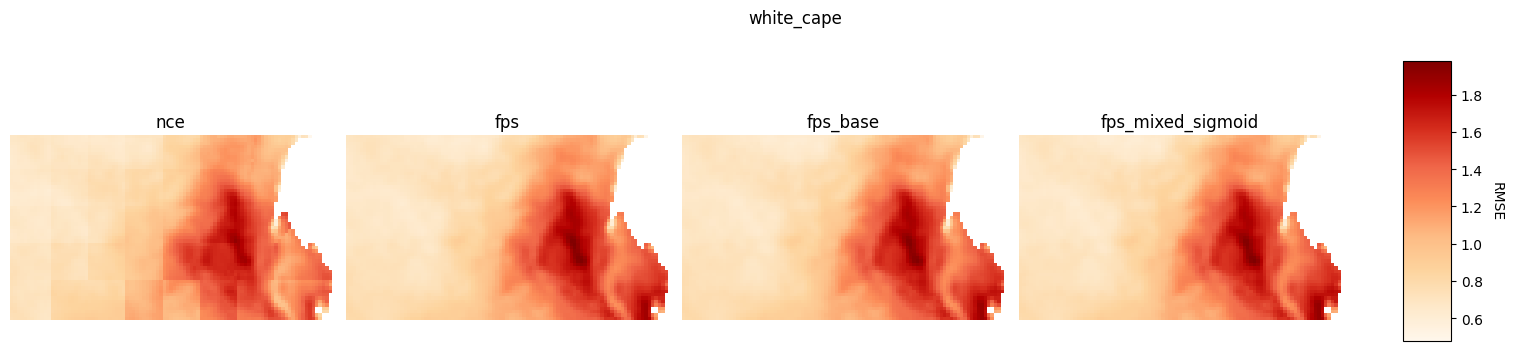

In [47]:
important_zones_masks = {}
important_zones_masks['white_cape'] = white_cape
important_zones_masks['ghir_cape'] = almost_top_cape
important_zones_masks['juby_cape'] = middle_coast
important_zones_masks['upwelling_zone'] = upwelling_zone
important_zones_masks['non_upwelling_zone'] = ocean_non_upw


import numpy as np
import matplotlib.pyplot as plt

def plot_rmse_for_important_zones(important_zones_masks: dict,
                                  all_data_grid_rmse: dict,
                                  cmap: str = "OrRd") -> None:  
    """
    For each important zone, plots a cropped RMSE map for each model in its own figure,
    with the color scale adjusted to that zone's values.

    Parameters
    ----------
    important_zones_masks : dict
        Keys are zone names (str) and values are boolean 2D masks (np.ndarray of shape (M, N))
        indicating which grid cells belong to each zone.

    all_data_grid_rmse : dict
        Keys are model names (str) and values are 2D np.ndarray of shape (M, N)
        containing the RMSE for each grid cell for that model.

    cmap : str, optional
        Colormap to use for imshow. Default is "viridis".

    Returns
    -------
    None
    """
    model_names = list(all_data_grid_rmse.keys())

    # Iterate over each zone and create a separate figure
    for zone_name, mask in important_zones_masks.items():
        # Ensure mask and grids have matching shape
        M, N = mask.shape
        for model in model_names:
            if all_data_grid_rmse[model].shape != (M, N):
                raise ValueError(
                    f"Shape mismatch for model '{model}', zone '{zone_name}': "
                    f"mask {mask.shape} vs grid {all_data_grid_rmse[model].shape}"
                )

        # Find bounding box of the zone
        ys, xs = np.where(mask)
        if ys.size == 0 or xs.size == 0:
            raise ValueError(f"Zone '{zone_name}' mask is empty.")
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()

        # Collect values within zone across models for consistent scaling
        zone_values = []
        for model in model_names:
            grid = all_data_grid_rmse[model]
            subgrid = grid[y_min:y_max+1, x_min:x_max+1]
            submask = mask[y_min:y_max+1, x_min:x_max+1]
            zone_values.append(subgrid[submask])
        all_zone_vals = np.concatenate([v.ravel() for v in zone_values if v.size > 0])
        vmin, vmax = np.nanmin(all_zone_vals), np.nanmax(all_zone_vals)

        # Create figure with one row and one column per model
        fig, axes = plt.subplots(
            nrows=1,
            ncols=len(model_names),
            figsize=(4 * len(model_names), 4),
            squeeze=False
        )

        # Adjust layout to make space for colorbar
        fig.subplots_adjust(right=0.85)

        # Plot each model's cropped RMSE without borders
        for j, model in enumerate(model_names):
            ax = axes[0][j]
            grid = all_data_grid_rmse[model]
            subgrid = grid[y_min:y_max+1, x_min:x_max+1]
            submask = mask[y_min:y_max+1, x_min:x_max+1]
            masked_subgrid = np.where(submask, subgrid, np.nan)

            im = ax.imshow(
                masked_subgrid,
                origin='lower',
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                extent=[x_min, x_max, y_min, y_max],
                rasterized=True
            )
            ax.set_title(model)
            ax.set_xticks([])
            ax.set_yticks([])
            # Remove the axis frame/border
            for spine in ax.spines.values():
                spine.set_visible(False)

        # Add colorbar on the right without overlapping
        cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('RMSE', rotation=270, labelpad=15)

        fig.suptitle(zone_name)
        plt.tight_layout(rect=[0, 0, 0.85, 0.95])
        dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024"
        plt.savefig(os.path.join(dir, f"spatial_rmse_{zone_name}.pdf"), dpi=300, bbox_inches='tight')
        plt.show()





plot_rmse_for_important_zones(important_zones_masks, all_data_grid_rmse)



In [49]:
def get_porcentage_of_upgrade_against_uniform_model_in_each_zone(important_zones_masks: dict,
                                  all_data_grid_rmse: dict):
    
    for zone_name, mask in important_zones_masks.items():
        M, N = mask.shape
        for model in all_data_grid_rmse.keys():
            if all_data_grid_rmse[model].shape != (M, N):
                raise ValueError(
                    f"Shape mismatch for model '{model}', zone '{zone_name}': "
                    f"mask {mask.shape} vs grid {all_data_grid_rmse[model].shape}"
                )
            if model == 'nce':
                baseline_grided_rmse_values = all_data_grid_rmse[model]
                baseline_subgrided_rmse_values = baseline_grided_rmse_values[mask]
                #valores no nulos:
                print("cantidad de valores no nulos: ", np.count_nonzero(baseline_subgrided_rmse_values))
                baseline_mean = np.nanmean(baseline_subgrided_rmse_values)
                continue
            model_grided_rmse_values = all_data_grid_rmse[model]
            model_subgrided_rmse_values = model_grided_rmse_values[mask]
            diff = baseline_subgrided_rmse_values- model_subgrided_rmse_values 
            mean_diff = np.nanmean(diff)
            porcentage = (mean_diff / baseline_mean) * 100
            print(f"Zona: {zone_name}, Modelo: {model}, Porcentaje de mejora: {porcentage:.2f}%")

            
get_porcentage_of_upgrade_against_uniform_model_in_each_zone(important_zones_masks, all_data_grid_rmse)
            
        


cantidad de valores no nulos:  4751
Zona: white_cape, Modelo: fps, Porcentaje de mejora: -0.60%
Zona: white_cape, Modelo: fps_base, Porcentaje de mejora: -0.50%
Zona: white_cape, Modelo: fps_mixed_sigmoid, Porcentaje de mejora: -0.63%
cantidad de valores no nulos:  6788
Zona: ghir_cape, Modelo: fps, Porcentaje de mejora: 3.68%
Zona: ghir_cape, Modelo: fps_base, Porcentaje de mejora: 3.83%
Zona: ghir_cape, Modelo: fps_mixed_sigmoid, Porcentaje de mejora: 4.72%
cantidad de valores no nulos:  3055
Zona: juby_cape, Modelo: fps, Porcentaje de mejora: 1.66%
Zona: juby_cape, Modelo: fps_base, Porcentaje de mejora: 2.42%
Zona: juby_cape, Modelo: fps_mixed_sigmoid, Porcentaje de mejora: 2.15%
cantidad de valores no nulos:  4128
Zona: upwelling_zone, Modelo: fps, Porcentaje de mejora: -0.31%
Zona: upwelling_zone, Modelo: fps_base, Porcentaje de mejora: 0.47%
Zona: upwelling_zone, Modelo: fps_mixed_sigmoid, Porcentaje de mejora: 0.09%
cantidad de valores no nulos:  44933
Zona: non_upwelling_zone,

In [61]:
ultimos_valores = {clave: valores[-1][0] for clave, valores in rmse_dict.items()}

# Mostrar resultados
for clave, valor in ultimos_valores.items():
    print(f"{clave}: {valor:.2f} K")  # Formatear a 2 decimales

nce_27_9: 13.31 K
fps_27_9: 13.15 K
fps_27_9_weighted_base: 13.16 K
fps_27_9_weighted_mixed_sigmoid: 13.10 K


In [ ]:
baseline = all_data_grid_rmse['uniform']
print("shape baseline", baseline.shape)
media_baseline_mean = np.nanmean(baseline)
random = all_data_grid_rmse['random']
bathymetry = all_data_grid_rmse['bathymetry']
media_random = np.nanmean(random)
media_bathymetry = np.nanmean(bathymetry)

porcentaje_random = (np.nanmean(baseline - random) / media_baseline_mean) * 100
porcentaje_bathymetry = (np.nanmean(baseline - bathymetry) / media_baseline_mean) * 100
print(f"Zona: global, Modelo: random, Porcentaje de mejora: {porcentaje_random:.2f}%")
print(f"Zona: global, Modelo: bathymetry, Porcentaje de mejora: {porcentaje_bathymetry:.2f}%")

shape baseline (300, 300)
Zona: global, Modelo: random, Porcentaje de mejora: 1.04%
Zona: global, Modelo: bathymetry, Porcentaje de mejora: 0.79%


In [ ]:
#difference of RMSE between models in the important zones

def calculate_rmse_difference_by_zone(important_zones_masks: dict,
                                      all_data_grid_rmse: dict) -> dict:
    """
    For each important zone, calculates pairwise differences in mean RMSE between models
    and returns a table (DataFrame) per zone.

    Parameters
    ----------
    important_zones_masks : dict
        Keys are zone names (str) and values are boolean 2D masks (np.ndarray of shape (M, N))
        indicating which grid cells belong to each zone.

    all_data_grid_rmse : dict
        Keys are model names (str) and values are 2D np.ndarray of shape (M, N)
        containing the RMSE for each grid cell for that model.

    Returns
    -------
    dict
        Keys are zone names (str). Values are pandas DataFrame of shape (N_models, N_models)
        where each entry [i, j] is the difference mean_rmse(model_i) - mean_rmse(model_j).
    """
    model_names = list(all_data_grid_rmse.keys())
    diff_tables = {}

    for zone_name, mask in important_zones_masks.items():
        # Compute mean RMSE per model for this zone
        mean_rmse = {}
        for model in model_names:
            grid = all_data_grid_rmse[model]
            if grid.shape != mask.shape:
                raise ValueError(
                    f"Shape mismatch for model '{model}', zone '{zone_name}': "
                    f"mask {mask.shape} vs grid {grid.shape}"
                )
            vals = grid[mask]
            mean_rmse[model] = np.nanmean(vals) if vals.size > 0 else np.nan

        # Build DataFrame of differences
        df = pd.DataFrame(index=model_names, columns=model_names, dtype=float)
        for m1 in model_names:
            for m2 in model_names:
                df.loc[m1, m2] = mean_rmse[m1] - mean_rmse[m2]
        diff_tables[zone_name] = df

    return diff_tables

# Calculate RMSE differences for important zones
rmse_differences = calculate_rmse_difference_by_zone(important_zones_masks, all_data_grid_rmse)


### Matrix with differences between models

C:\Users\Gabri\AppData\Local\Temp\ipykernel_5400\2717498558.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


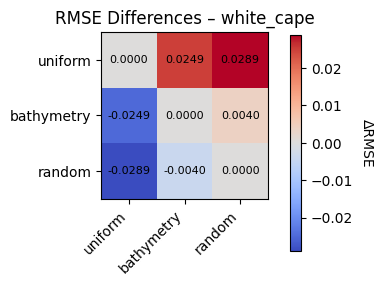

C:\Users\Gabri\AppData\Local\Temp\ipykernel_5400\2717498558.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


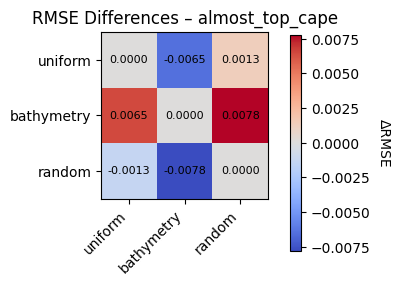

C:\Users\Gabri\AppData\Local\Temp\ipykernel_5400\2717498558.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


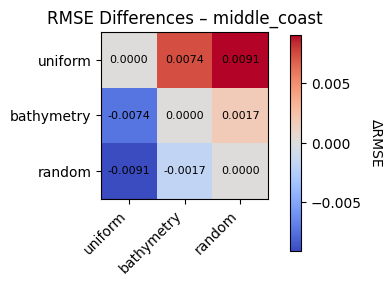

C:\Users\Gabri\AppData\Local\Temp\ipykernel_5400\2717498558.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


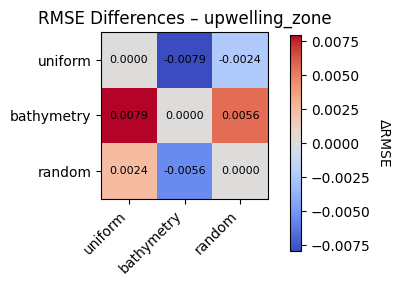

C:\Users\Gabri\AppData\Local\Temp\ipykernel_5400\2717498558.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


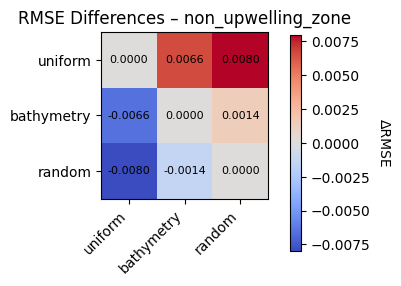

In [ ]:
def visualize_rmse_diff_tables(diff_tables: dict, cmap: str = 'coolwarm'):
    """
    Visualizes pairwise RMSE difference tables for each zone as annotated heatmaps.

    Parameters
    ----------
    diff_tables : dict
        Keys are zone names (str). Values are pandas DataFrames where each cell [i, j]
        is mean_rmse(model_i) - mean_rmse(model_j).

    cmap : str, optional
        Colormap for heatmap. Default is 'coolwarm'.

    Returns
    -------
    None
    """
    for zone_name, df in diff_tables.items():
        models = df.index.tolist()
        data = df.values.astype(float)
        vmin, vmax = np.nanmin(data), np.nanmax(data)

        fig, ax = plt.subplots(figsize=(1.2 * len(models), 1.2 * len(models)))
        cax = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)

        # Annotate cells
        for (i, j), val in np.ndenumerate(data):
            text = f'{val:.4f}' if not np.isnan(val) else ''
            ax.text(j, i, text, ha='center', va='center', fontsize=8)

        ax.set_xticks(range(len(models)))
        ax.set_yticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_yticklabels(models)
        ax.set_title(f'RMSE Differences – {zone_name}')

        # Colorbar on the right
        fig.subplots_adjust(right=0.8, top=0.9, bottom=0.2)
        cbar_ax = fig.add_axes([0.82, 0.2, 0.03, 0.6])
        cbar = fig.colorbar(cax, cax=cbar_ax)
        cbar.set_label('ΔRMSE', rotation=270, labelpad=15)

        plt.tight_layout(rect=[0, 0, 0.8, 1])
        #dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024"
        #plt.savefig(os.path.join(dir, f'rmse_diff_{zone_name}.svg'), dpi=300, bbox_inches='tight')
        plt.show()

visualize_rmse_diff_tables(rmse_differences, cmap='coolwarm')

### Temporal series of RMSE for all models of the last day of each file

In [ ]:
#def get_date_from_filenames_for_t_day(directory, ):

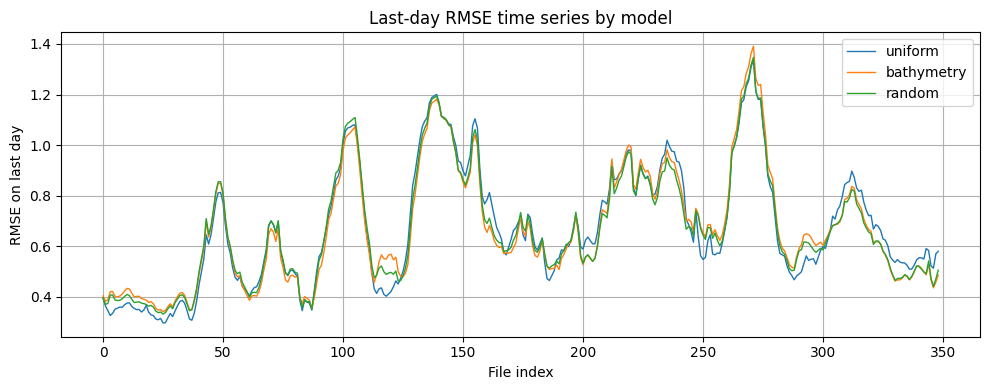

In [ ]:
import numpy as np


# 2) A helper that computes the last‐day RMSE time series for each entry in the dict
def compute_last_day_rmse_dict(stacked_targets: np.ndarray,
                               predictions_dict: dict) -> dict:
    """
    Given:
      - stacked_targets: np.ndarray of shape (F, D, P, 1)
      - predictions_dict: { name: np.ndarray(F, D, P, 1), ... }

    Returns:
      { name: np.ndarray of length F } mapping each model name to its RMSE series.
    """
    # extract the true last‐day slice once
    t_last = stacked_targets[:, -1, :, 0]   # shape (F, P)

    rmse_series = {}
    for name, preds in predictions_dict.items():
        p_last = preds[:, -1, :, 0]         # shape (F, P)
        # RMSE over points, per file
        rmse = np.sqrt(np.nanmean((p_last - t_last) ** 2, axis=1))
        rmse_series[name] = rmse

    return rmse_series

# 3) Now call it:
rmse_by_model = compute_last_day_rmse_dict(targets, predictions_dict)
# rmse_by_model is e.g. { "uniform": array([...]), "bathymetry": array([...]), "random": array([...]) }

# 4) And a quick plot:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for name, series in rmse_by_model.items():
    plt.plot(series, '-', label=name, linewidth=1, markersize=4)
plt.xlabel("File index")
plt.ylabel("RMSE on last day")
plt.title("Last‐day RMSE time series by model")
plt.legend()
plt.grid(True)
plt.tight_layout()
#dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024"
#plt.savefig(os.path.join(dir, "last_day_rmse_time_series_all_zone.svg"), dpi=300, bbox_inches='tight')
plt.show()



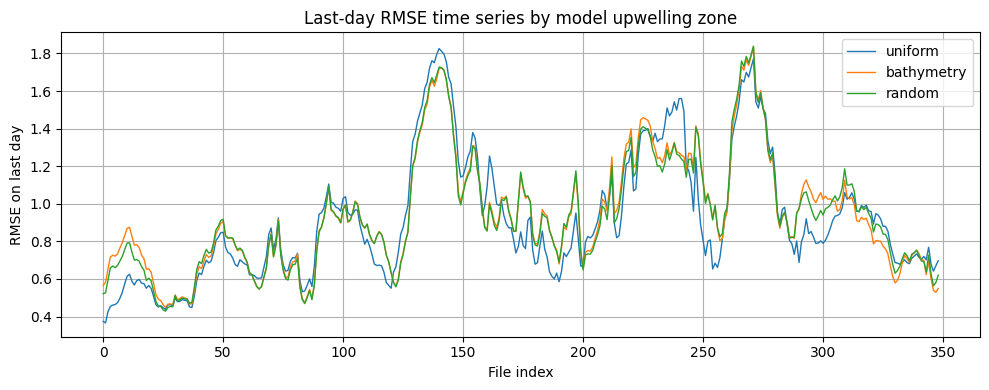

In [ ]:
rmse_by_model_upw = compute_last_day_rmse_dict(targets_upw, predictions_upw_dict)
# rmse_by_model is e.g. { "uniform": array([...]), "bathymetry": array([...]), "random": array([...]) }

# 4) And a quick plot:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for name, series in rmse_by_model_upw.items():
    plt.plot(series, '-', label=name, linewidth=1, markersize=4)
plt.xlabel("File index")
plt.ylabel("RMSE on last day")
plt.title("Last‐day RMSE time series by model upwelling zone")
plt.legend()
plt.grid(True)
plt.tight_layout()
#dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024"
#plt.savefig(os.path.join(dir, "last_day_rmse_time_series_upwelling_zone.svg"), dpi=300, bbox_inches='tight')
plt.show()


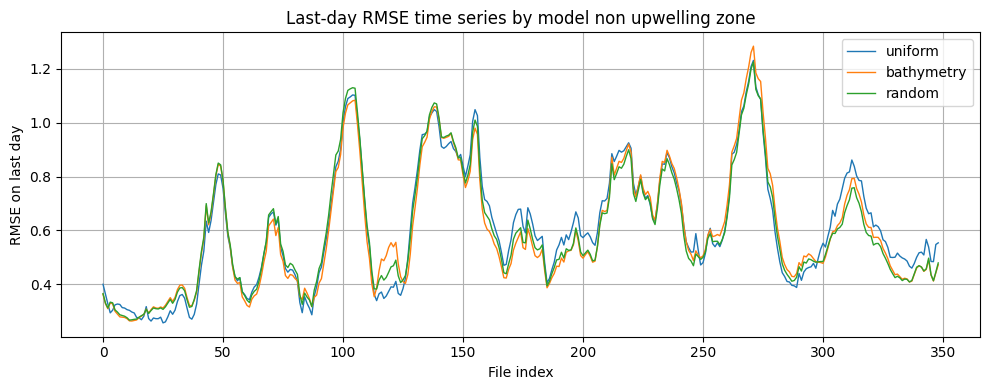

In [ ]:
rmse_by_model_non_upw = compute_last_day_rmse_dict(targets_non_upw, predictions_non_upw_dict)

plt.figure(figsize=(10, 4))
for name, series in rmse_by_model_non_upw.items():
    plt.plot(series, '-', label=name, linewidth=1, markersize=4)
plt.xlabel("File index")
plt.ylabel("RMSE on last day")
plt.title("Last‐day RMSE time series by model non upwelling zone")
plt.legend()
plt.grid(True)
plt.tight_layout()
#dir = "D:/ULPGC/4Curso/TFG/seacast_code/Proyecto_TFG/Seacast/figures/metrics_predictions/paper_april_2024"
#plt.savefig(os.path.join(dir, "last_day_rmse_time_series_non_upwelling_zone.svg"), dpi=300, bbox_inches='tight')
plt.savefig
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

param_indices = {p: i for i, p in enumerate(constants.EXP_PARAM_NAMES_SHORT)}

def calculate_difference(params, timestep,
                         predictions=uniform_predictions,
                         targets=targets):
    """
    Calcula el sesgo medio espacial (prediction – truth) para los parámetros dados.
    - params: lista de nombres de parámetros (strings)
    - timestep: entero
    - devuelve un array de longitud n_puntos con el sesgo medio.
    """
    idxs = [param_indices[p] for p in params]
    # Inicializamos suma de sesgos
    diff_spatial = np.zeros((predictions.shape[2],), dtype=float)

    for param_idx in idxs:
        # 1) Diferencia batch×puntos
        diff = predictions[:, timestep, :, param_idx] - targets[:, timestep, :, param_idx]
        # 2) Aplicar máscara de océano interior
        diff_masked = diff * sea_mask_bool[:, param_idx]
        # 3) Promedio sobre el batch (axis=0 → vector length=n_puntos)
        diff_mean = np.nanmean(diff_masked, axis=0)
        diff_spatial += diff_mean

    # 4) Dividir para obtener el sesgo medio si hay varios parámetros
    diff_spatial /= len(idxs)
    return diff_spatial


def plot_difference(params, param_name,
                    predictions=uniform_predictions,
                    targets=targets):
    """
    Pinta el sesgo medio espacial en 4 horizontes (1,5,10,15 d).
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 7), constrained_layout=True)
    timesteps = [0, 4, 9, 14]

    # 1) Recolectar todos los sesgos para fijar vmin/vmax
    all_data = [calculate_difference(params, t, predictions, targets)
                for t in timesteps]
    vmin, vmax = min(d.min() for d in all_data), max(d.max() for d in all_data)
    # Simetrizar en 0 para colormap divergente
    m = max(abs(vmin), abs(vmax))
    vmin, vmax = -m, m

    cmap = plt.get_cmap('RdBu_r')
    cmap.set_bad(color=(1,1,1,0))

    # 2) Dibujar cada panel
    for i, t in enumerate(timesteps):
        diff_spatial = all_data[i]

        # Reconstruir rejilla completa (con NaN fuera de máscara)
        mask_full = full_mask[:, param_indices[params[0]]]  # máscara para este parámetro
        full_grid = np.full(mask_full.shape, np.nan)
        full_grid[mask_full.astype(bool)] = diff_spatial
        data_grid = full_grid.reshape(*constants.GRID_SHAPE)

        ax = axes[i//2, i%2]
        im = ax.imshow(data_grid, origin='lower',
                       cmap=cmap, vmin=vmin, vmax=vmax)
        ax.axis('off')
        ax.set_title(f'{t+1} d', fontsize=16)

    # 3) Colorbar común
    cbar = fig.colorbar(im,
                        ax=axes.ravel().tolist(),
                        orientation='horizontal',
                        fraction=0.02,
                        aspect=40,
                        extend='both')
    unit = constants.EXP_PARAM_UNITS[param_indices[params[0]]]
    cbar.set_label(unit, fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.show()


In [ ]:
diffe = calculate_difference(['sea_surface_foundation_temperature'], 0, predictions=uniform_predictions, targets=targets)
print(diffe.shape)

(49061,)


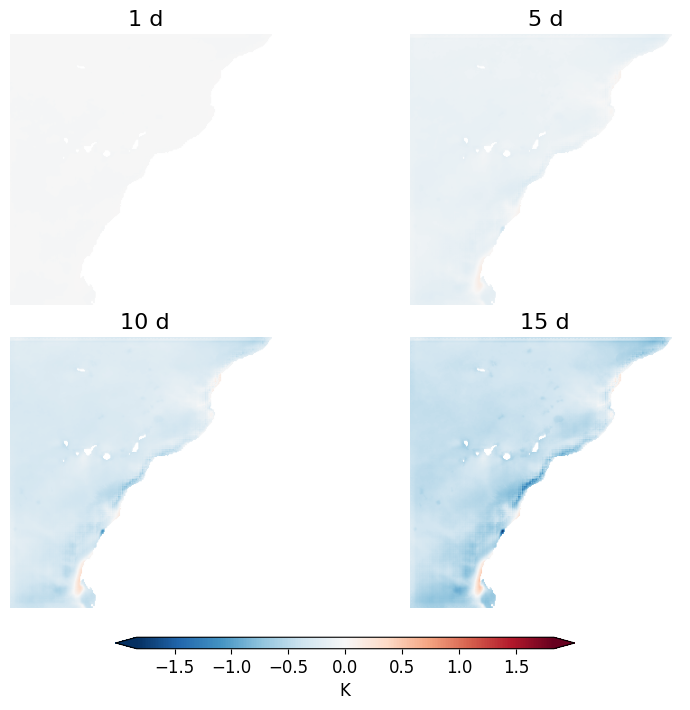

In [ ]:
plot_difference(['sea_surface_foundation_temperature'], 'sea_surface_foundation_temperature',
                 predictions=uniform_predictions, targets=targets)

In [ ]:
def plot_forecast_vs_target(timestep, var_idx, ax_forecast, ax_target,
                            var_name, cmap, vmin=None, vmax=None, predictions=uniform_predictions, targets=targets):
    # 1) Cálculo de las medias espaciales
    forecast_spatial = predictions[:, timestep, :, var_idx].mean(axis=0)
    target_spatial   = targets[:,           timestep, :, var_idx].mean(axis=0)

    # 2) Reconstrucción en la malla completa
    obs_mask      = full_mask[:, var_idx].astype(bool)
    interior_mask = sea_mask_bool[:, var_idx]
    shape         = obs_mask.shape

    full_forecast = np.full(shape, np.nan)
    full_target   = np.full(shape, np.nan)
    full_forecast[obs_mask] = forecast_spatial[interior_mask]
    full_target[obs_mask]   = target_spatial[interior_mask]

    # 3) Si no hay vmin/vmax, calculamos aquí
    if vmin is None or vmax is None:
        datos = np.concatenate([
            full_forecast[~np.isnan(full_forecast)],
            full_target[  ~np.isnan(full_target  )]
        ])
        if vmin is None:
            vmin = np.nanmin(datos)
        if vmax is None:
            vmax = np.nanmax(datos)

    # 4) Dibujar forecast
    grid_forecast = full_forecast.reshape(*constants.GRID_SHAPE)
    im1 = ax_forecast.imshow(grid_forecast, origin='lower',
                             cmap=cmap, vmin=vmin, vmax=vmax)
    ax_forecast.tick_params(left=False, bottom=False,
                            labelleft=False, labelbottom=False)
    for spine in ax_forecast.spines.values():
        spine.set_visible(False)

    # 5) Dibujar target
    grid_target = full_target.reshape(*constants.GRID_SHAPE)
    im2 = ax_target.imshow(grid_target, origin='lower',
                           cmap=cmap, vmin=vmin, vmax=vmax)
    ax_target.axis('off')

    return im1, im2


def plot_timesteps_for_variable(var_name, sample=8,
                                timesteps=[0, 4, 9, 14], has_label=True,
                                predictions=uniform_predictions, targets=targets):
    # A) Preparación de la figura
    nrows  = len(timesteps)
    height = 3.8 if nrows == 1 else 3.3 * nrows
    fig, axes = plt.subplots(nrows, 2+1, figsize=(8, height),
                             constrained_layout=True)

    fs = 16  # tamaño de fuente

    # B) Índice de variable y colormap
    var_idx  = constants.EXP_PARAM_NAMES_SHORT.index(var_name)
    cmap_str = constants.EXP_PARAM_COLORMAPS[var_idx]
    cmap     = plt.get_cmap(cmap_str)
    cmap.set_bad(color=(1, 1, 1, 0))  # transparent for NaNs

    # C) Recolectar todos los valores para un vmin/vmax global
    all_vals = []
    for t in timesteps:
        f = predictions[sample, t, :, var_idx]
        y =        targets[sample, t, :, var_idx]
        all_vals.extend([f, y])

    vmin = np.nanmin(all_vals)
    vmax = np.nanmax(all_vals)

    # D) Dibujar cada fila (forecast vs target)
    axes = np.atleast_2d(axes)
    ims  = []
    for i, t in enumerate(timesteps):
        im1, im2 = plot_forecast_vs_target(
            t, var_idx,
            axes[i, 0], axes[i, 1],
            var_name, cmap, vmin, vmax, predictions, targets
        )
        #dibujar RMSE tambien como una imagen
        rmse_spatial = calculate_rmse(['sea_surface_foundation_temperature'], t, predictions, targets)
        full_rmse = np.full(full_mask[:, 0].shape, np.nan)
        full_rmse[full_mask[:, 0].astype(bool)] = rmse_spatial
        data_grid_rmse = full_rmse.reshape(*constants.GRID_SHAPE)
        ax = axes[i, 2]
        vmin_rmse = 0
        vmax_rmse = max(data.max() for data in rmse_spatial)
        im_rmse = ax.imshow(data_grid_rmse, origin='lower', vmin=vmin_rmse, vmax=vmax_rmse, cmap="OrRd")

        ims.extend([im1, im2, im_rmse])

    # E) Títulos de columnas
    axes[0, 0].set_title('Predicted',    fontsize=fs)
    axes[0, 1].set_title('Ground Truth', fontsize=fs)

    # F) Etiquetas de día a la izquierda
    if has_label:
        for i, t in enumerate(timesteps):
            ax = axes[i, 0]
            ax.yaxis.set_label_position("left")
            ax.set_ylabel(
                f'{1 + t} d',
                rotation=0,
                fontsize=fs,
                labelpad=25,  # espacio entre label y gráfico
                va='center'
            )

    # G) Colorbar común
    frac   = 0.04 if nrows == 1 else 0.015
    extend = 'both' if var_name == 'mlotst' else 'neither'
    cbar = fig.colorbar(ims[0],
                        ax=axes.ravel().tolist(),
                        orientation='horizontal',
                        fraction=frac,
                        aspect=40,
                        extend=extend)
    cbar.set_label(constants.EXP_PARAM_UNITS[var_idx], fontsize=12)
    cbar.ax.tick_params(labelsize=14)

    plt.show()


In [ ]:
print(*constants.GRID_SHAPE)
print(constants.EXP_PARAM_NAMES_SHORT)

300 300
['sea_surface_foundation_temperature']


Con este gráfico se conseguiría la media de los valores del SST en una predicción determinada, es decir, comparar la media de las predicciones a 15 días con la media de los valores reales a 15 días.

In [ ]:
samples = uniform_predictions.shape[0]

AttributeError: 'dict' object has no attribute 'shape'

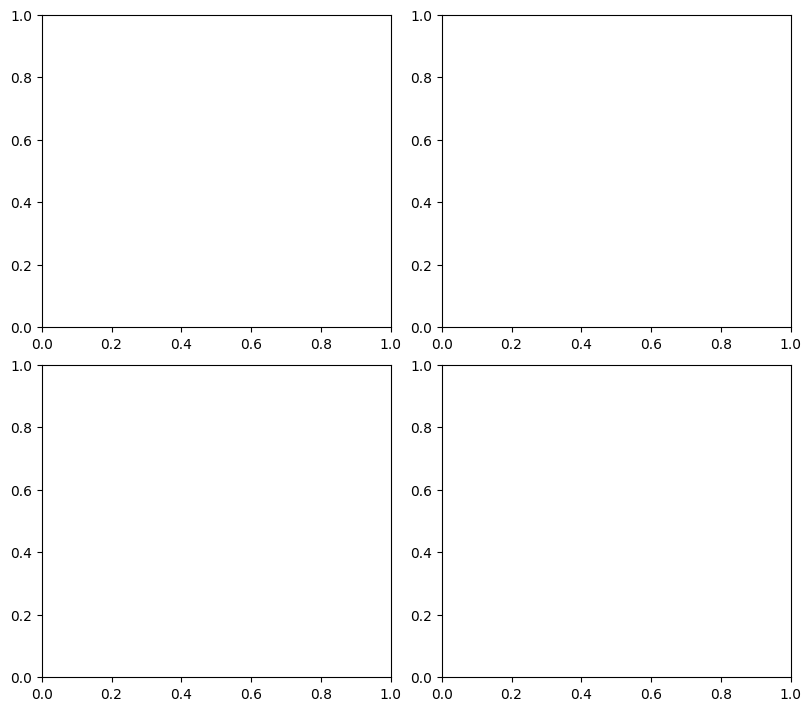

In [ ]:
plot_rmse(['sea_surface_foundation_temperature'], 'sea_surface_foundation_temperature', 
          predictions=predictions_dict, targets=targets)

In [ ]:
plot_timesteps_for_variable('sea_surface_foundation_temperature',sample = samples-1, timesteps=[0, 4, 9, 14], has_label=True,
                             predictions=uniform_predictions, targets=targets)


In [ ]:
plot_rmse(['sea_surface_foundation_temperature'], 'sea_surface_foundation_temperature', 
          predictions=uniform_predictions, targets=targets)

In [ ]:
plot_difference(['sea_surface_foundation_temperature'], 'sea_surface_foundation_temperature',
                predictions=uniform_predictions, targets=targets)